# Analysis of Leios simulations at tag `leios-2025w17`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(R.utils, quietly=TRUE)
    require(stringr, quietly=TRUE)
})

## Varied TPS

In [2]:
tmp1 <- fread("tps/1/tx.csv.gz", stringsAsFactors=TRUE)
tmp10 <- fread("tps/10/tx.csv.gz", stringsAsFactors=TRUE)
txs <- rbind(
    cbind(TPS=1, tmp1),
    cbind(TPS=10, tmp10)
)
txs %>% summary

      TPS               Tx        Generated [s]       Size [B]      
 Min.   : 1.000   Min.   :    0   Min.   :   0.0   Min.   :    6.0  
 1st Qu.:10.000   1st Qu.: 6718   1st Qu.: 899.7   1st Qu.:  434.0  
 Median :10.000   Median :17234   Median :1807.8   Median :  935.5  
 Mean   : 9.187   Mean   :17577   Mean   :1804.6   Mean   : 1701.7  
 3rd Qu.:10.000   3rd Qu.:27751   3rd Qu.:2708.8   3rd Qu.: 1992.0  
 Max.   :10.000   Max.   :38267   Max.   :3599.9   Max.   :16384.0  
                                                                    
 IB inclusions  Time to IB [s]   EB references    Time to EB reference [s]
 Min.   :0.00   Min.   : 0.132   Min.   : 0.000   Min.   : 21.11          
 1st Qu.:2.00   1st Qu.: 1.211   1st Qu.: 1.000   1st Qu.: 24.92          
 Median :2.00   Median : 1.734   Median : 3.000   Median : 27.50          
 Mean   :2.37   Mean   : 1.961   Mean   : 3.716   Mean   : 27.60          
 3rd Qu.:3.00   3rd Qu.: 2.426   3rd Qu.: 6.000   3rd Qu.: 30.06         

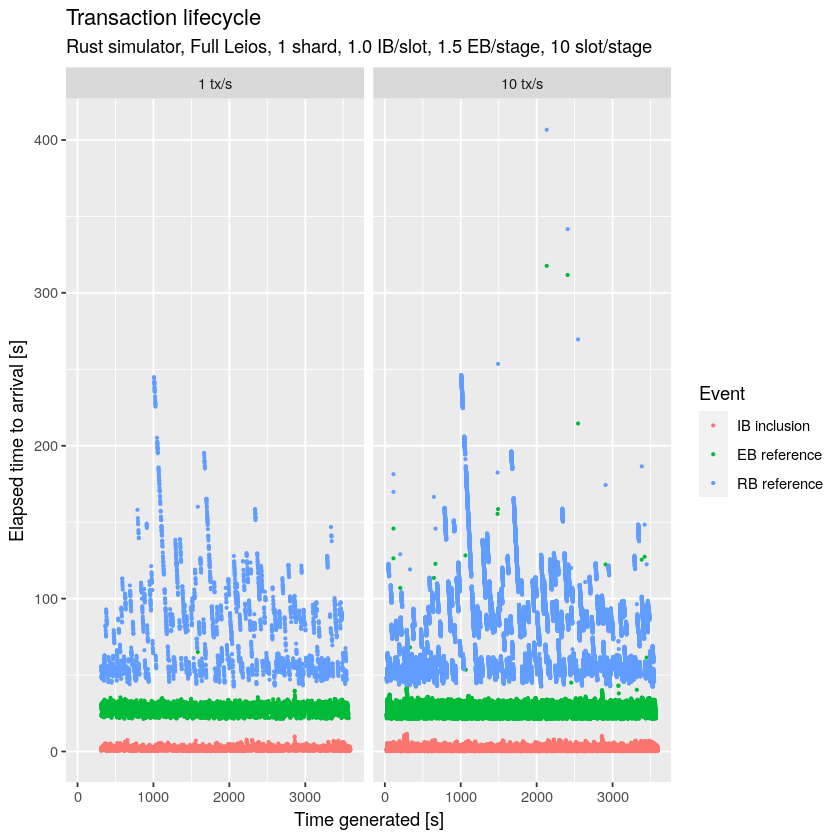

In [3]:
ggplot(
    melt(
        txs[is.na(`Time to Praos inclusion [s]`), .(
            `TPS`=factor(paste(`TPS`, "tx/s")),
            `Tx`,
            `Time generated [s]`=`Generated [s]`,
            `IB inclusion`=`Time to IB [s]`, 
            `EB reference`=`Time to EB reference [s]`, 
            `RB reference`=`Time to RB reference [s]`
        )],
        id.vars=c("TPS", "Tx", "Time generated [s]"),
        variable.name="Event",
        value.name="Elapsed time to arrival [s]"
    )[!is.na(`Elapsed time to arrival [s]`)],
    aes(x=`Time generated [s]`, y=`Elapsed time to arrival [s]`, color=`Event`)
) + geom_point(size=0.5) +
    facet_grid(. ~ `TPS`) +
    ggtitle(
        "Transaction lifecycle",
        subtitle="Rust simulator, Full Leios, 1 shard, 1.0 IB/slot, 1.5 EB/stage, 10 slot/stage"
    )

In [4]:
ggsave("plots/lifecycle-timeseries.png", units="in", dpi=150, width=9.50, height=5.25)

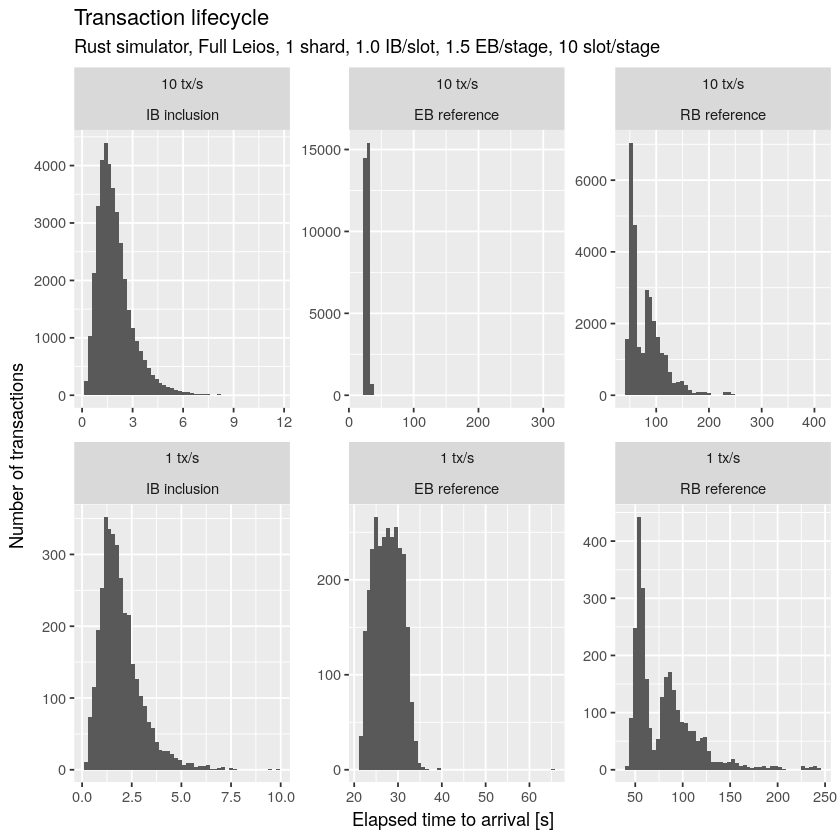

In [5]:
ggplot(
    melt(
        txs[is.na(`Time to Praos inclusion [s]`), .(
            `TPS`=factor(paste(`TPS`, "tx/s"), levels=c("10 tx/s", "1 tx/s")),
            `Tx`,
            `Time generated [s]`=`Generated [s]`,
            `IB inclusion`=`Time to IB [s]`, 
            `EB reference`=`Time to EB reference [s]`, 
            `RB reference`=`Time to RB reference [s]`
        )],
        id.vars=c("TPS", "Tx", "Time generated [s]"),
        variable.name="Event",
        value.name="Elapsed time to arrival [s]"
    )[`Event` != "RB inclusion" & !is.na(`Elapsed time to arrival [s]`)],
    aes(x=`Elapsed time to arrival [s]`)
) + geom_histogram(bins=50) +
    ylab("Number of transactions") +
    facet_wrap(`TPS` ~ `Event`, scales="free") +
    ggtitle(
        "Transaction lifecycle",
        subtitle="Rust simulator, Full Leios, 1 shard, 1.0 IB/slot, 1.5 EB/stage, 10 slot/stage"
    )

In [6]:
ggsave("plots/lifecycle-histogram.png", units="in", dpi=150, width=9.50, height=5.25)

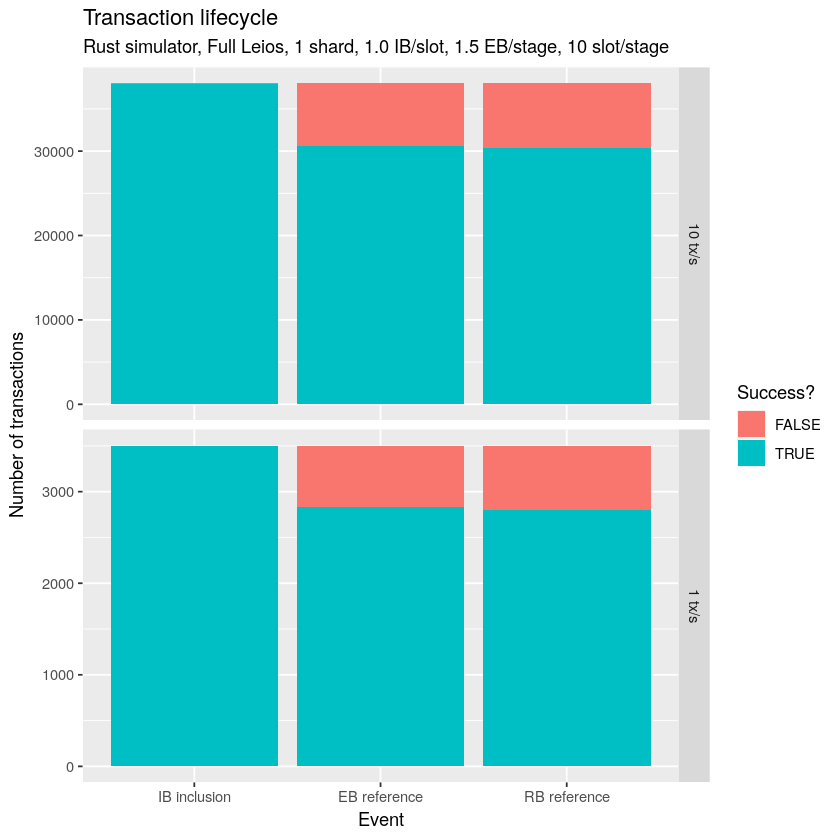

In [7]:
ggplot(
    melt(
        txs[is.na(`Time to Praos inclusion [s]`), .(
            `TPS`=factor(paste(`TPS`, "tx/s"), levels=c("10 tx/s", "1 tx/s")),
            `Tx`,
            `Time generated [s]`=`Generated [s]`,
            `IB inclusion`=`Time to IB [s]`, 
            `EB reference`=`Time to EB reference [s]`, 
            `RB reference`=`Time to RB reference [s]`
        )],
        id.vars=c("TPS", "Tx", "Time generated [s]"),
        variable.name="Event",
        value.name="Elapsed time to arrival [s]"
    )[, .(`TPS`, `Event`, `Success?`=!is.na(`Elapsed time to arrival [s]`))],
    aes(x=`Event`, fill=`Success?`)
) + geom_bar() +
    ylab("Number of transactions") +
    facet_grid(`TPS` ~ ., scales="free_y") +
    ggtitle(
        "Transaction lifecycle",
        subtitle="Rust simulator, Full Leios, 1 shard, 1.0 IB/slot, 1.5 EB/stage, 10 slot/stage"
    )

In [8]:
ggsave("plots/lifecycle-success.png", units="in", dpi=150, width=9.50, height=5.25)

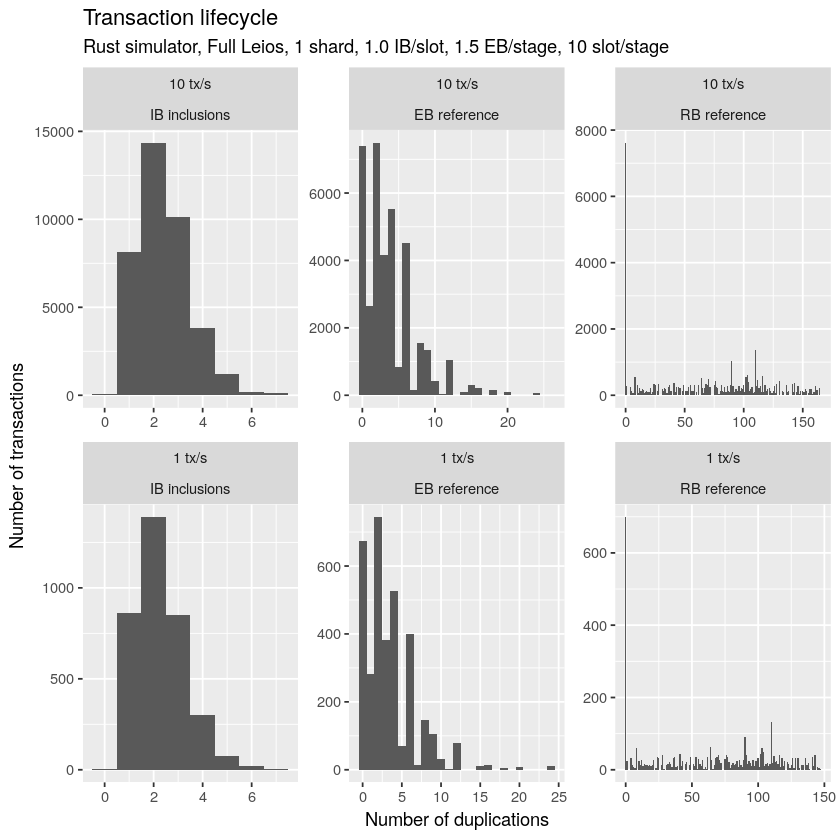

In [9]:
ggplot(
    melt(
        txs[`Praos inclusions` == 0, .(
            `TPS`=factor(paste(`TPS`, "tx/s"), levels=c("10 tx/s", "1 tx/s")),
            `Tx`,
            `IB inclusions`=`IB inclusions`, 
            `EB reference`=`EB references`, 
            `RB reference`=`RB references`
        )],
        id.vars=c("TPS", "Tx"),
        variable.name="Event",
        value.name="Number of duplications"
    ),
    aes(x=`Number of duplications`)
) + geom_histogram(binwidth=1) +
    ylab("Number of transactions") +
    facet_wrap(`TPS` ~ `Event`, scales="free") +
    ggtitle(
        "Transaction lifecycle",
        subtitle="Rust simulator, Full Leios, 1 shard, 1.0 IB/slot, 1.5 EB/stage, 10 slot/stage"
    )

In [10]:
ggsave("plots/lifecycle-duplication.png", units="in", dpi=150, width=9.50, height=5.25)

## Diagnostics on 100-Node Network

### Resource usage

In [11]:
resources <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
resources %>% summary

   simulator      label                  network      ib-generation-probability
 haskell:13500   full:27000   100-nodes-4cpus:27000   Min.   :0.5              
 rust   :13500                                        1st Qu.:1.0              
                                                      Median :2.0              
                                                      Mean   :3.1              
                                                      3rd Qu.:4.0              
                                                      Max.   :8.0              
                                                                               
 ib-body-avg-size-bytes eb-generation-probability leios-stage-length-slots
 Min.   : 65536         Min.   :1.5               Min.   : 5.00           
 1st Qu.: 65536         1st Qu.:1.5               1st Qu.: 5.00           
 Median : 98304         Median :2.0               Median :10.00           
 Mean   : 98304         Mean   :2.0               Mean   :11

In [12]:
# Only analyze the results for Full Leios
resources <- resources[`label` == "full"]

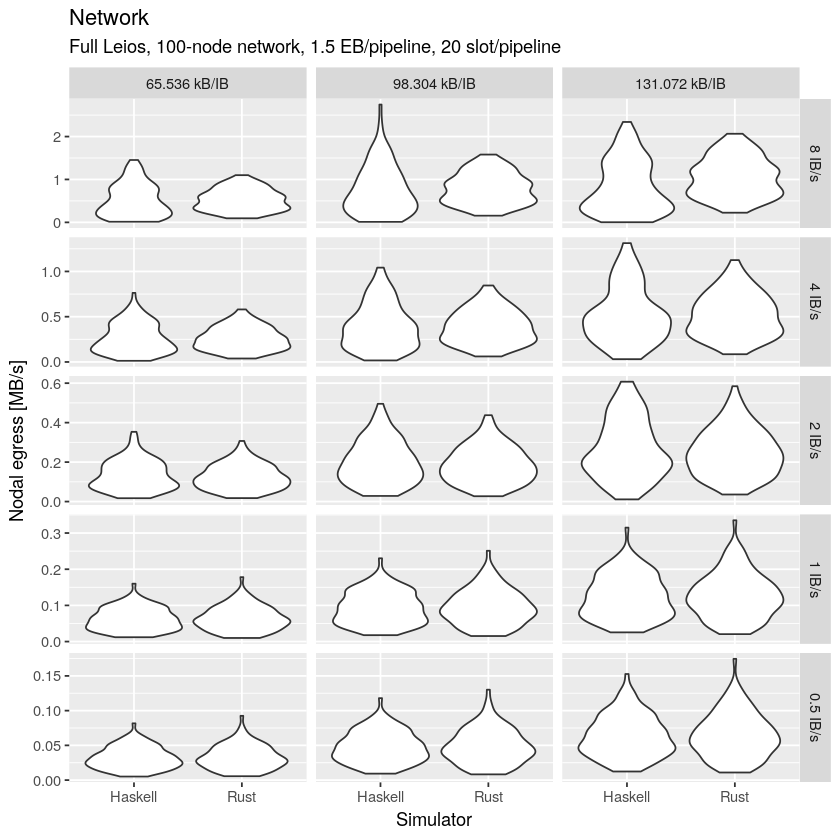

In [13]:
ggplot(
    resources[
        `eb-generation-probability` == 1.5 & `leios-stage-length-slots` == 20,
        .(
            `Simulator`=str_to_title(`simulator`),
            `node`,
            `ib-generation-probability`=factor(paste(`ib-generation-probability`,"IB/s"),levels=c("0.5 IB/s","1 IB/s","2 IB/s","4 IB/s","8 IB/s","16 IB/s")%>%rev),
            `ib-body-avg-size-bytes`=factor(paste(`ib-body-avg-size-bytes`/1000,"kB/IB"),levels=c("65.536 kB/IB", "98.304 kB/IB", "131.072 kB/IB")),
            `Nodal egress [MB/s]`=`egress`/600/1e6
        )
    ], aes(x=`Simulator`, y=`Nodal egress [MB/s]`)
) +
    geom_violin() +
    facet_grid(`ib-generation-probability` ~ `ib-body-avg-size-bytes`, scales="free_y") +
    ggtitle("Network", subtitle="Full Leios, 100-node network, 1.5 EB/pipeline, 20 slot/pipeline")

In [14]:
ggsave("plots/network.png", units="in", dpi=150, width=9.5, height=5.5)

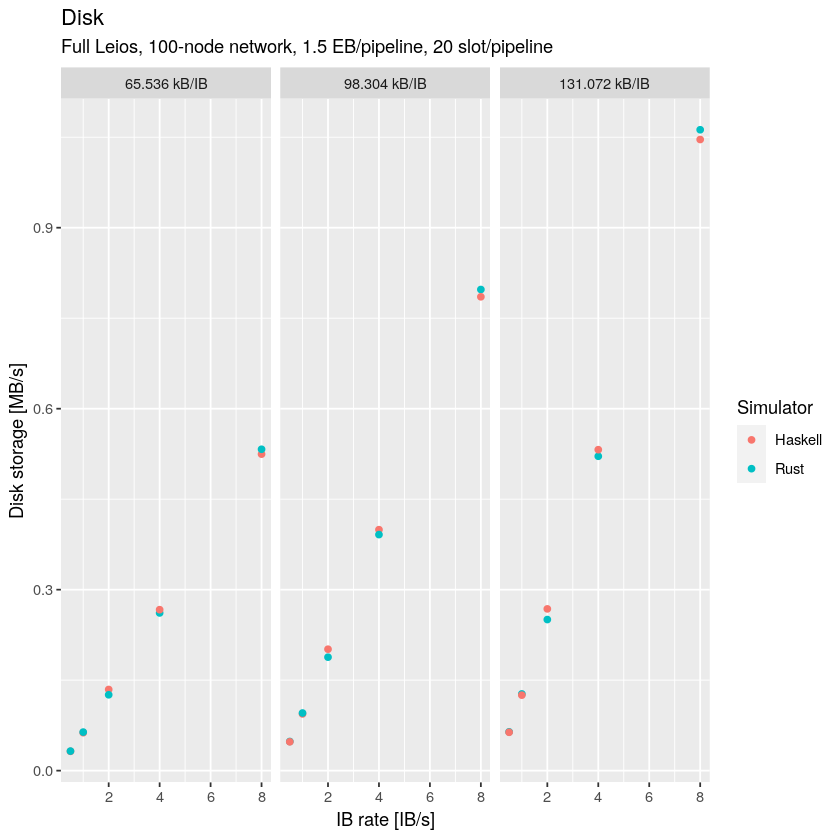

In [15]:
ggplot(
    resources[
        `eb-generation-probability` == 1.5 & `leios-stage-length-slots` == 20,
        .(
            `Disk storage [MB/s]`=mean(`disk`)/600/1e6
        ),
        .(
            `Simulator`=str_to_title(`simulator`),
            `IB rate [IB/s]`=`ib-generation-probability`,
            `IB Size`=factor(paste(`ib-body-avg-size-bytes`/1000,"kB/IB"),levels=c("65.536 kB/IB", "98.304 kB/IB", "131.072 kB/IB"))
        )
        
    ], aes(x=`IB rate [IB/s]`, y=`Disk storage [MB/s]`, color=`Simulator`)
) +
    geom_point() +
    facet_grid(. ~ `IB Size`) +
    ggtitle("Disk", subtitle="Full Leios, 100-node network, 1.5 EB/pipeline, 20 slot/pipeline")

In [16]:
ggsave("plots/disk.png", units="in", dpi=150, width=9.5, height=5.5)

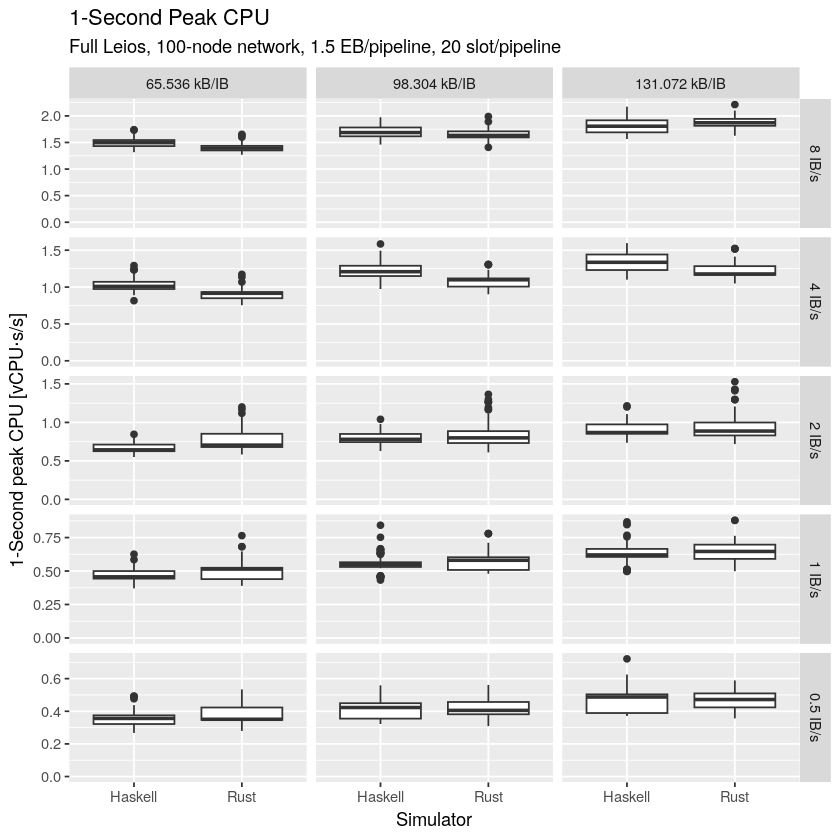

In [17]:
ggplot(
    resources[
        `eb-generation-probability` == 1.5 & `leios-stage-length-slots` == 20,
        .(
            `Simulator`=str_to_title(`simulator`),
            `node`,
            `ib-generation-probability`=factor(paste(`ib-generation-probability`,"IB/s"),levels=c("0.5 IB/s","1 IB/s","2 IB/s","4 IB/s","8 IB/s","16 IB/s")%>%rev),
            `ib-body-avg-size-bytes`=factor(paste(`ib-body-avg-size-bytes`/1000,"kB/IB"),levels=c("65.536 kB/IB", "98.304 kB/IB", "131.072 kB/IB")),
            `1-Second peak CPU [vCPU⋅s/s]`=`maximum_cpu`
        )
    ], aes(x=`Simulator`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`ib-generation-probability` ~ `ib-body-avg-size-bytes`, scales="free_y") +
    ggtitle("1-Second Peak CPU", subtitle="Full Leios, 100-node network, 1.5 EB/pipeline, 20 slot/pipeline")

In [18]:
ggsave("plots/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

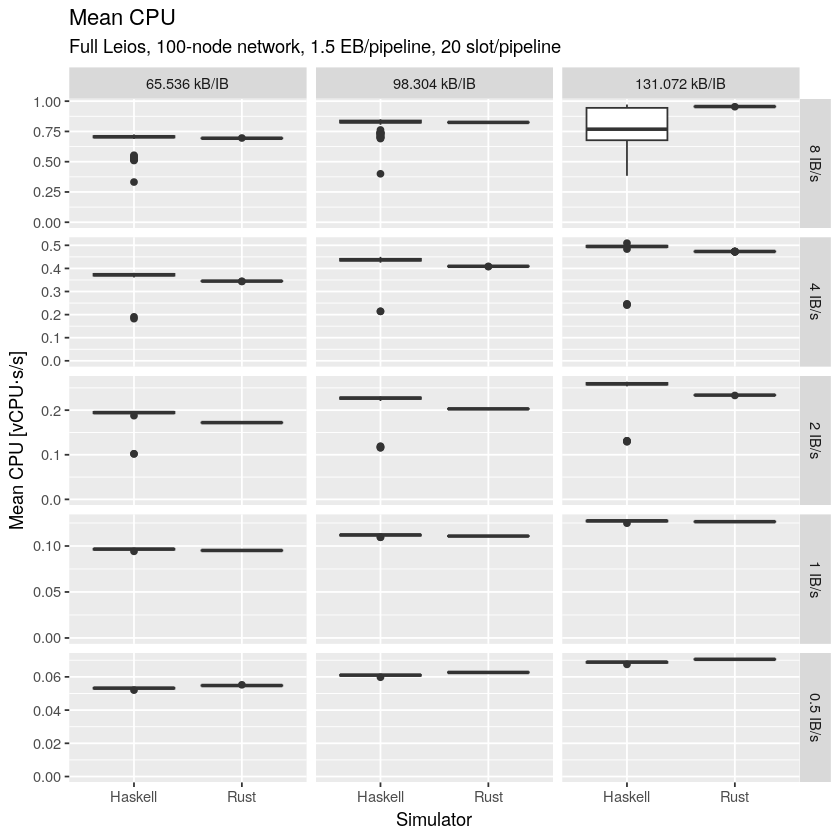

In [19]:
ggplot(
    resources[
        `eb-generation-probability` == 1.5 & `leios-stage-length-slots` == 20,
        .(
            `Simulator`=str_to_title(`simulator`),
            `node`,
            `ib-generation-probability`=factor(paste(`ib-generation-probability`,"IB/s"),levels=c("0.5 IB/s","1 IB/s","2 IB/s","4 IB/s","8 IB/s","16 IB/s")%>%rev),
            `ib-body-avg-size-bytes`=factor(paste(`ib-body-avg-size-bytes`/1000,"kB/IB"),levels=c("65.536 kB/IB", "98.304 kB/IB", "131.072 kB/IB")),
            `Mean CPU [vCPU⋅s/s]`=`total_cpu`/600
        )
    ], aes(x=`Simulator`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`ib-generation-probability` ~ `ib-body-avg-size-bytes`, scales="free_y") +
    ggtitle("Mean CPU", subtitle="Full Leios, 100-node network, 1.5 EB/pipeline, 20 slot/pipeline")

In [20]:
ggsave("plots/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

### Receipt of messages

#### Read results

In [21]:
receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
receipts %>% summary

   simulator          label                      network         
 haskell:107620112   full:211349454   100-nodes-4cpus:211349454  
 rust   :103729342                                               
                                                                 
                                                                 
                                                                 
                                                                 
                                                                 
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   :0.500             Min.   : 65536         Min.   :1.50             
 1st Qu.:1.000             1st Qu.: 65536         1st Qu.:1.50             
 Median :2.000             Median : 98304         Median :2.00             
 Mean   :3.642             Mean   : 98125         Mean   :2.01             
 3rd Qu.:8.000             3rd Qu.:131072         3rd Qu.:2.50             
 Max.   :8.000  

In [22]:
# Only analyze the results for Full Leios
receipts <- receipts[`label` == "full"]

#### Compare the distributions of elapsed times

In [23]:
receiptScenario <- receipts[
    order(`simulator`, `label`, `network`, `leios-stage-length-slots`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `eb-generation-probability`)
][
    !is.na(`elapsed`),
    .(`elapsed`),
    .(
        `simulator`,
        `scenario`=paste(`label`, `network`, `leios-stage-length-slots`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `eb-generation-probability`, sep=" | "),
        `kind`
    )
]

In [24]:
options(repr.plot.width=20, repr.plot.height=15)

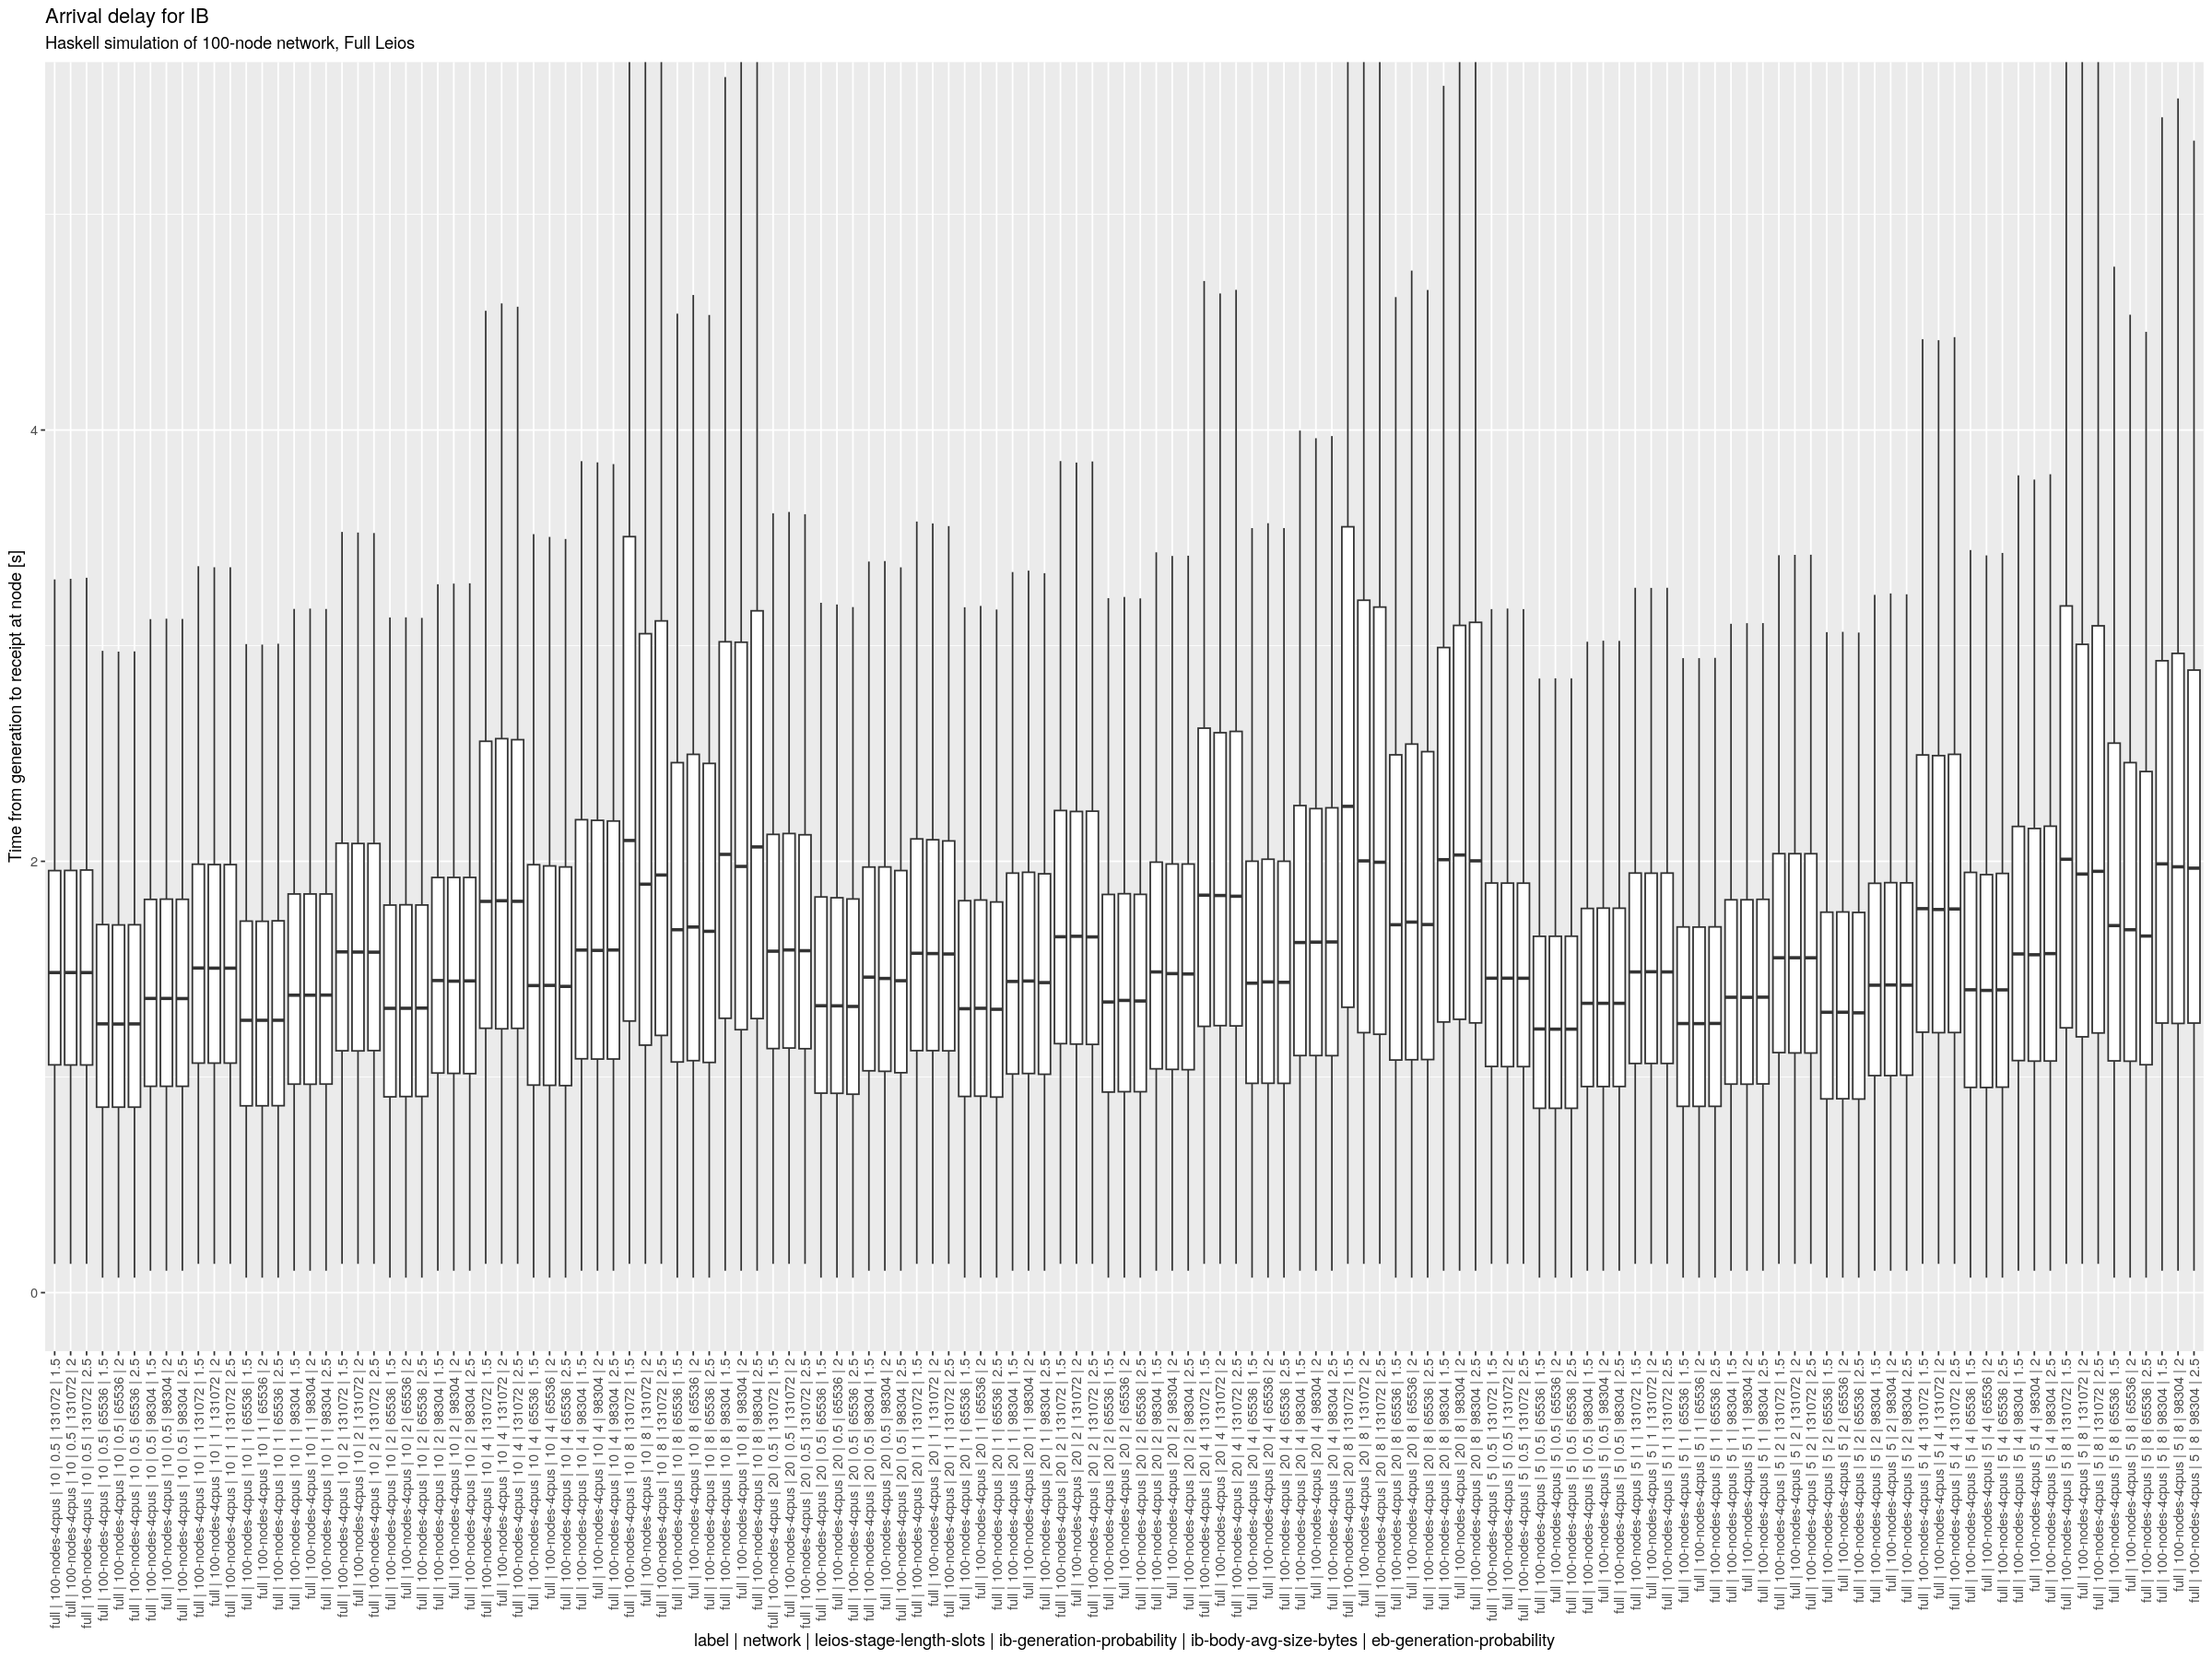

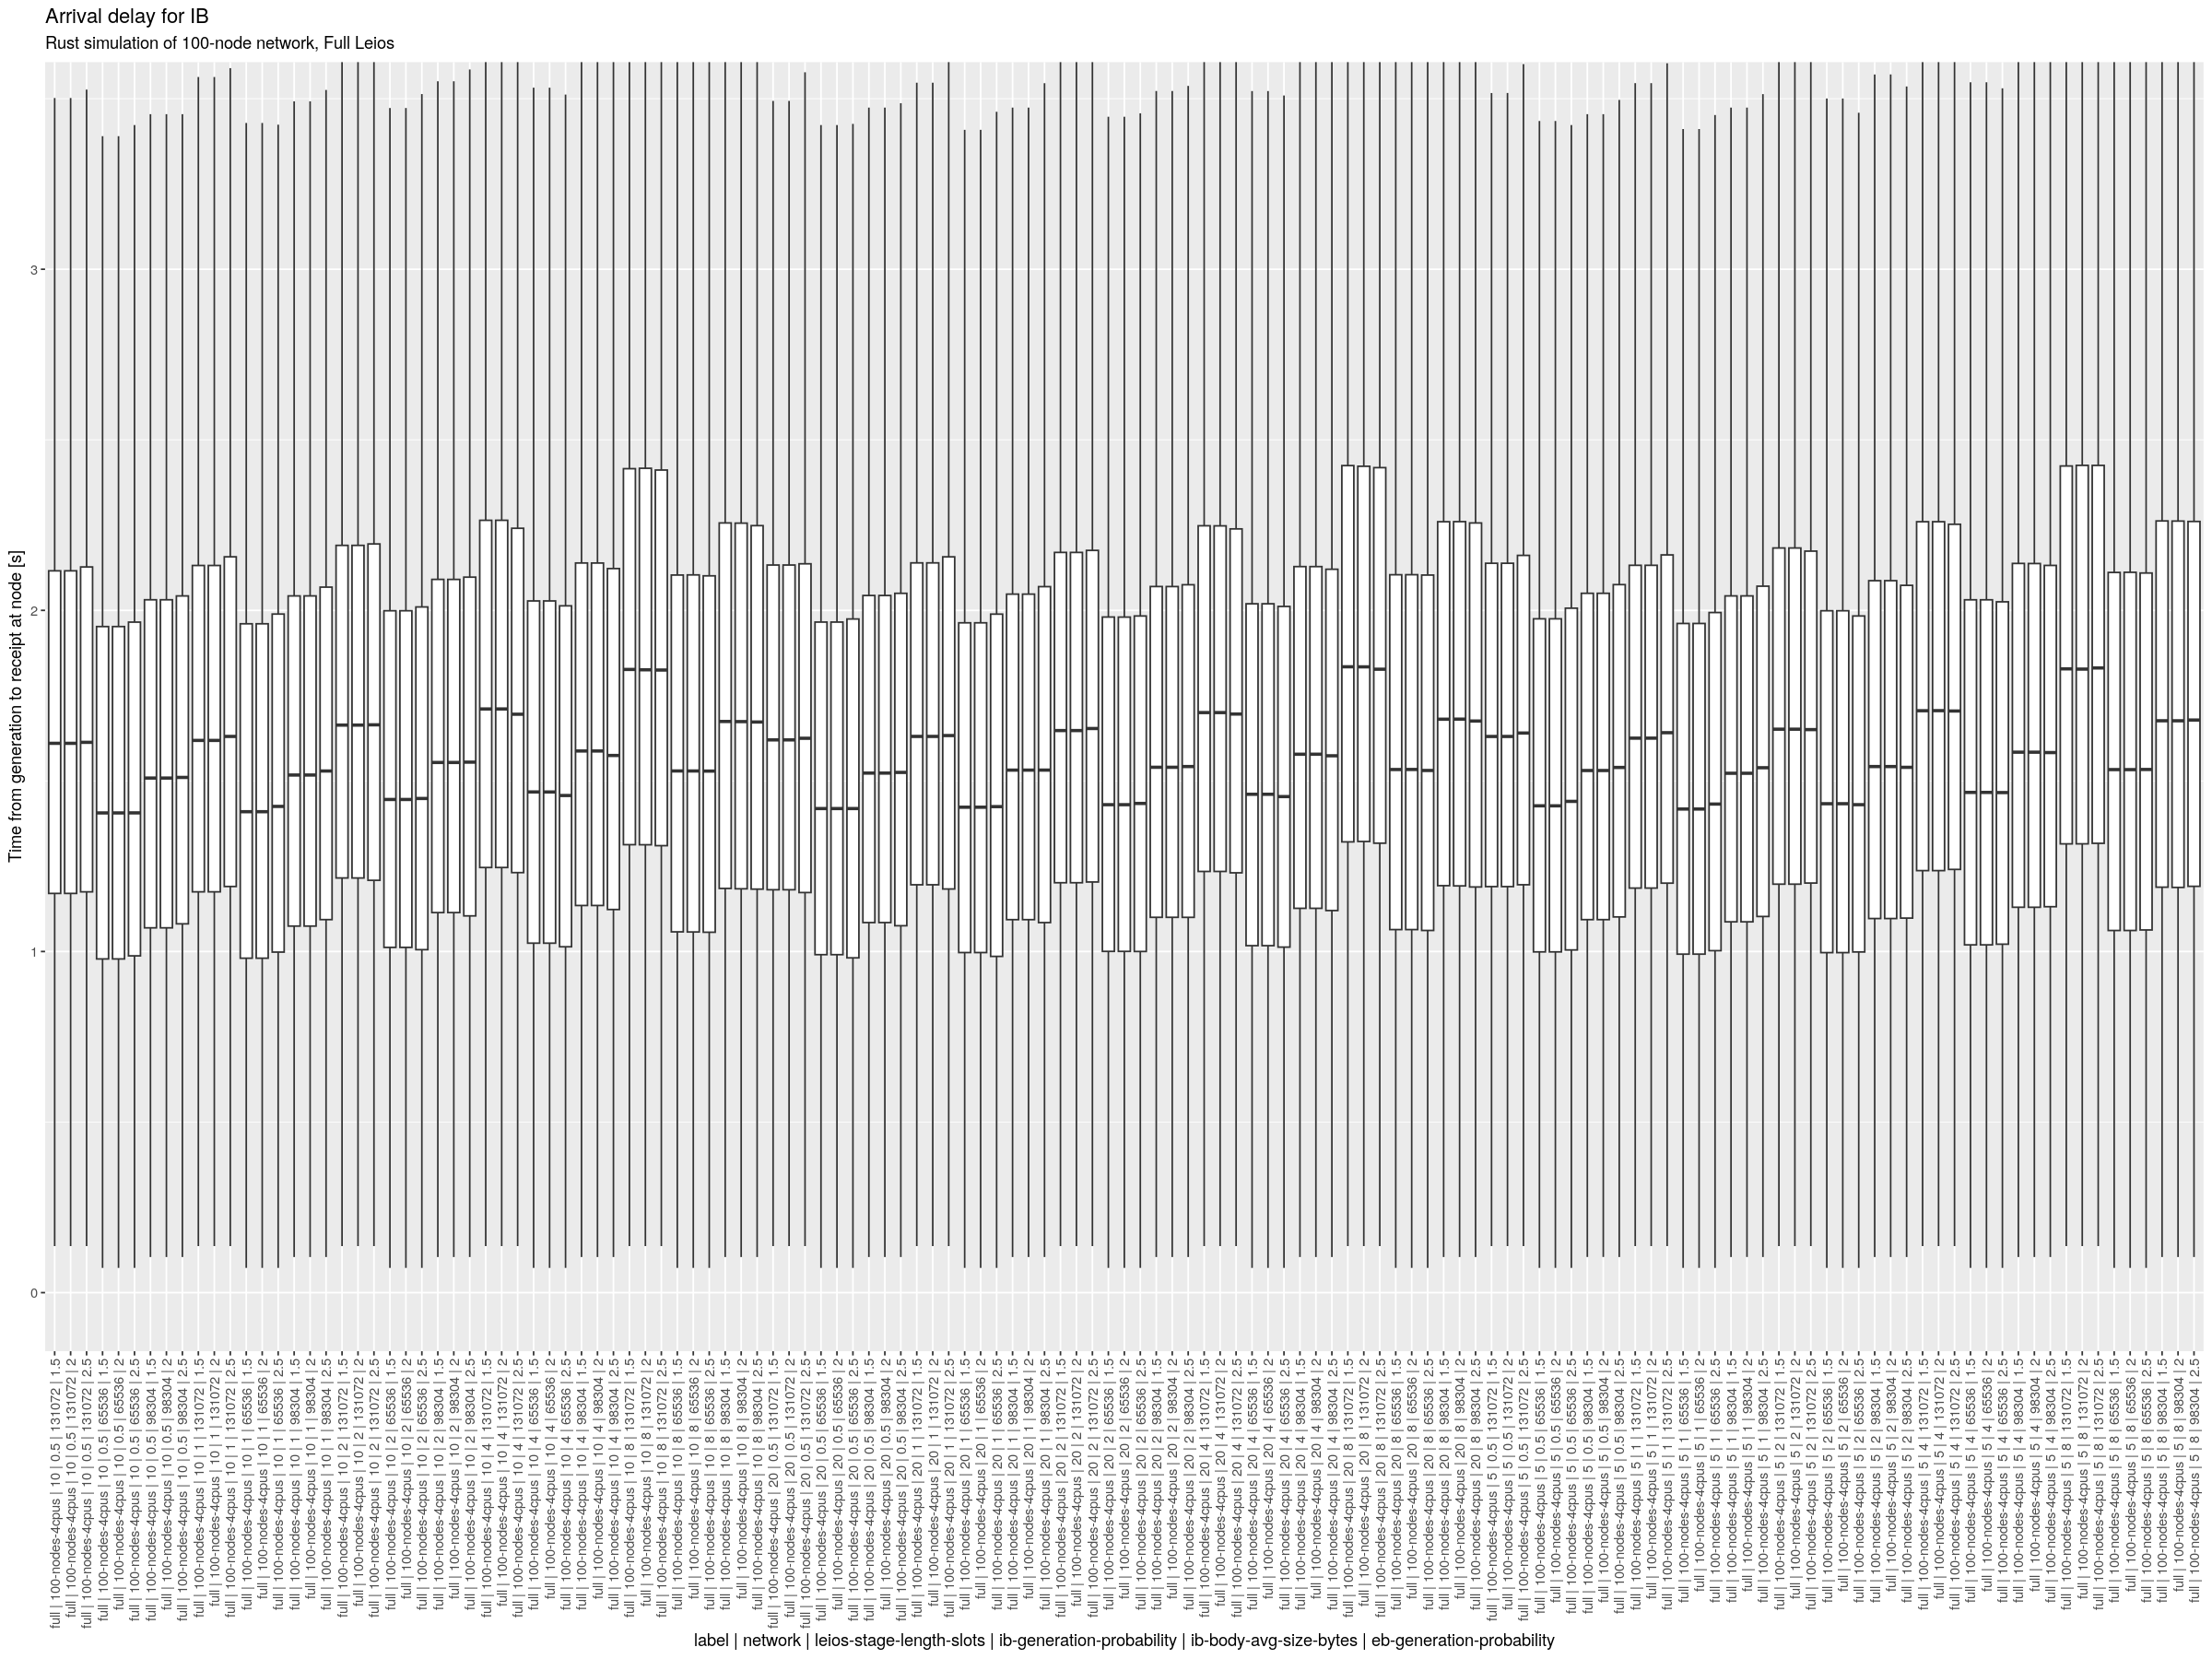

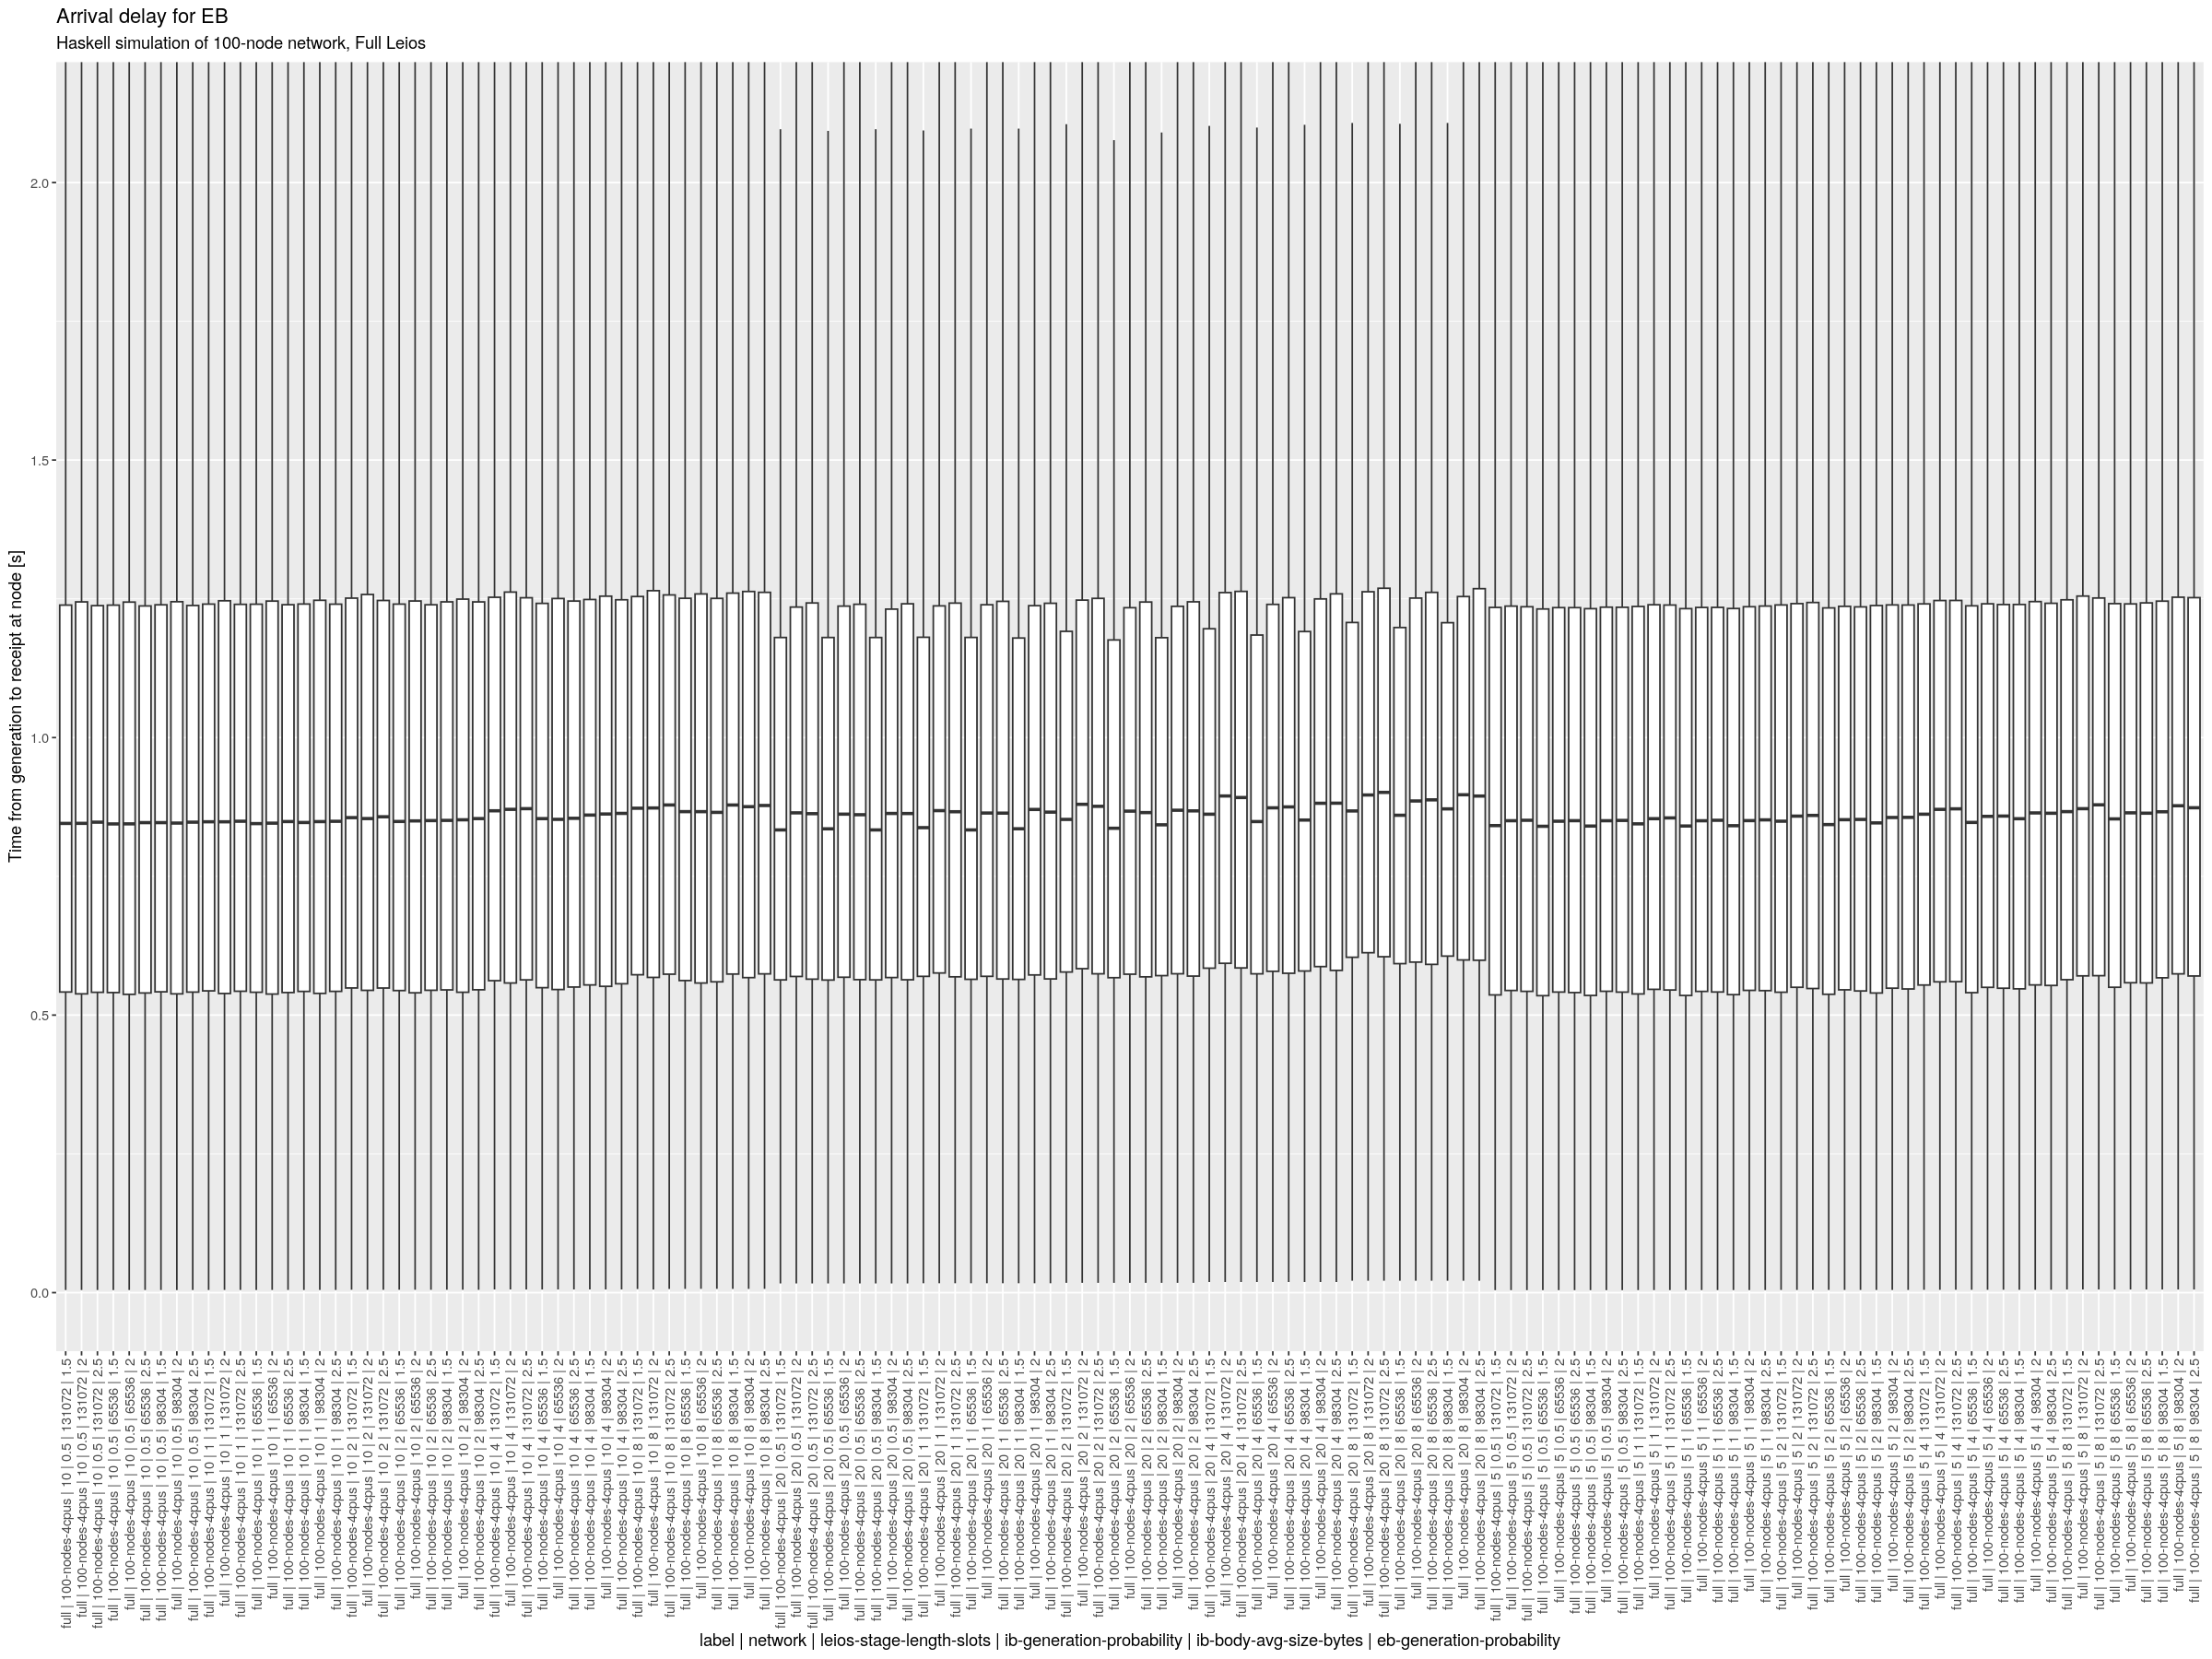

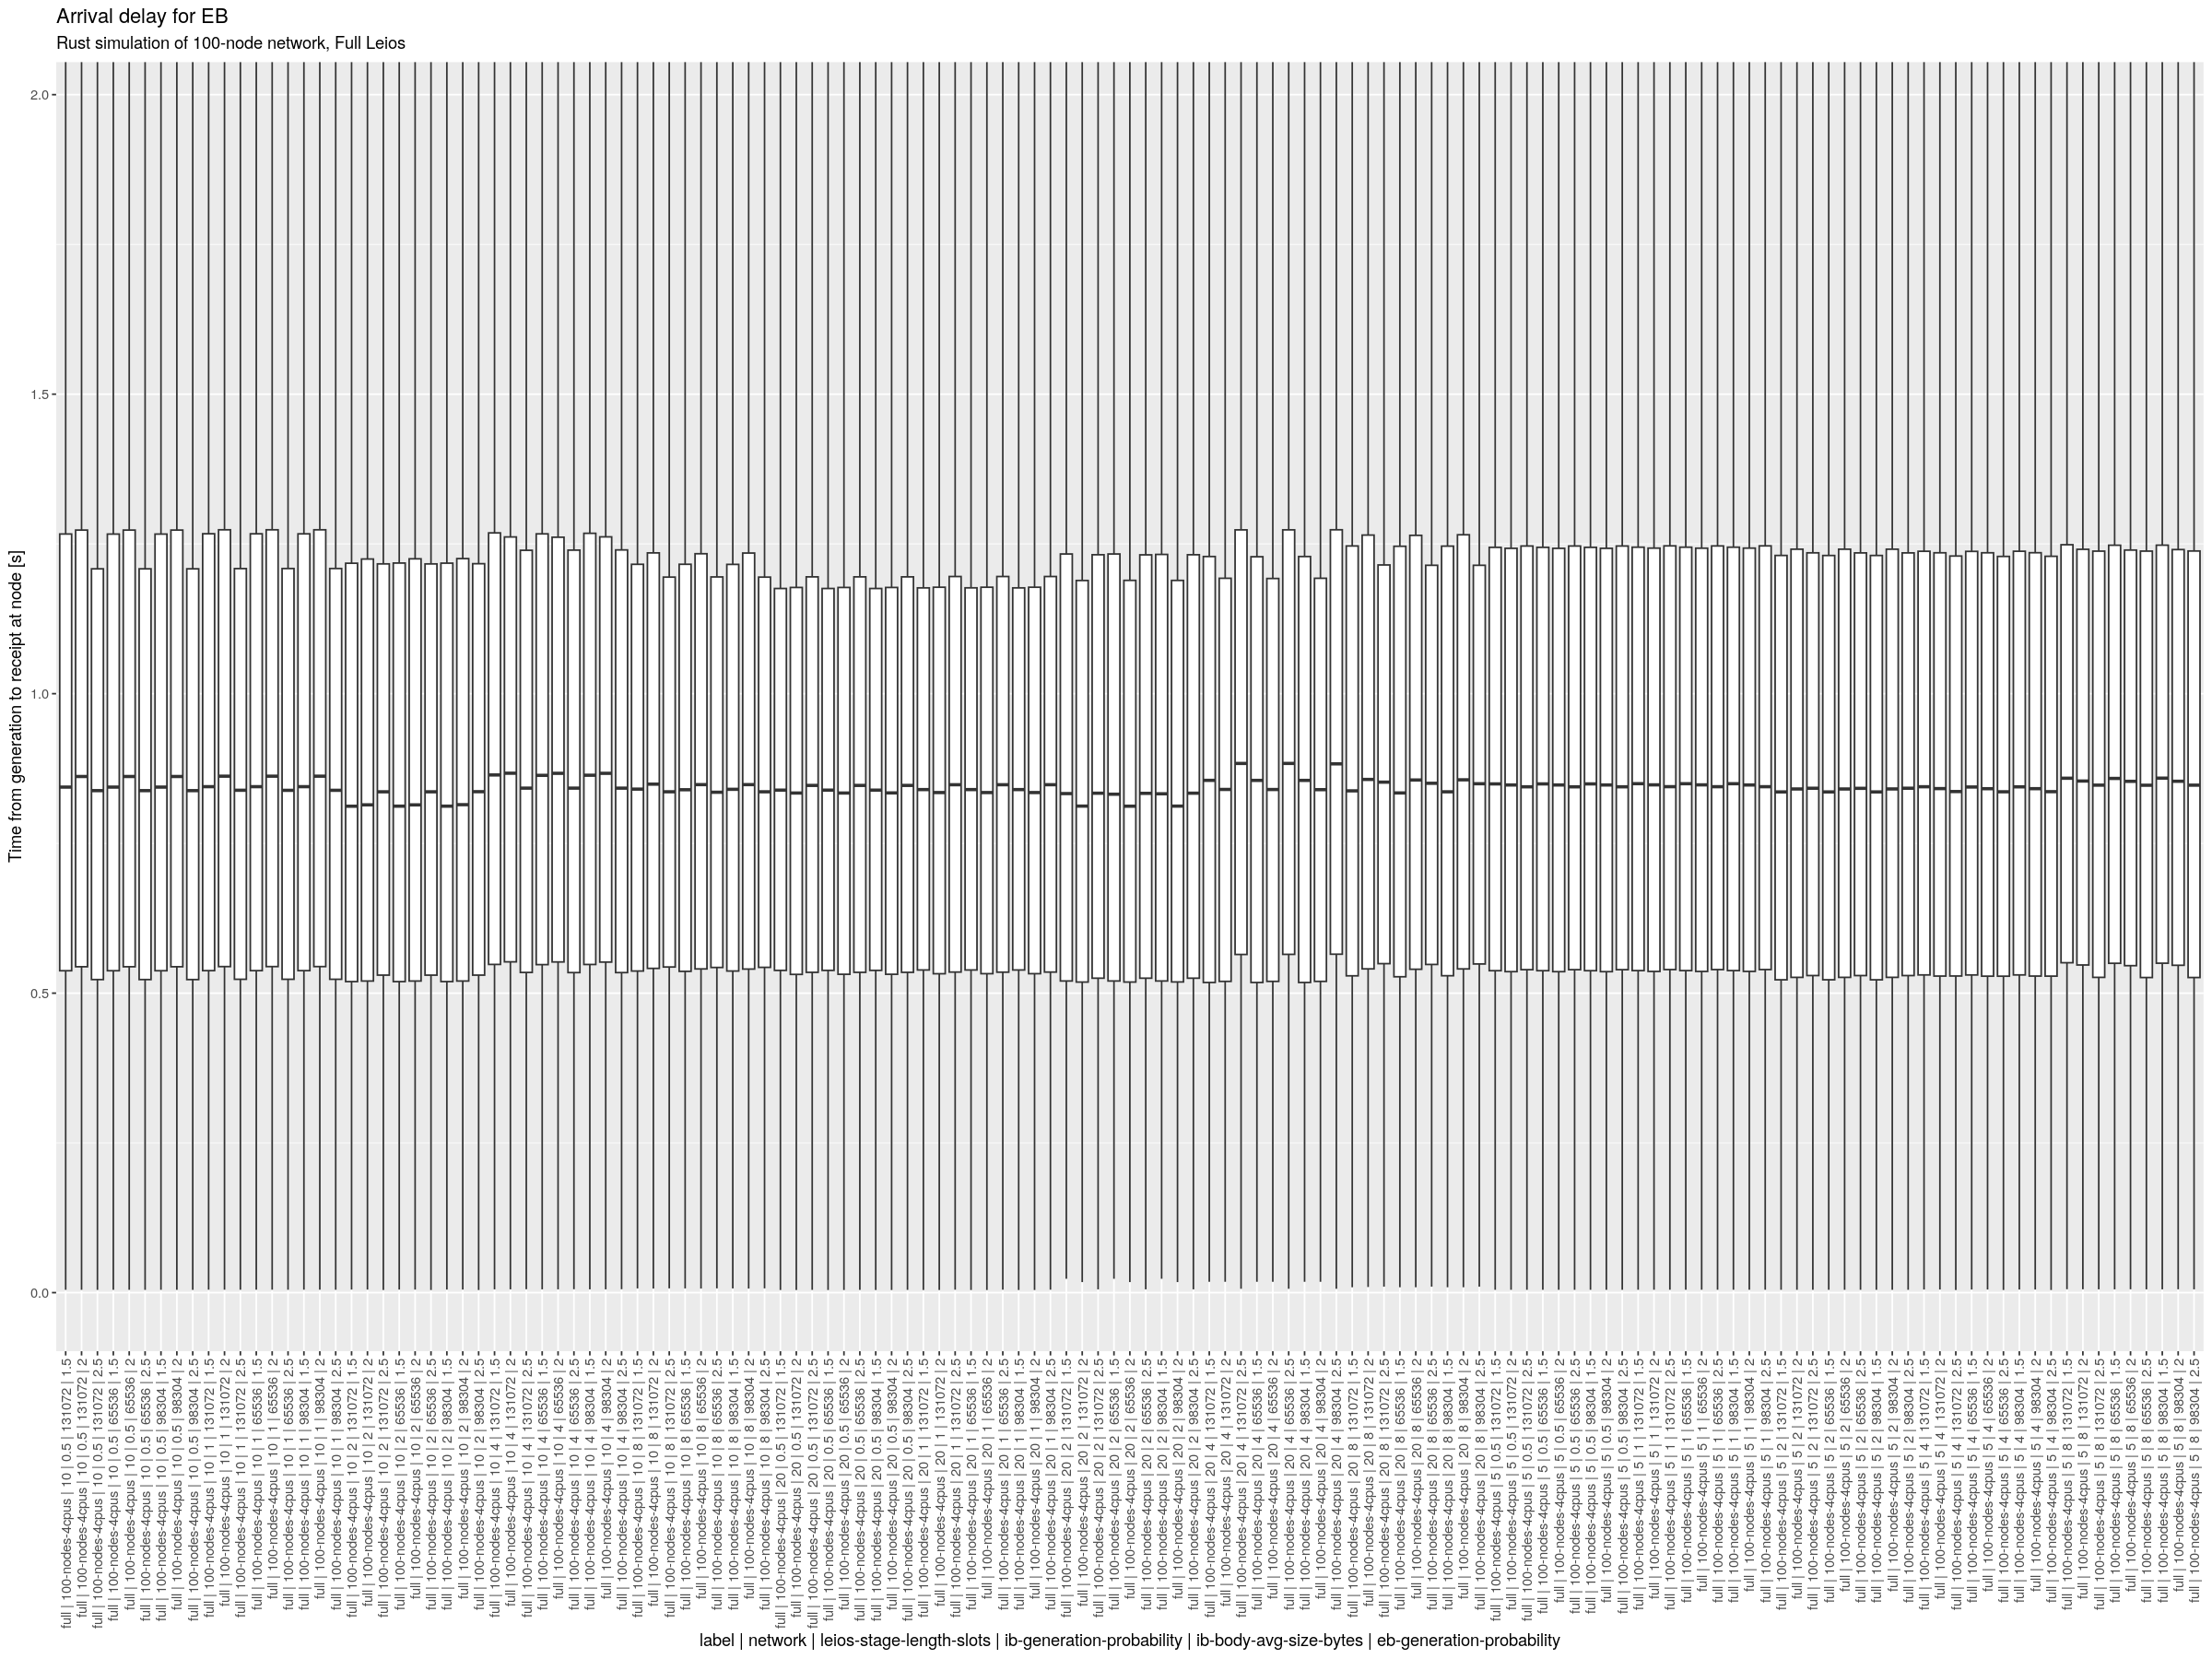

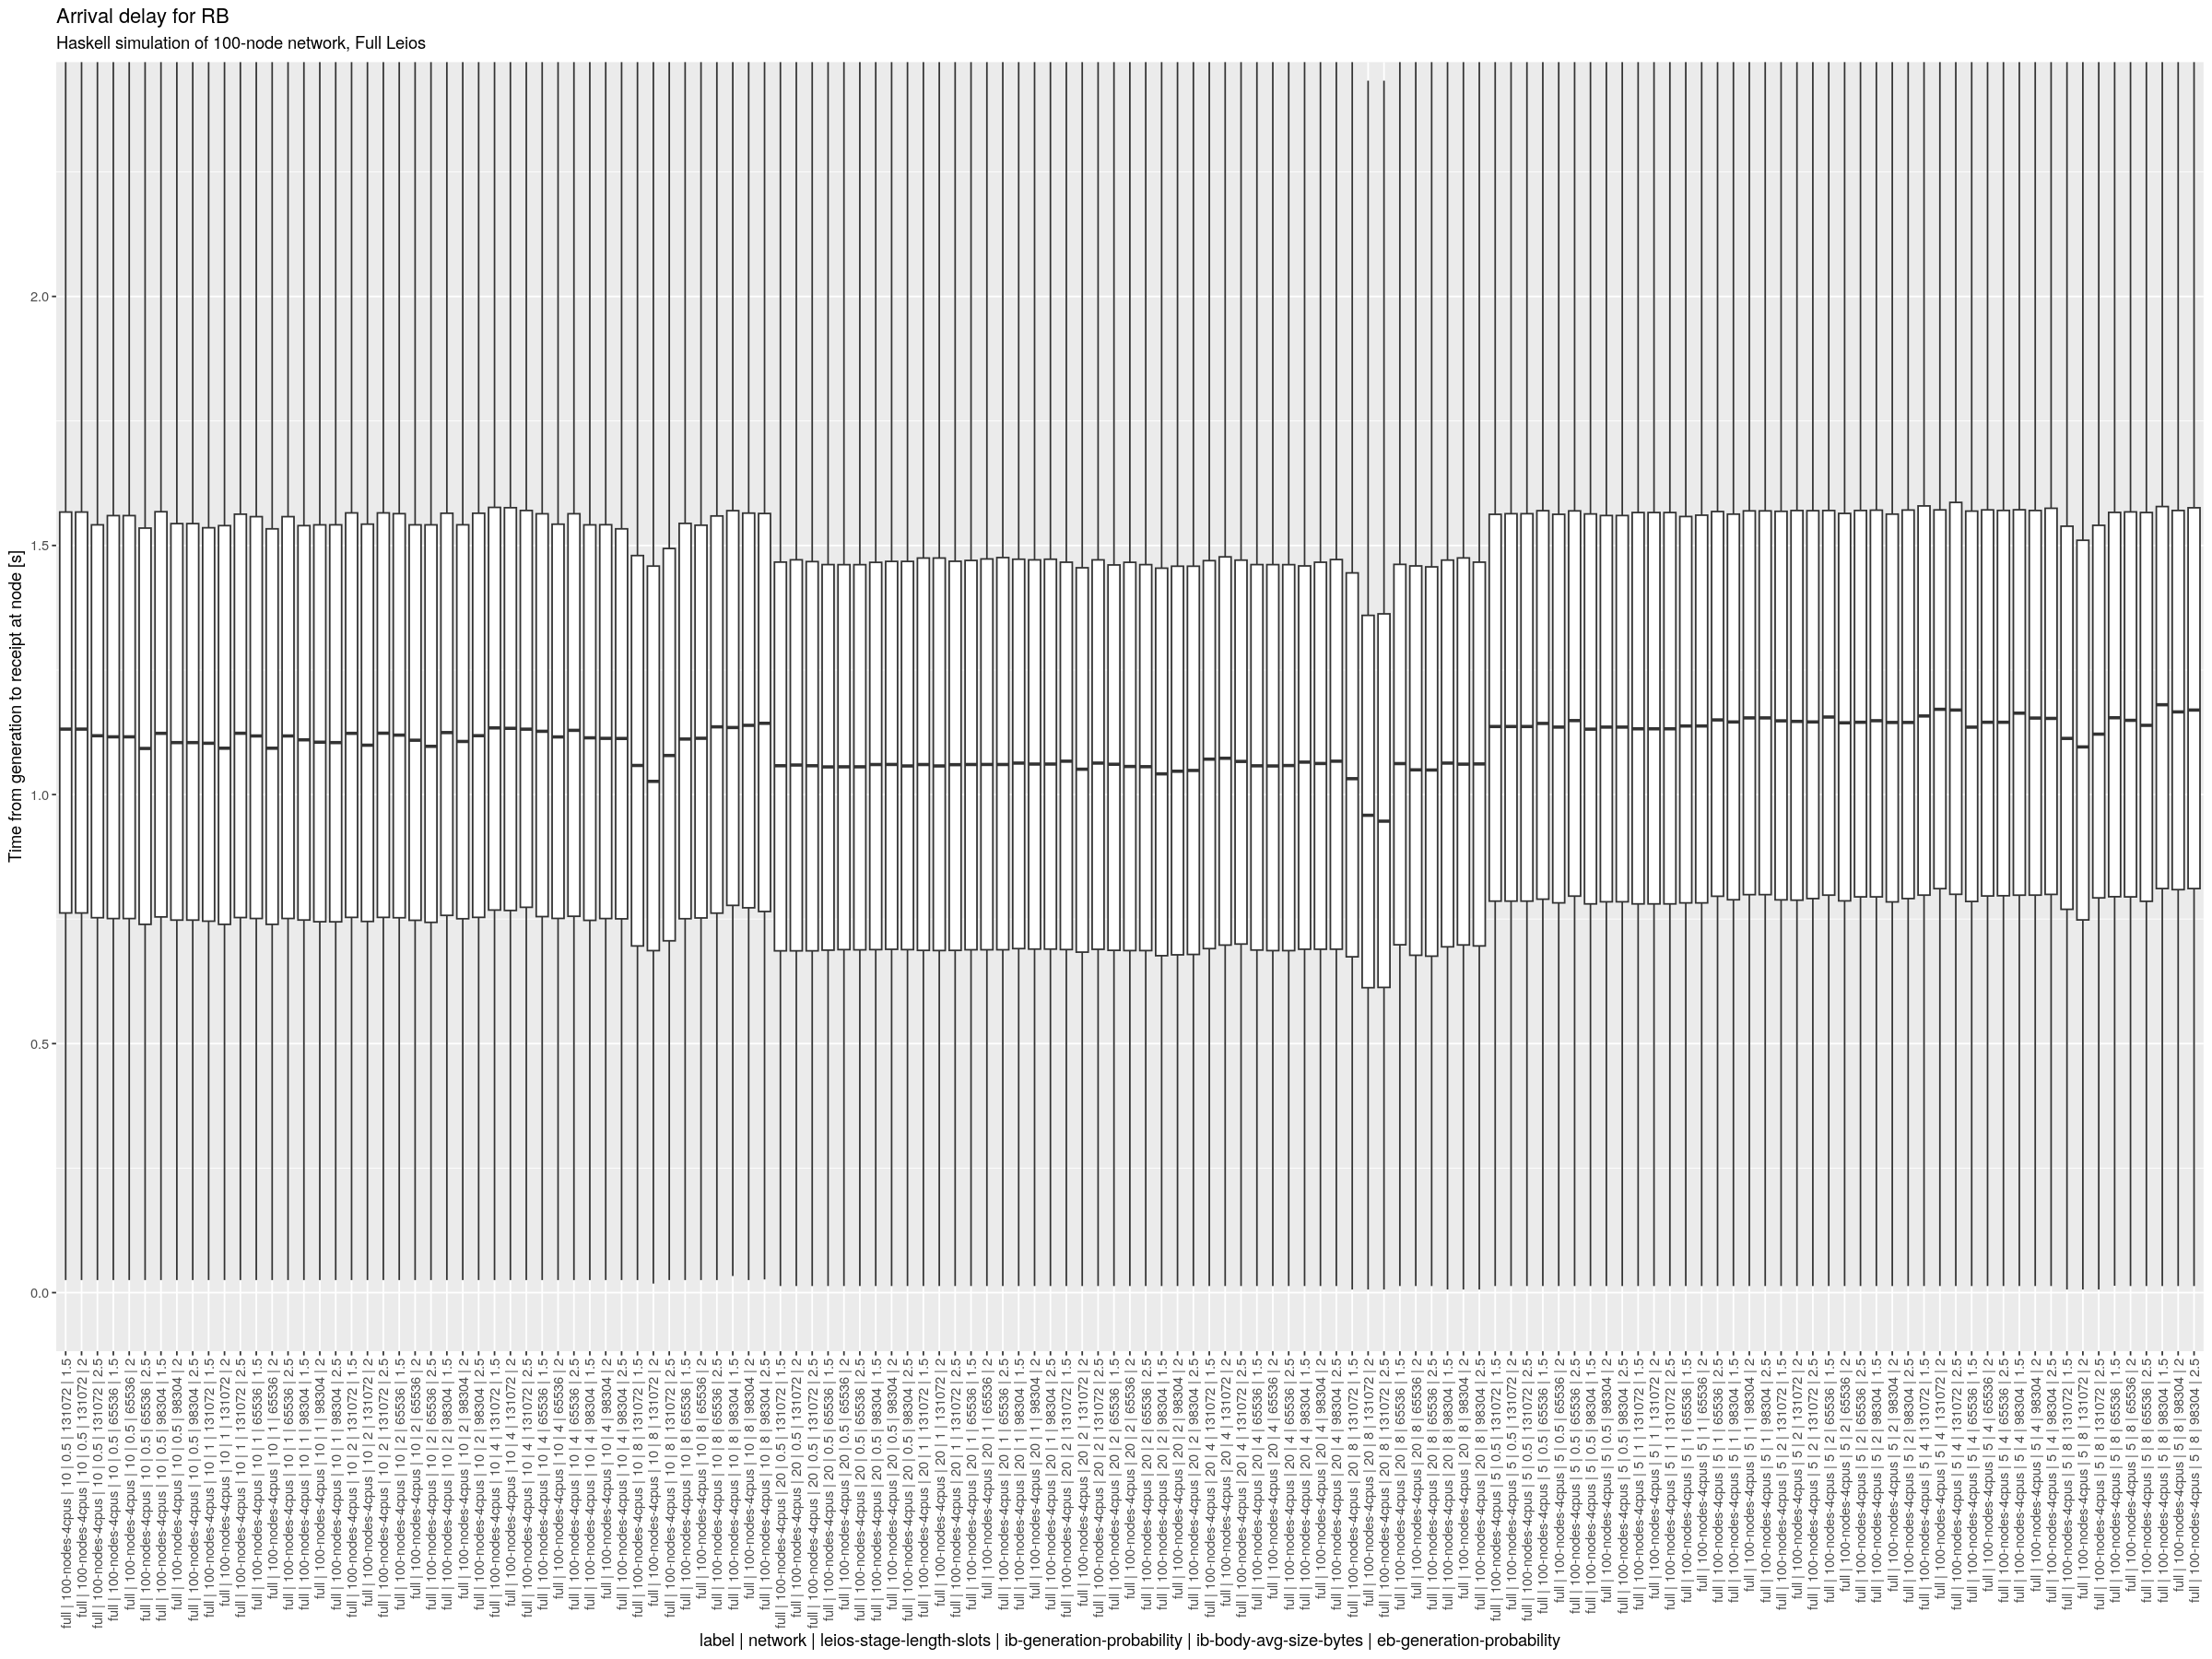

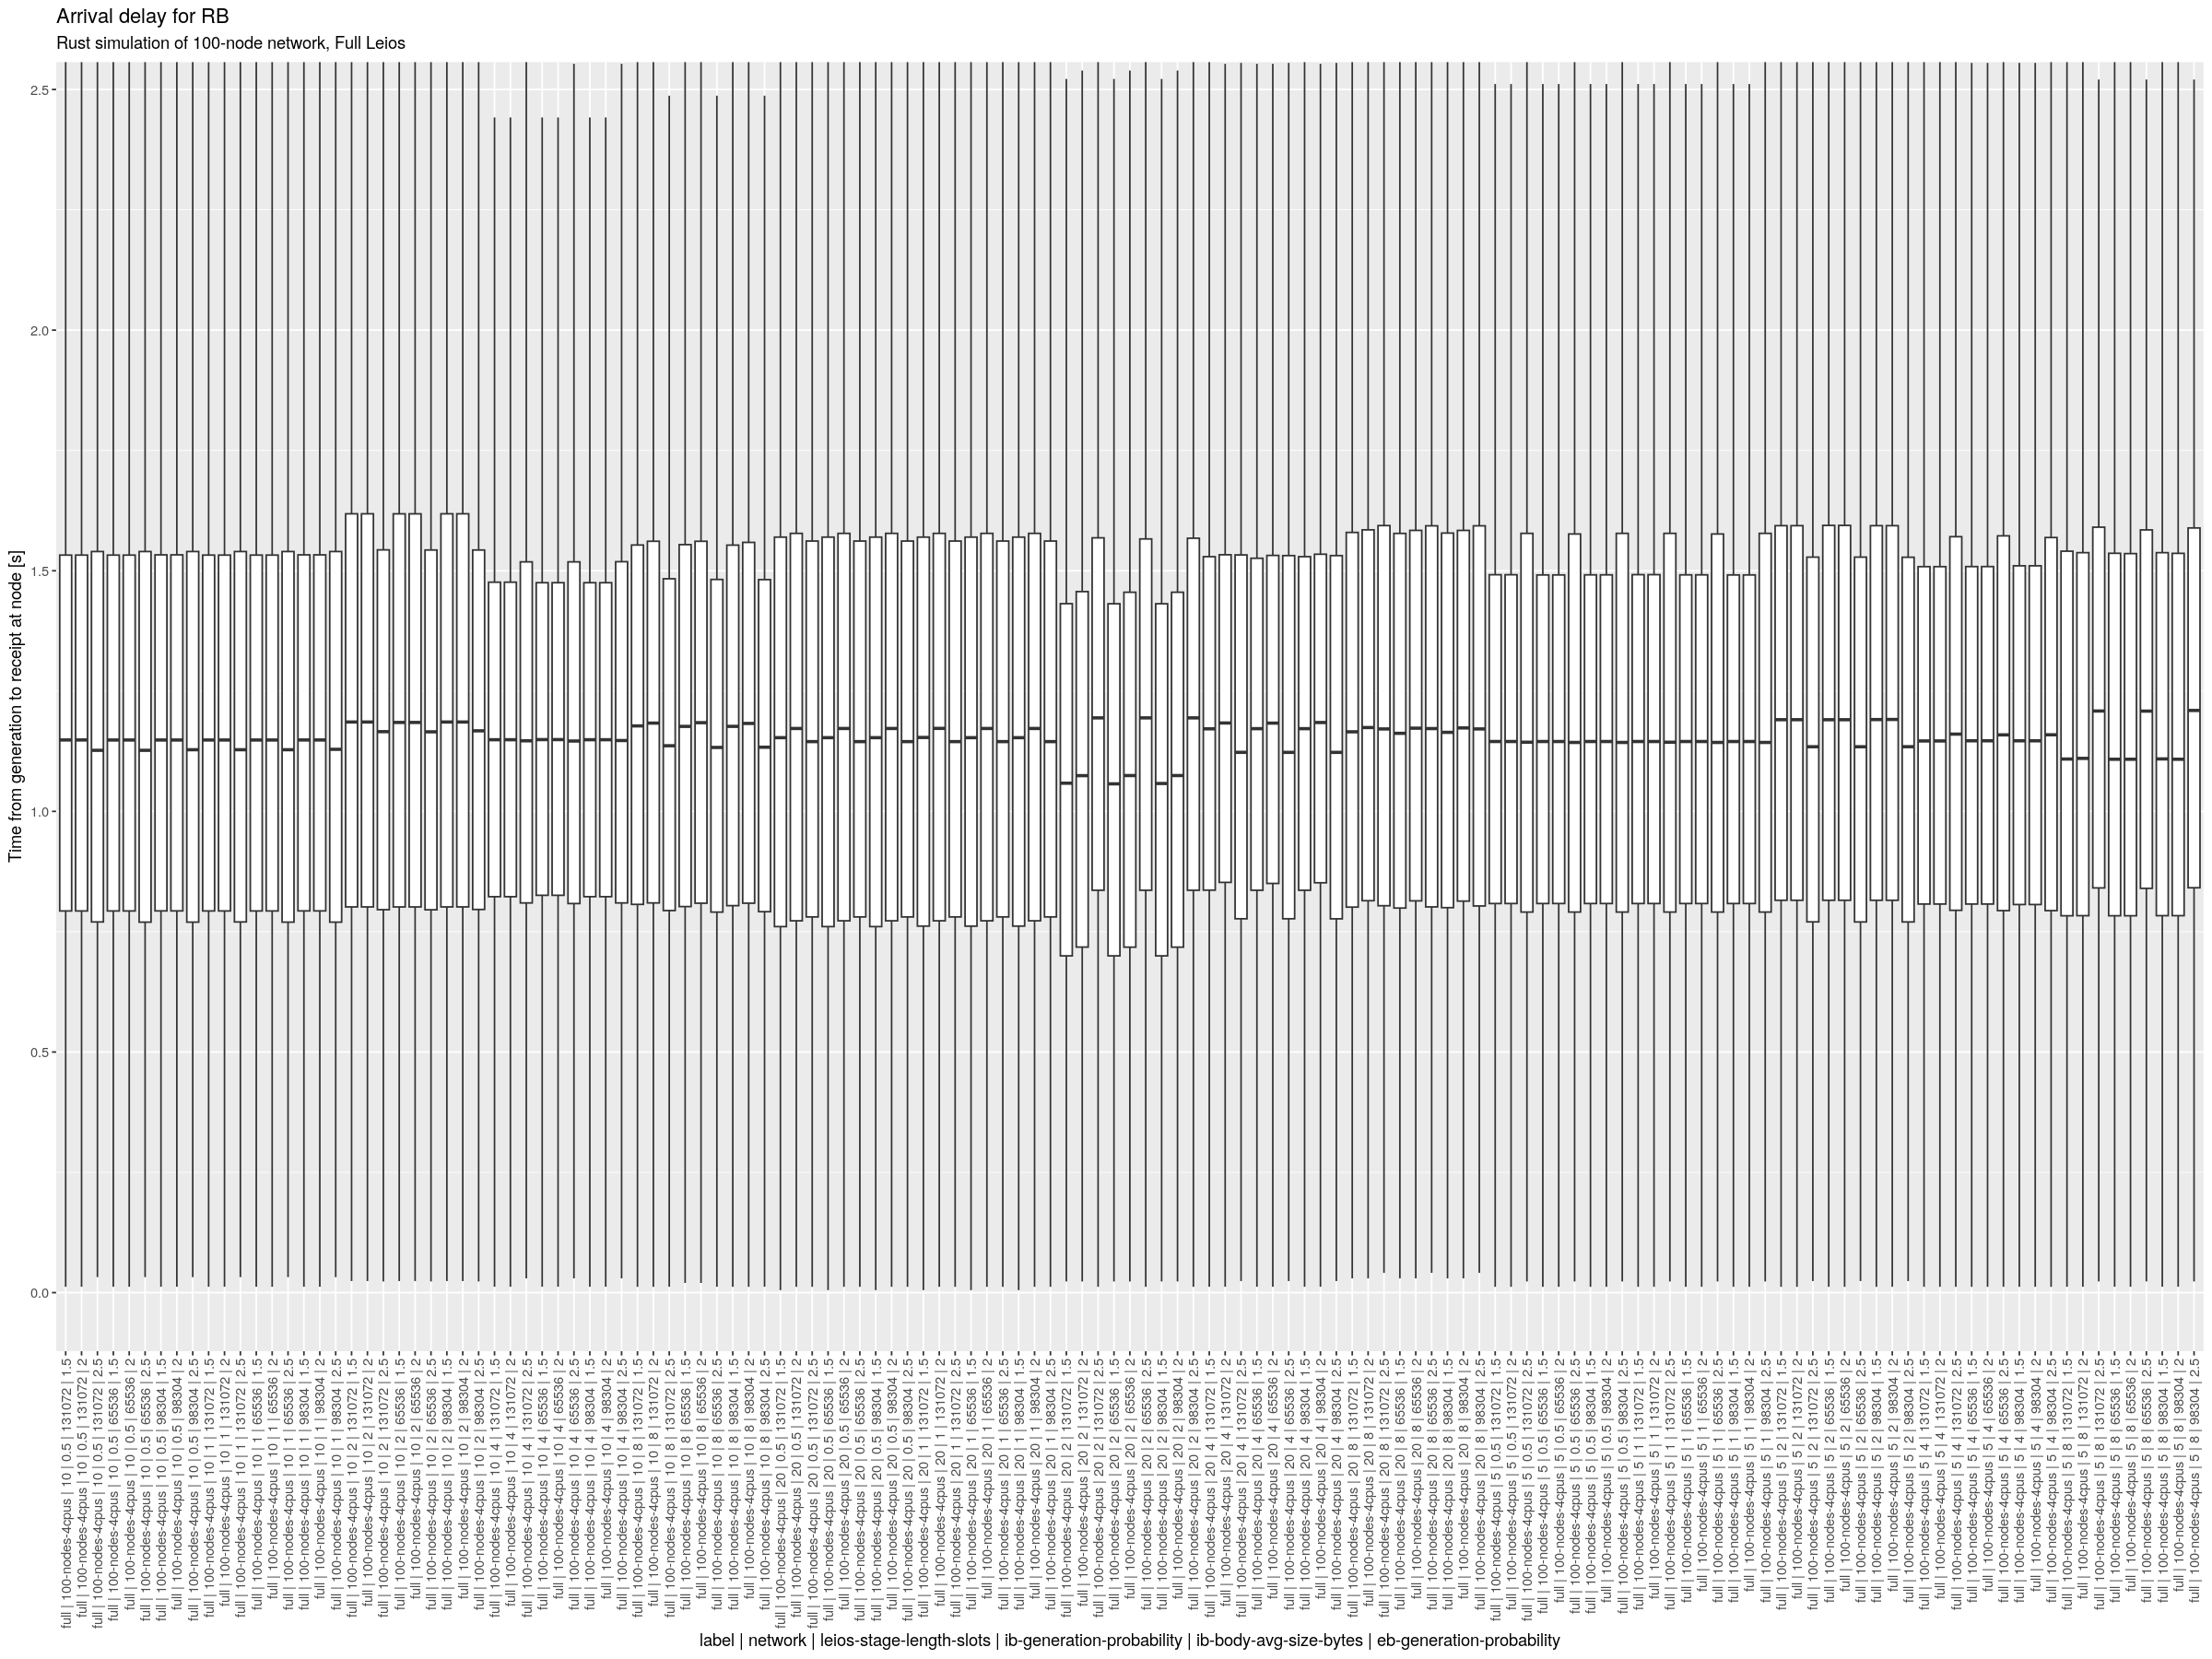

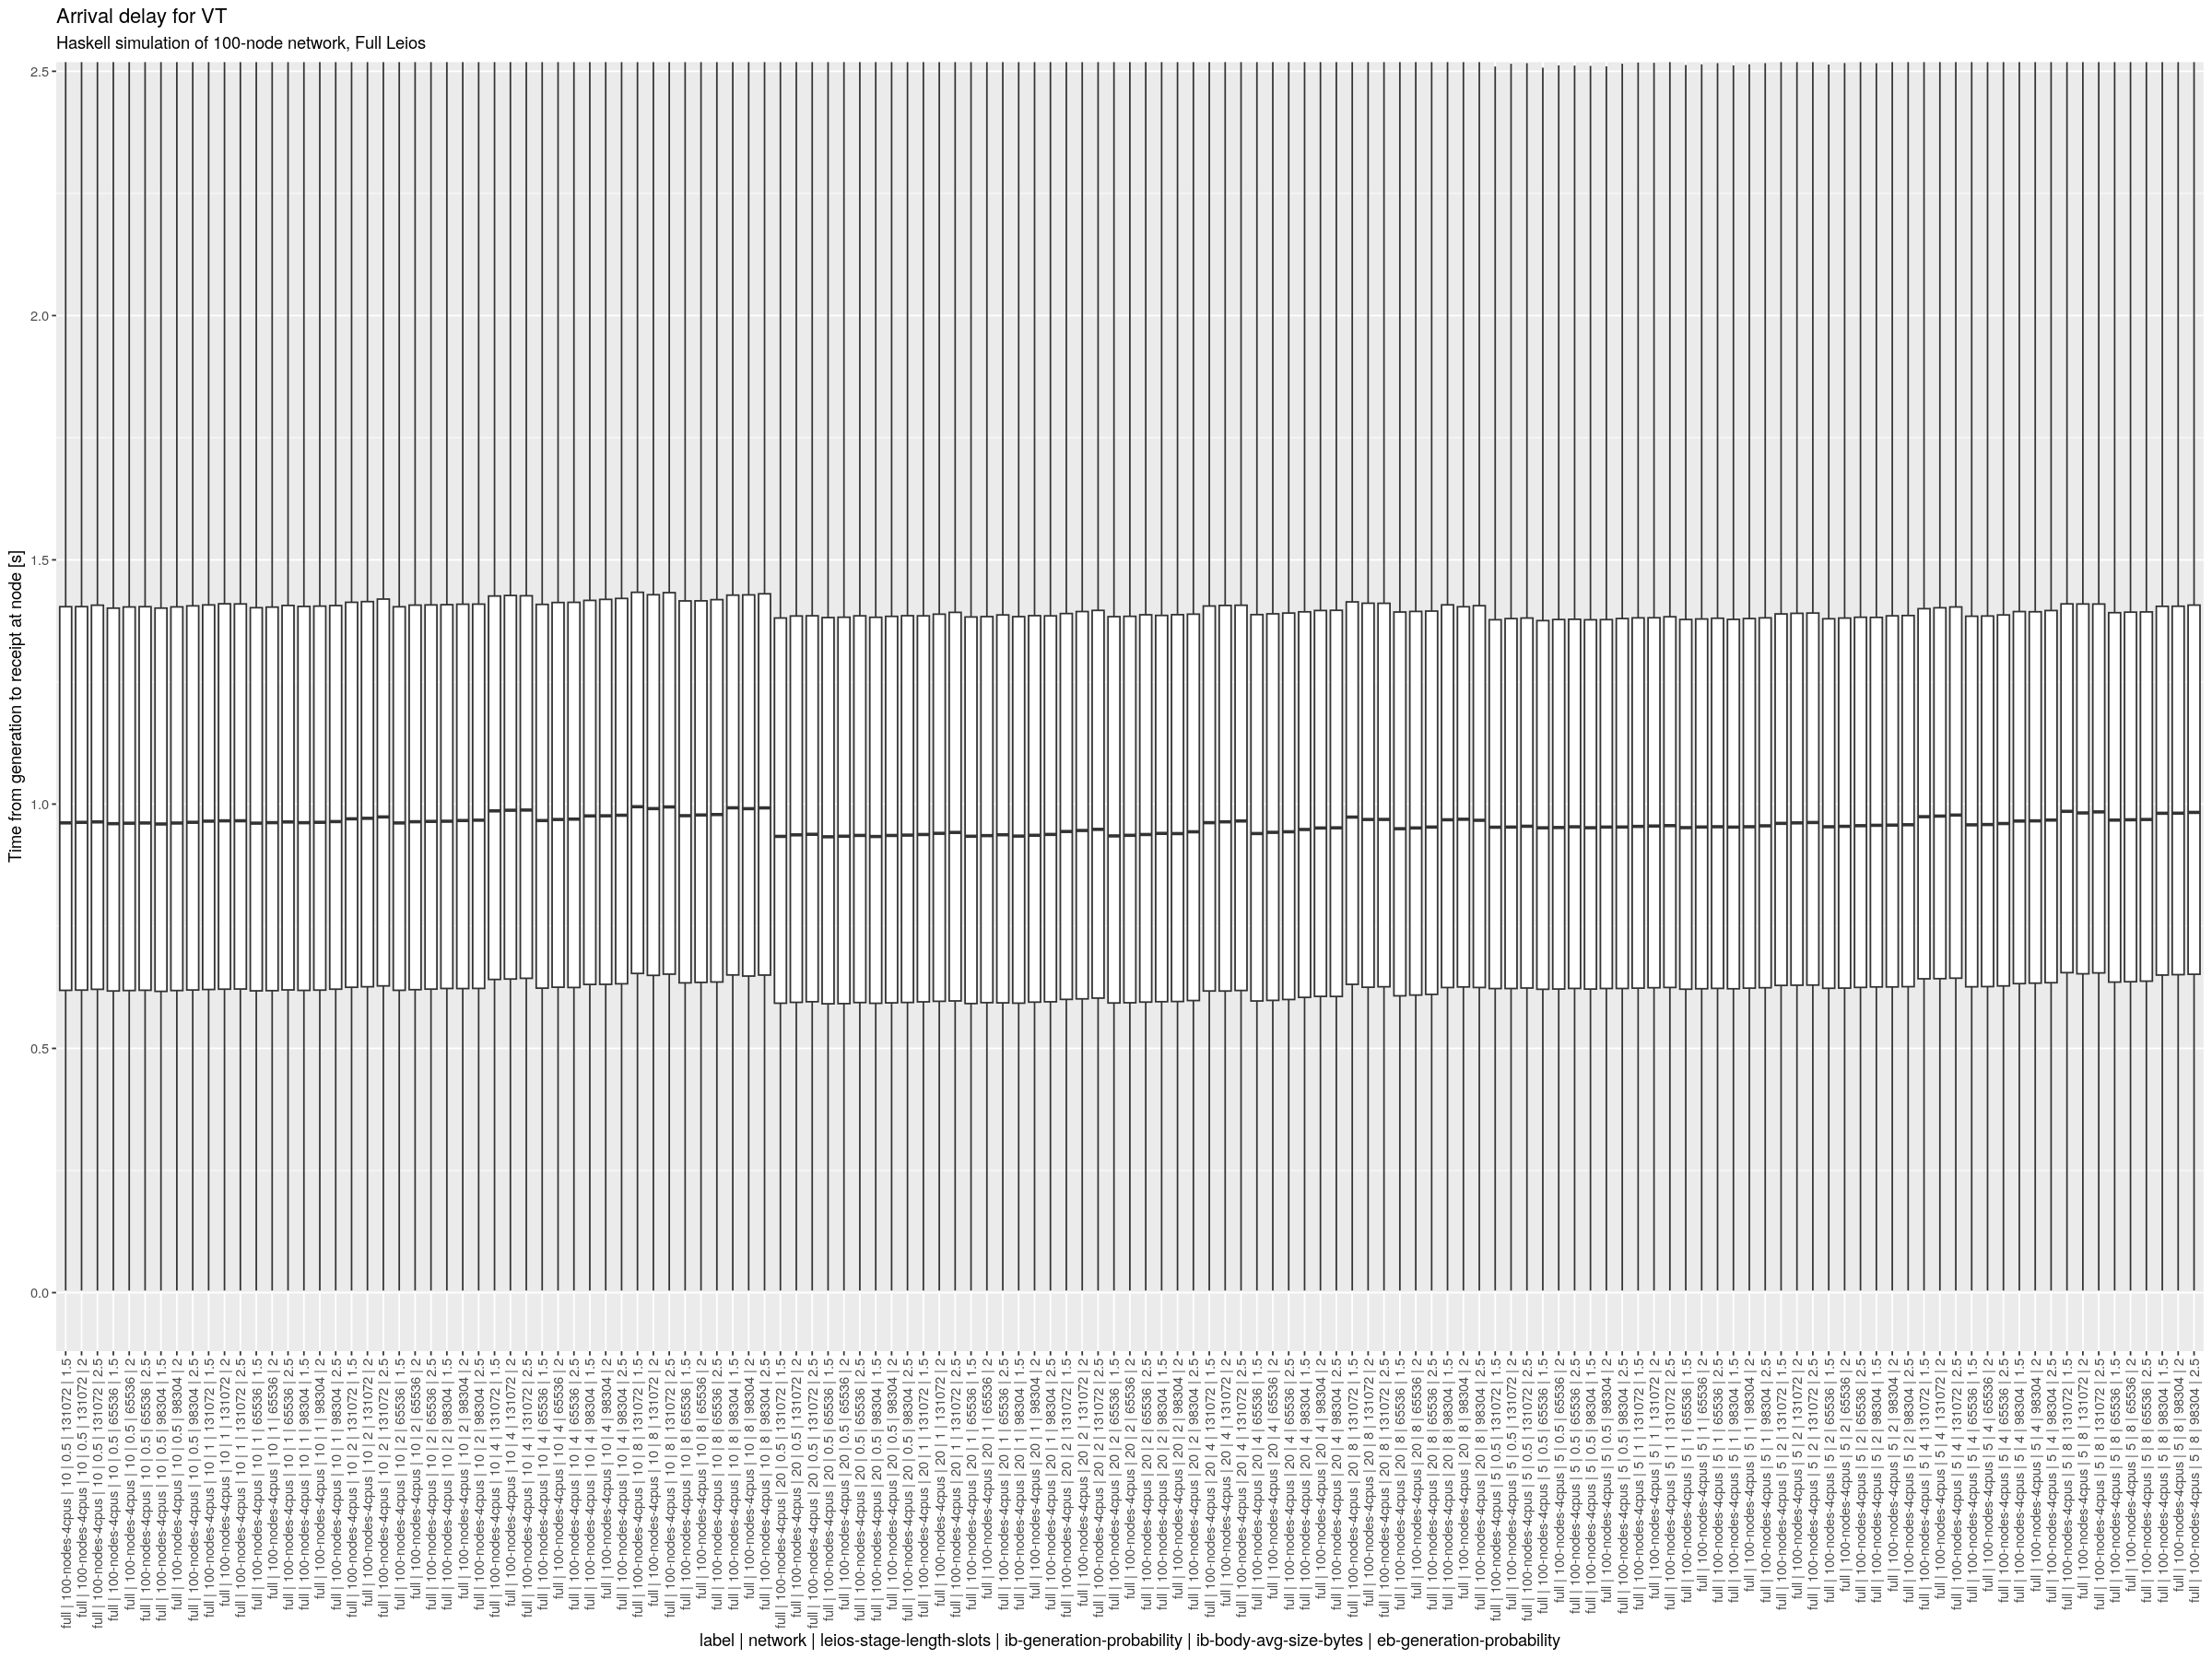

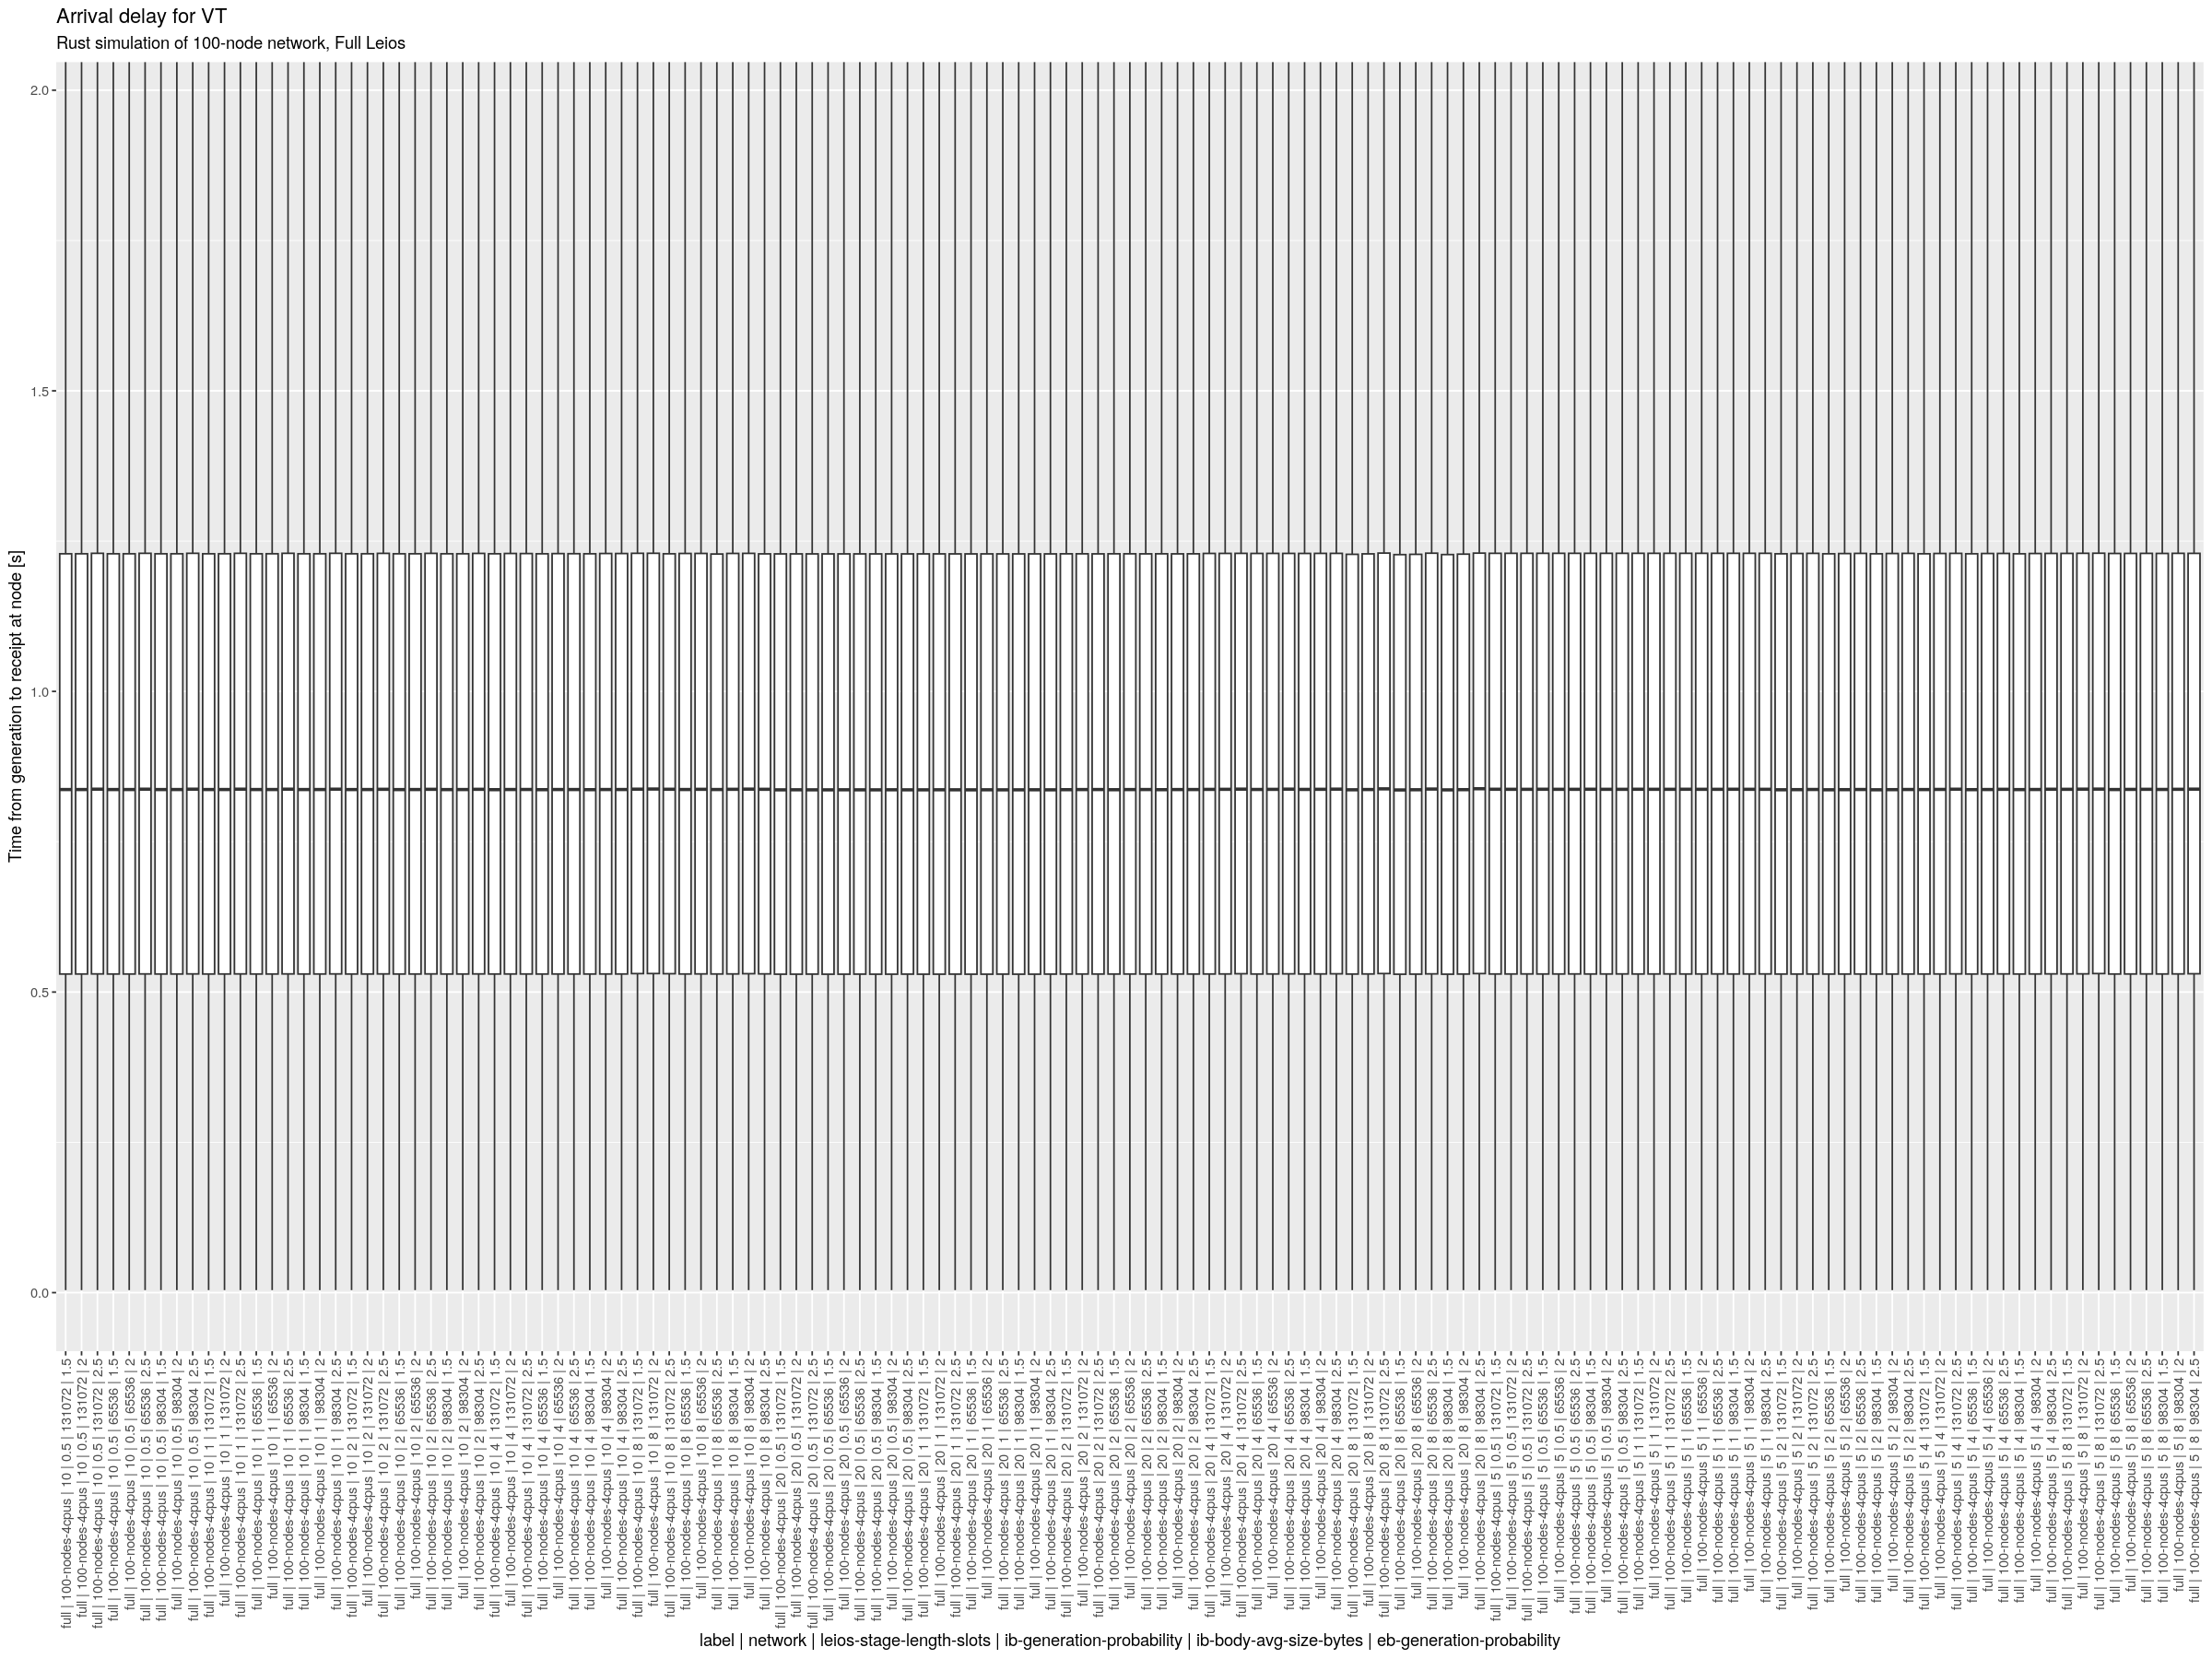

In [25]:
for (k in c("IB", "EB", "RB", "VT")) {
for (s in c("haskell", "rust")) {
    d <- receiptScenario[`simulator` == s & `kind` == k]
    g <- ggplot(d, aes(x=`scenario`, y=`elapsed`)) +
        geom_boxplot(outlier.shape=NA) +
        coord_cartesian(ylim=c(0, d[, quantile(`elapsed`, probs=0.99)])) +
        xlab("label | network | leios-stage-length-slots | ib-generation-probability | ib-body-avg-size-bytes | eb-generation-probability") +
        ylab("Time from generation to receipt at node [s]") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
        ggtitle(paste("Arrival delay for", k), subtitle=paste(s %>% str_to_title, "simulation of 100-node network, Full Leios"))
    print(g)
    ggsave(paste0("plots/elapsed-boxplot-", k, "-", s, ".png"), units="in", width=15, height=6, dpi=150)
}
}

#### Scenarios present in dataset

In [26]:
receipts[, .(`Records`=.N), by=.(`simulator`, `network`, `label`)]

simulator,network,label,Records
<fct>,<fct>,<fct>,<int>
haskell,100-nodes-4cpus,full,107620112
rust,100-nodes-4cpus,full,103729342


In [27]:
# Take one slice for the plotting
receipts <- receipts[
    `network` == "100-nodes-4cpus" &
    `ib-body-avg-size-bytes` == receipts[, quantile(`ib-body-avg-size-bytes`, 0.51) %>% as.numeric] &
    `eb-generation-probability` == receipts[, quantile(`eb-generation-probability`, 0.51) %>% as.numeric] &
    `leios-stage-length-slots` == receipts[, quantile(`leios-stage-length-slots`, 0.51) %>% as.numeric]
]

In [28]:
label <- receipts[, paste0("Full Leios, ", `network`, " network, ", `leios-stage-length-slots`, "-slot stages, ", `ib-body-avg-size-bytes`/1000, " kB/IB, ", `eb-generation-probability`, " EB/pipeline") %>% unique]
label

[1] "Full Leios, 100-nodes-4cpus network, 5-slot stages, 98.304 kB/IB, 2 EB/pipeline"

In [29]:
ibRateLevels <- paste(receipts[, sort(unique(`ib-generation-probability`), decreasing=TRUE)], "IB/s")
ibRateFactor <- function(ibRate) factor(paste(ibRate, "IB/s"), levels=ibRateLevels)
ibRates <- receipts[, unique(`ib-generation-probability`)]
ibRates

[1] 8.0 1.0 4.0 2.0 0.5

In [30]:
kinds <- receipts[, unique(`kind`) %>% sort]
kinds

[1] EB IB RB VT
Levels: EB IB RB VT

In [31]:
options(repr.plot.width=10, repr.plot.height=7)

#### IB rate variations

##### Compare the distributions of elapsed times

In [32]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`simulator`, `ibRate`=mapply(ibRateFactor, `ib-generation-probability`), `elapsed`)],
        aes(x=`elapsed`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 5)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

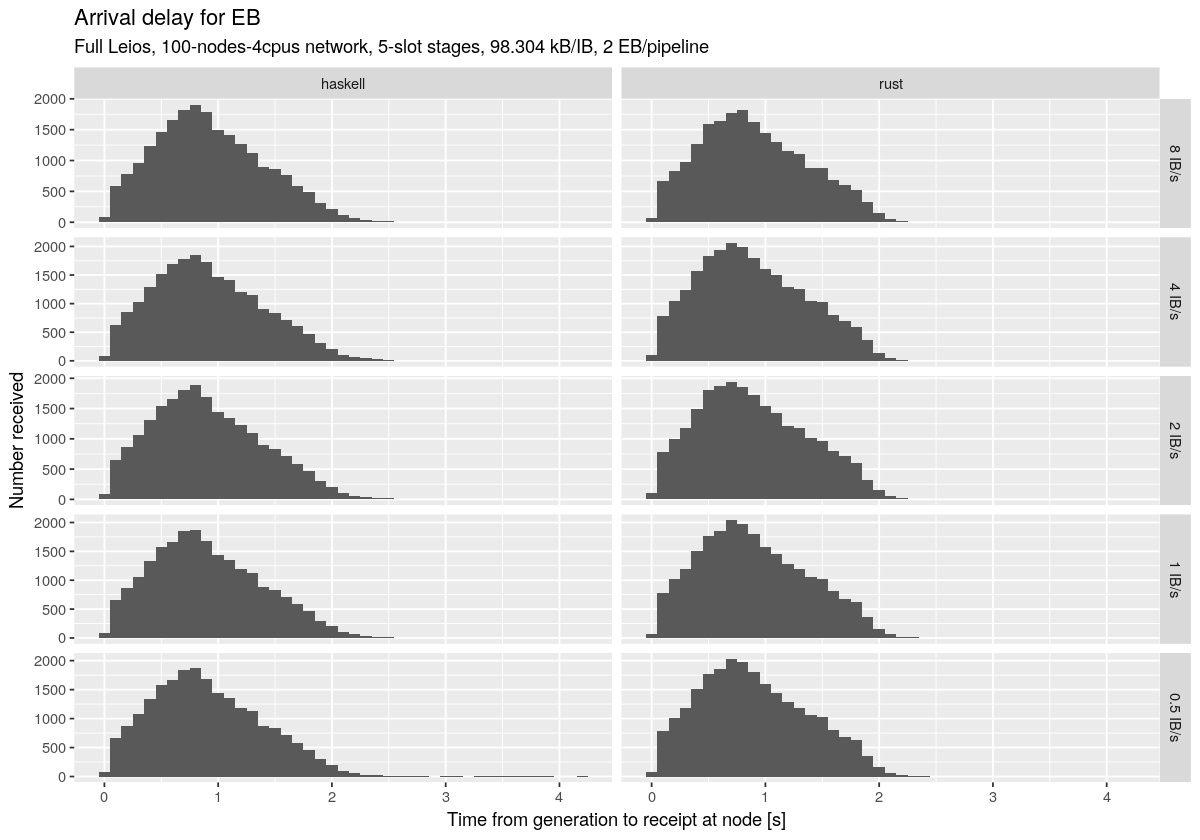

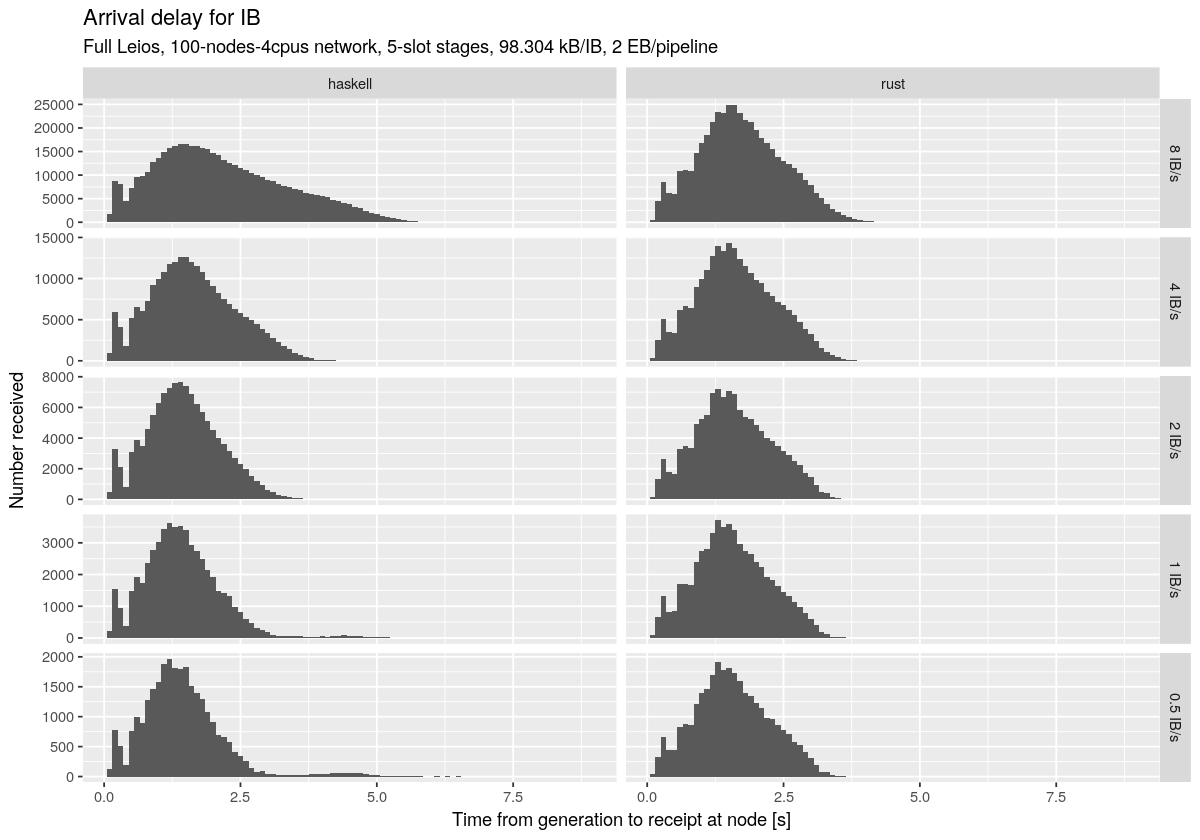

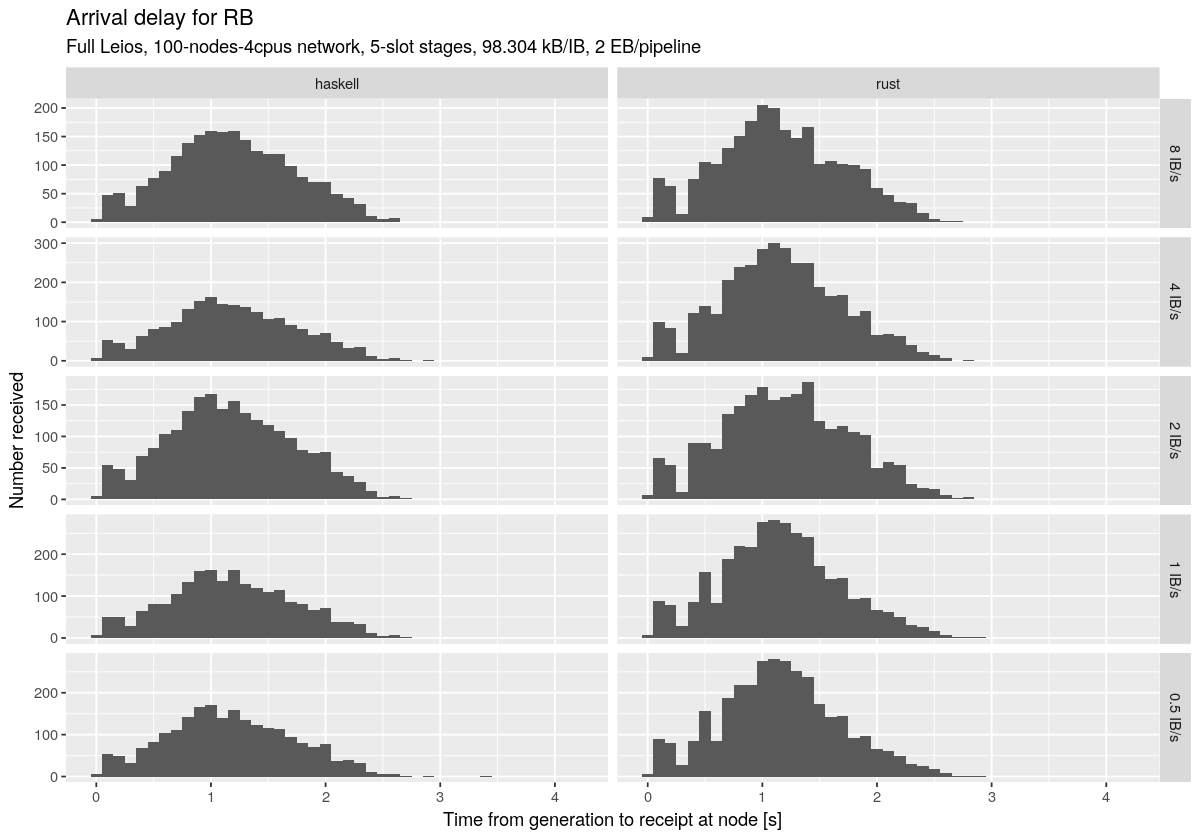

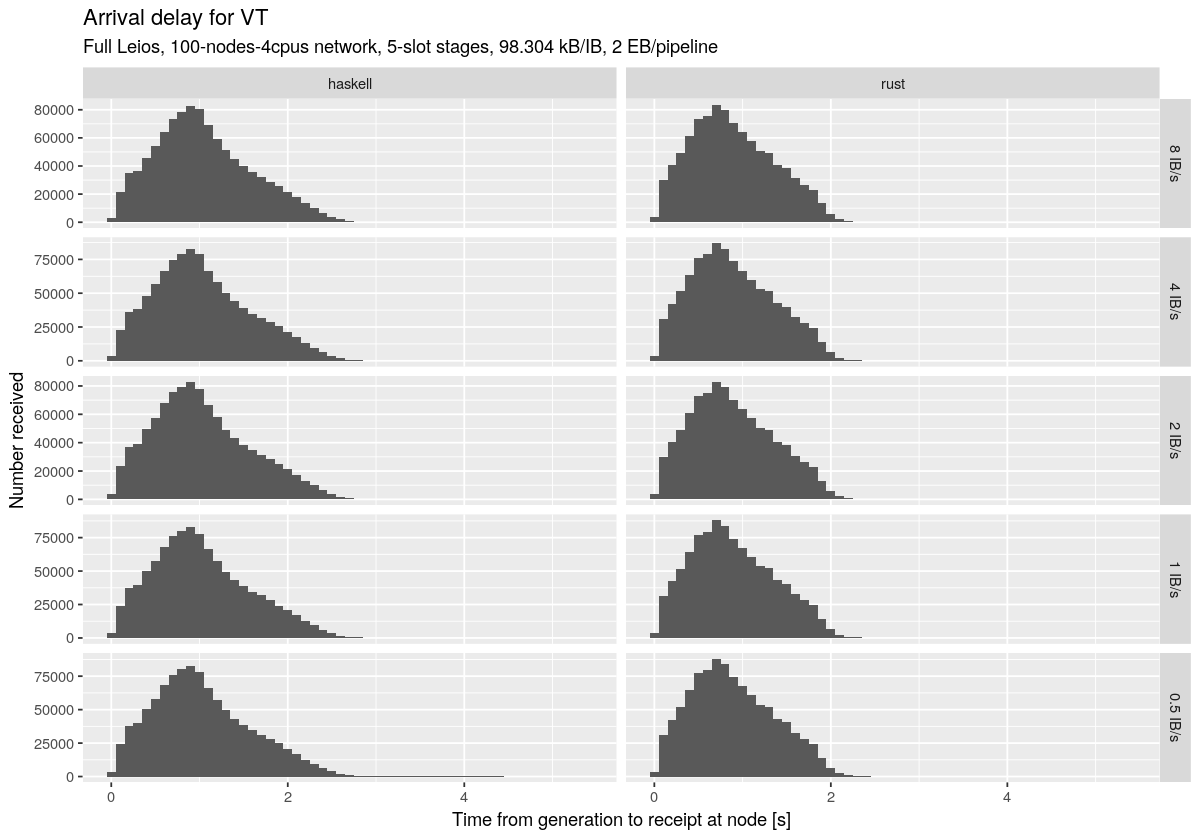

In [33]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`kind` == k & `ib-generation-probability` %in% ibRates],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [34]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`received`=as.numeric(.N)),
            by=.(`simulator`, `network`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`, `item`)
        ][,
            .(`total`=as.numeric(.N), `received`=sum(`received`)),
            by=.(`simulator`, `network`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`)
        ][,
            .(`received`=sum(`received`)/sum(`total`)),
            by=.(`simulator`, `network`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`)
        ][, .(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `sent`,
                `received`
        )], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate`  ~ `simulator`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

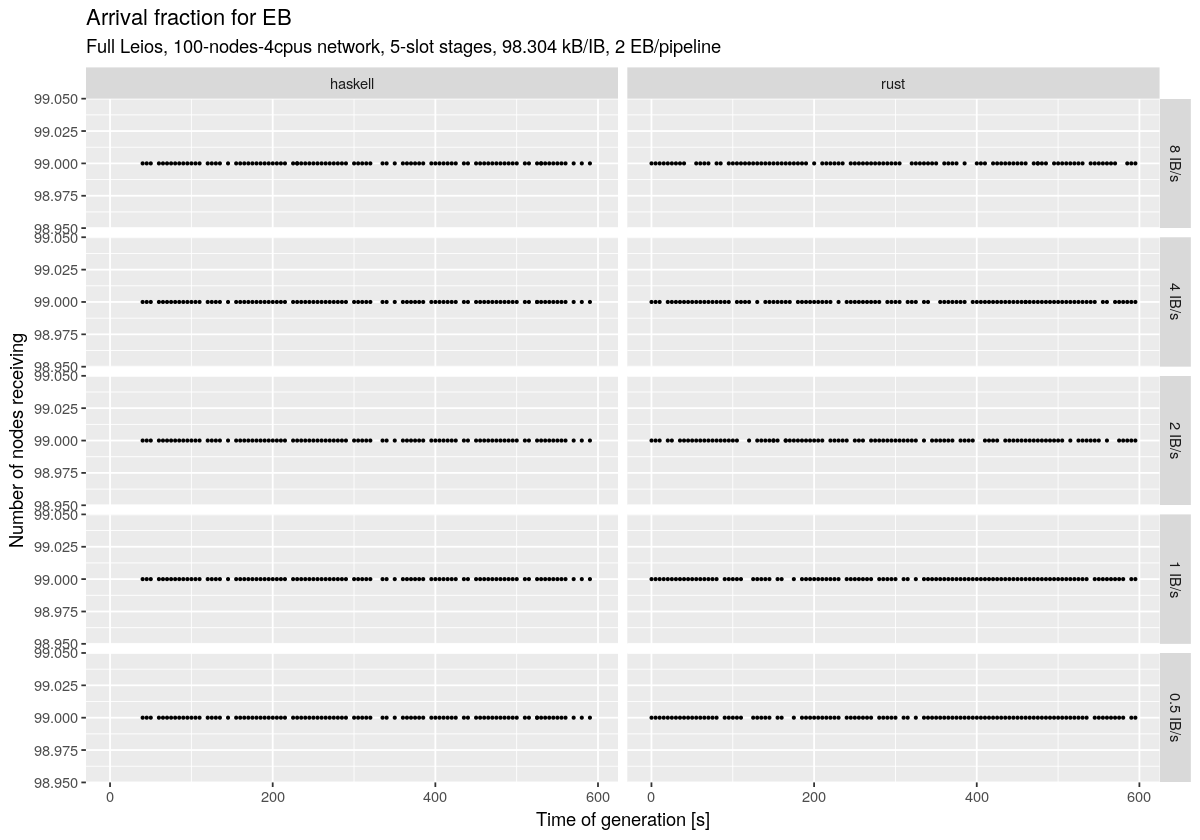

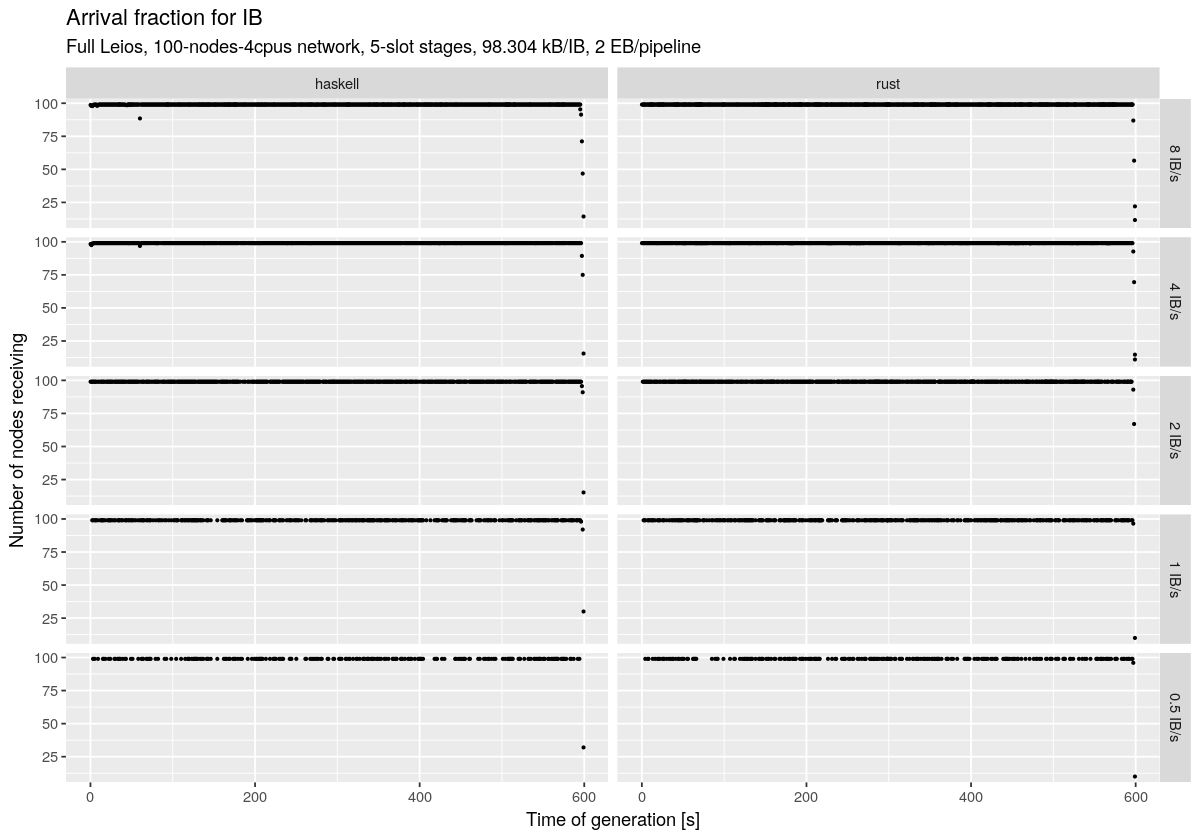

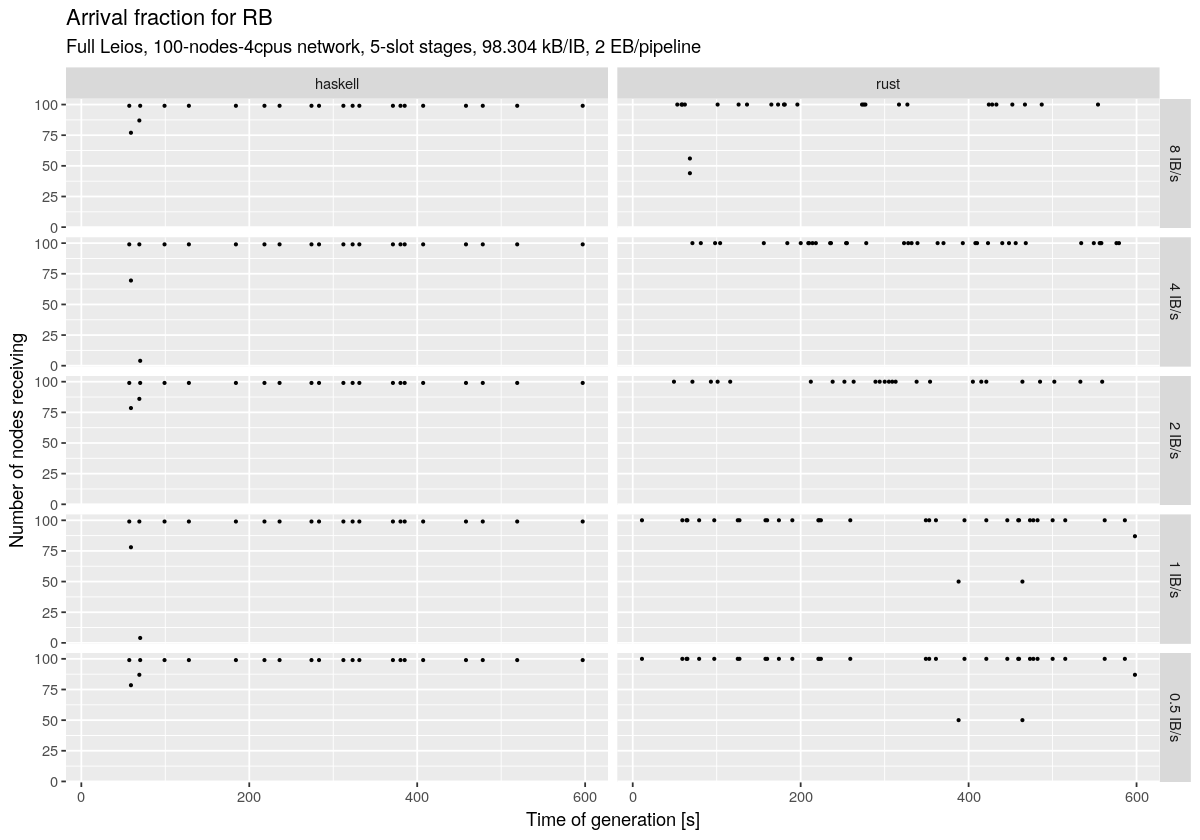

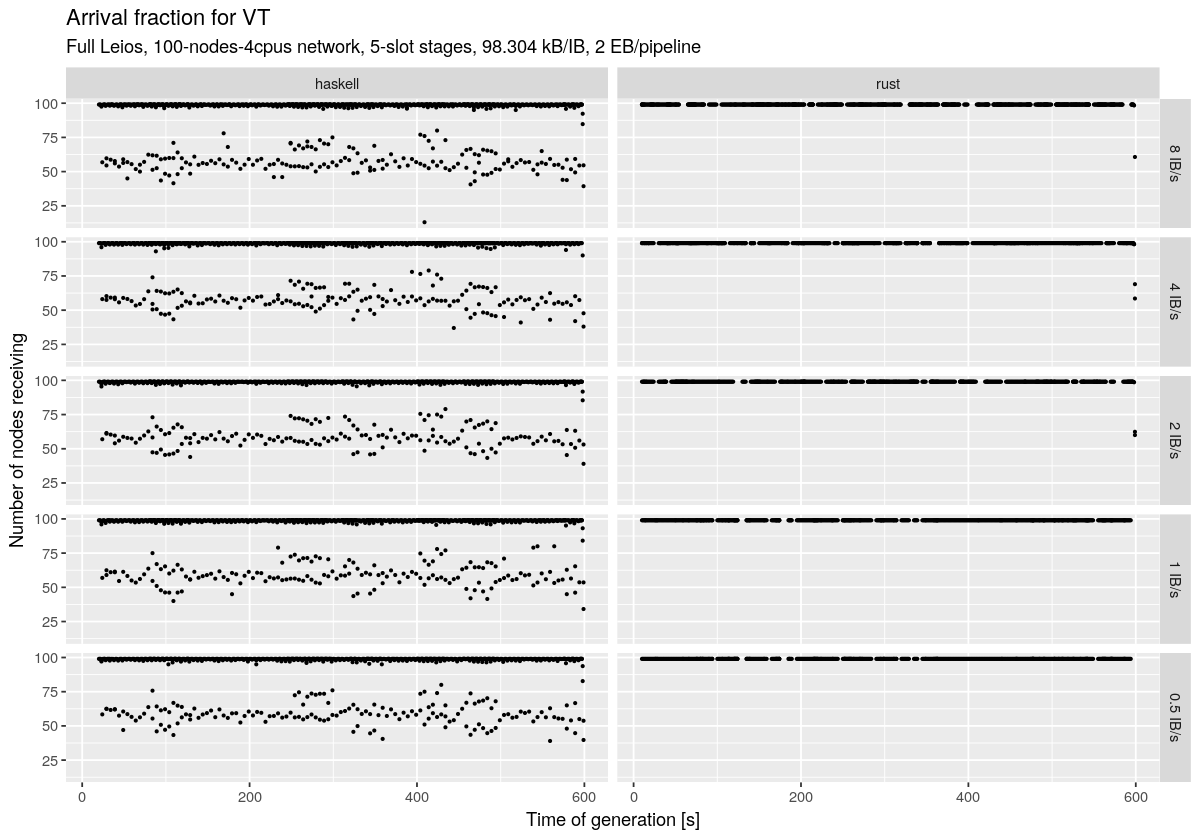

In [35]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`kind` == k & `ib-generation-probability` %in% ibRates],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [36]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `size`=sum(`size`, rm.na=TRUE)/1000000000
            ),
            by=.(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [GB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

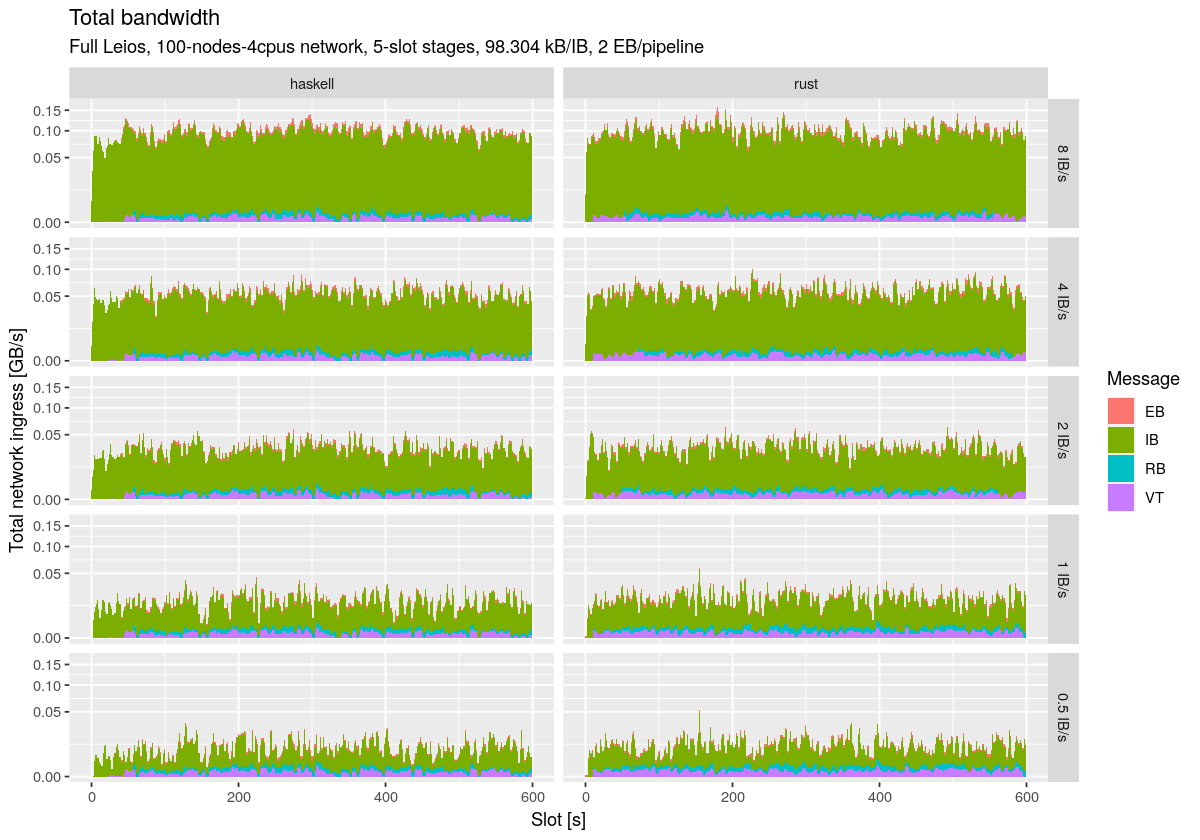

In [37]:
totalBandwidthPlot(
    receipts[`ib-generation-probability` %in% ibRates & !is.na(`elapsed`)],
    "Total bandwidth",
    outfiles=paste0("plots/ingress-total-area.png")
)

##### Bandwidth usage per node

In [38]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `size`=sum(`size`)/1000000 / 100
            ),
            by=.(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [MB/s]") +
        ggtitle("title", subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

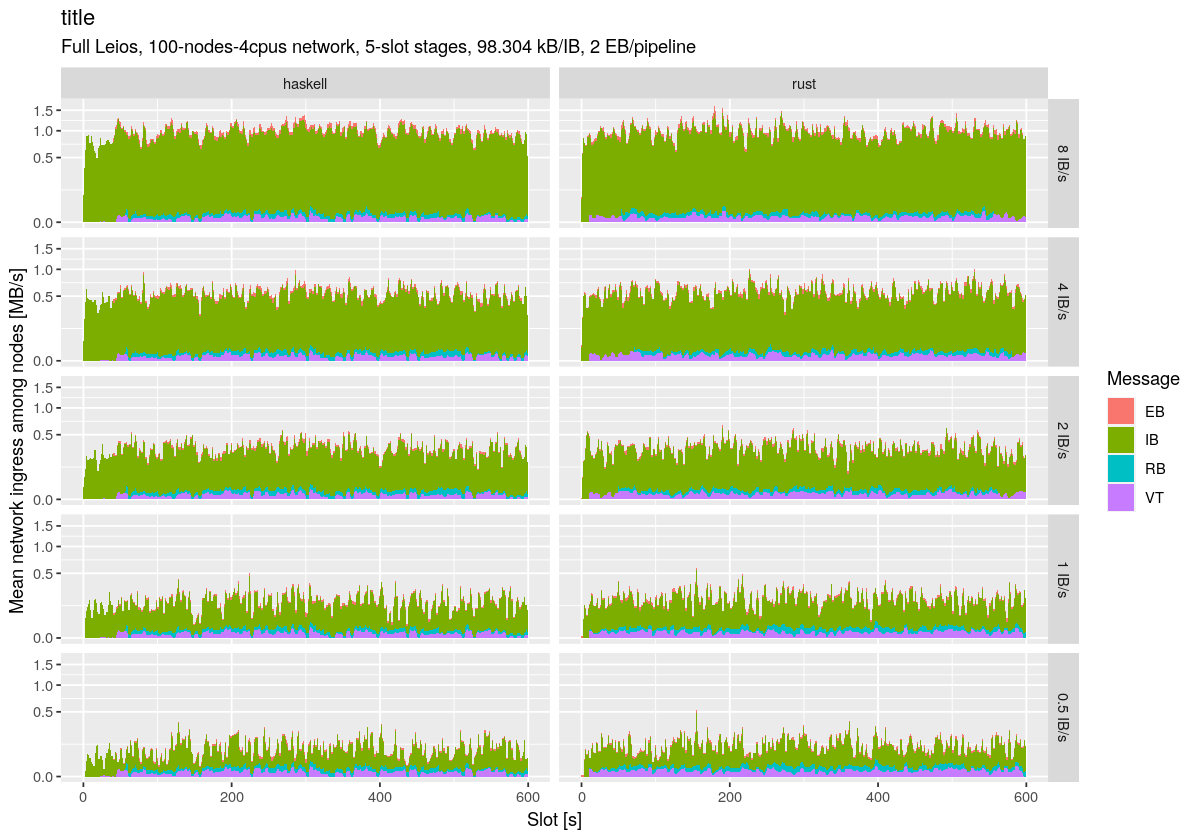

In [39]:
meanNodalIngressPlot(
    receipts[`ib-generation-probability` %in% ibRates], 
    "Mean nodal ingress",
    outfiles=paste0("plots/ingress-average-area.png")
)

In [40]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `size`=sum(`size`, rm.na=TRUE)/1000000
            ),
            by=.(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `slot`=floor(`received`),
                `Message`=`kind`,
                `recipient`
            )
        ][,
            .(`size`=max(`size`)),
            by=.(`simulator`, `ibRate`, `slot`, `Message`)
        ],
        aes(x=`slot`, y=`size`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

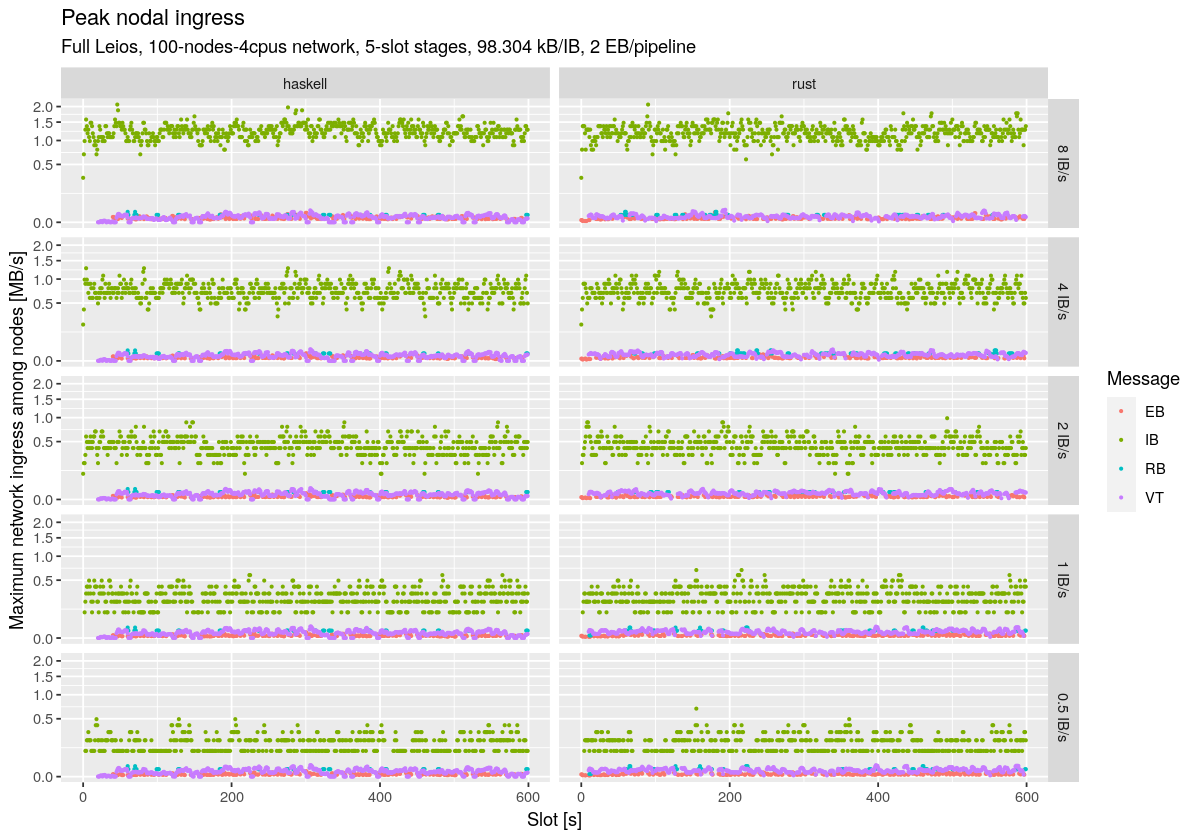

In [41]:
peakNodalIngressPlot(
    receipts[`ib-generation-probability` %in% ibRates], 
    "Peak nodal ingress",
    outfiles=paste0("plots/ingress-peak-point.png")
)

### CPU usage

#### Read results

In [42]:
cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
cpus %>% summary

   simulator         label                     network        
 haskell:24425307   full:46244362   100-nodes-4cpus:46244362  
 rust   :21819055                                             
                                                              
                                                              
                                                              
                                                              
                                                              
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   :0.50              Min.   : 65536         Min.   :1.500            
 1st Qu.:1.00              1st Qu.: 65536         1st Qu.:1.500            
 Median :2.00              Median : 98304         Median :2.000            
 Mean   :3.42              Mean   : 98297         Mean   :2.006            
 3rd Qu.:4.00              3rd Qu.:131072         3rd Qu.:2.500            
 Max.   :8.00              Max.   :13107

In [43]:
# Take one slice for the plotting
cpus <- cpus[
    `label` == "full" &
    `network` == "100-nodes-4cpus" &
    `ib-body-avg-size-bytes` == cpus[, quantile(`ib-body-avg-size-bytes`, 0.51) %>% as.numeric] &
    `eb-generation-probability` == cpus[, quantile(`eb-generation-probability`, 0.51) %>% as.numeric] &
    `leios-stage-length-slots` == cpus[, quantile(`leios-stage-length-slots`, 0.51) %>% as.numeric]
]

In [44]:
cpusNode <-
cpus[
    ,
    .(
        `duration`=sum(`duration`)
    ),
    by=.(
        `simulator`,
        `ib-generation-probability`,
        `ib-body-avg-size-bytes`,
        `leios-stage-length-slots`,
        `node`,
        `slot`
    )
]

#### Peak CPU usage

##### Histogram

In [45]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `duration`=100*max(`duration`)
            ),
            by=.(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `slot`
            )
        ], 
        aes(x=`duration`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

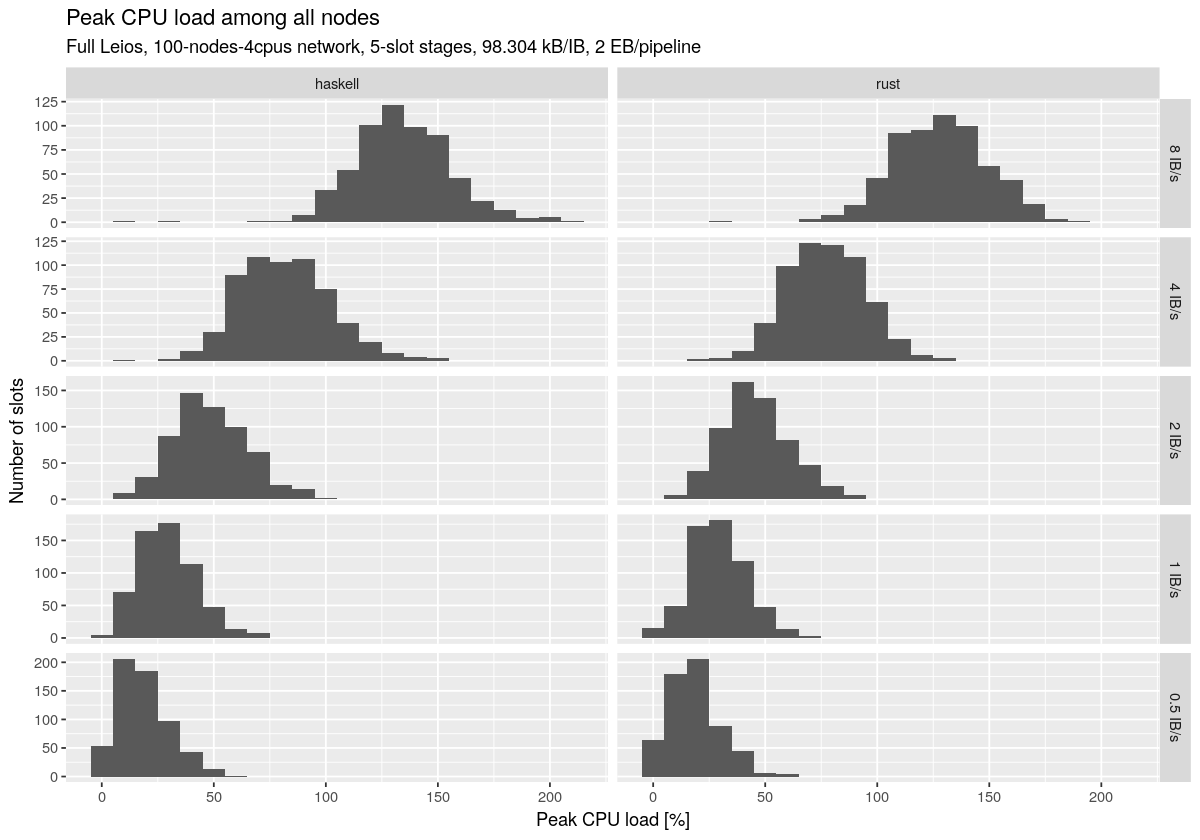

In [46]:
peakCpuHistogram(
    cpusNode[`ib-generation-probability` %in% ibRates], 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/cpu-peak-histogram.png")
)

##### Time series

In [47]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `duration`=100*mean(`duration`)
            ),
            by=.(
                `simulator`,
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `slot`
            )
        ], 
        aes(x=`slot`, y=`duration`)) +
        geom_line() +
        facet_grid(`ibRate` ~ `simulator`, scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

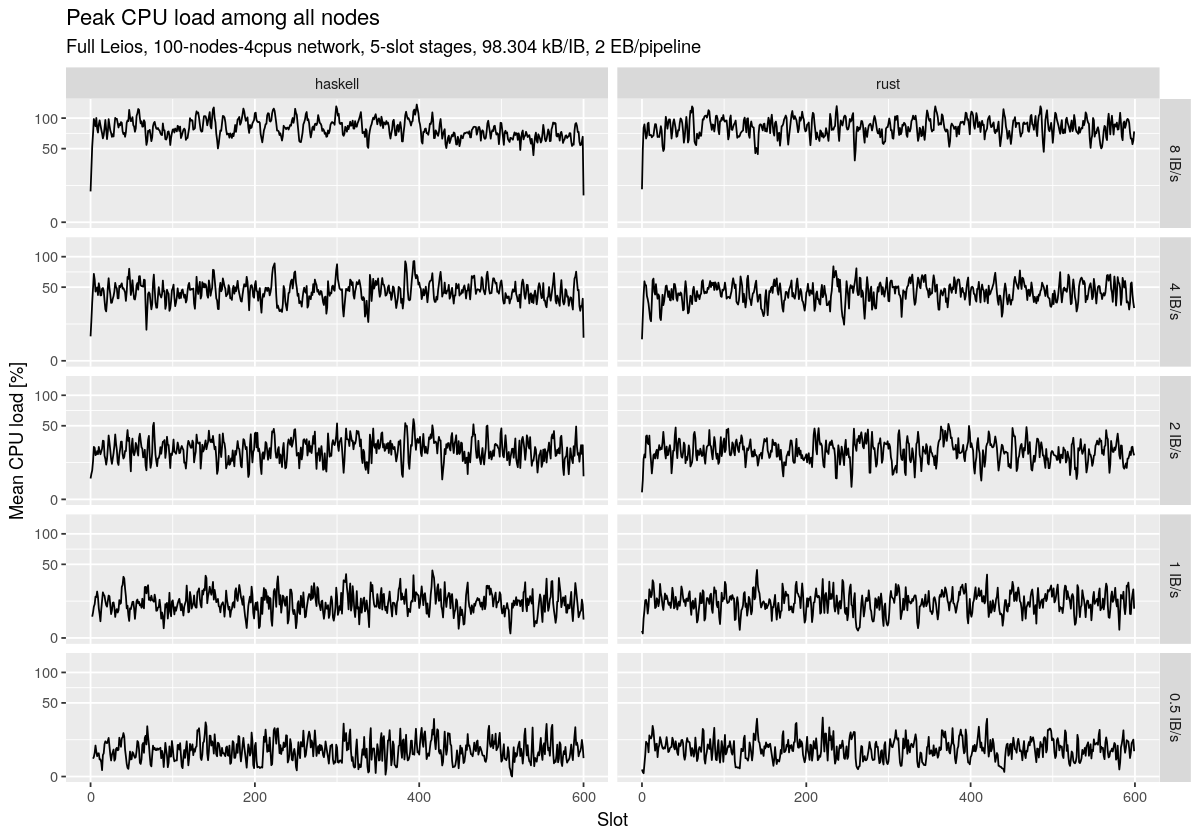

In [48]:
peakCpuTimeseries(
    cpusNode[`ib-generation-probability` %in% ibRates],
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [49]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `duration`=100*sum(`duration`)/nodeSeconds
            ),
            by=.(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `task`
            )
        ], 
        aes(x="", fill=`task`, y=`duration`)) +
        geom_bar(stat = "identity") +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

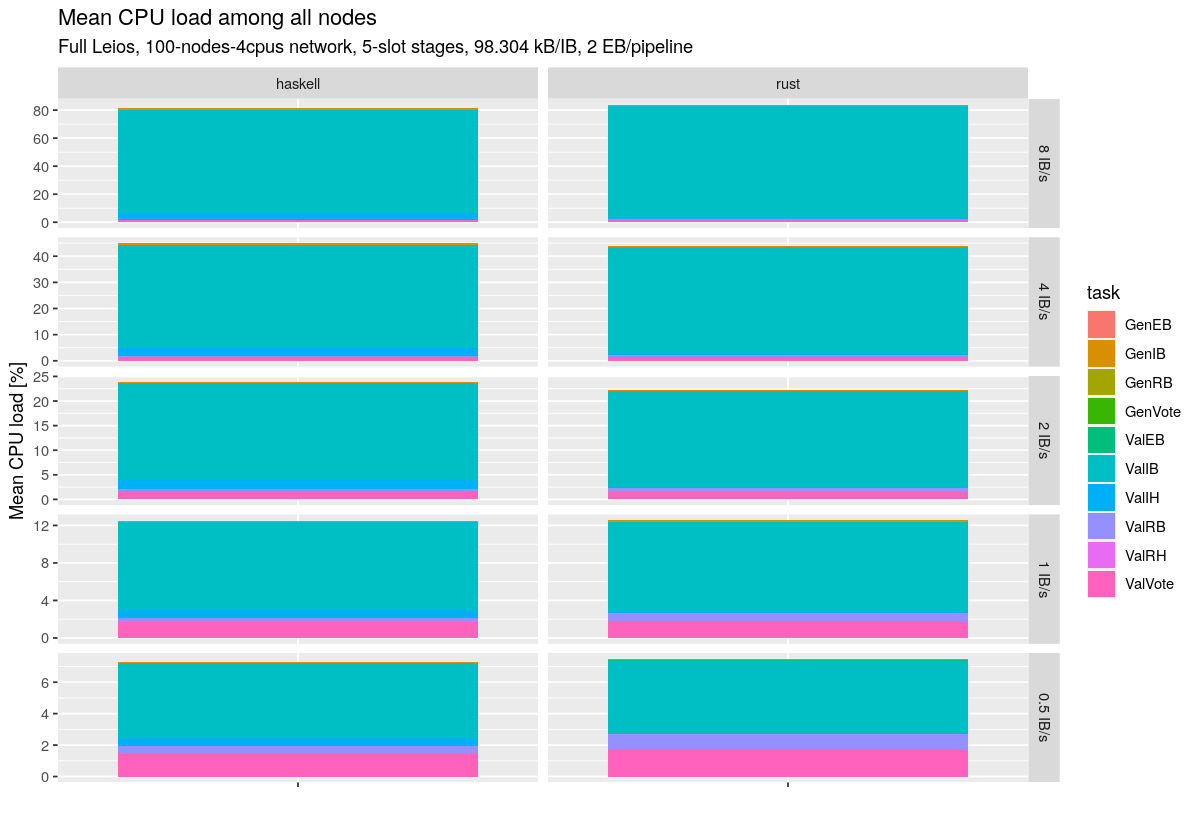

In [50]:
meanCpuHistogram(
    cpus[`ib-generation-probability` %in% ibRates],
    100 * 600, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/cpu-mean-histogram.png")
)

##### Time series

In [51]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `duration`=100*sum(`duration`)/nodeSeconds
            ),
            by=.(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `slot`,
                `task`
            )
        ], 
        aes(x=`slot`, y=`duration`, color=`task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

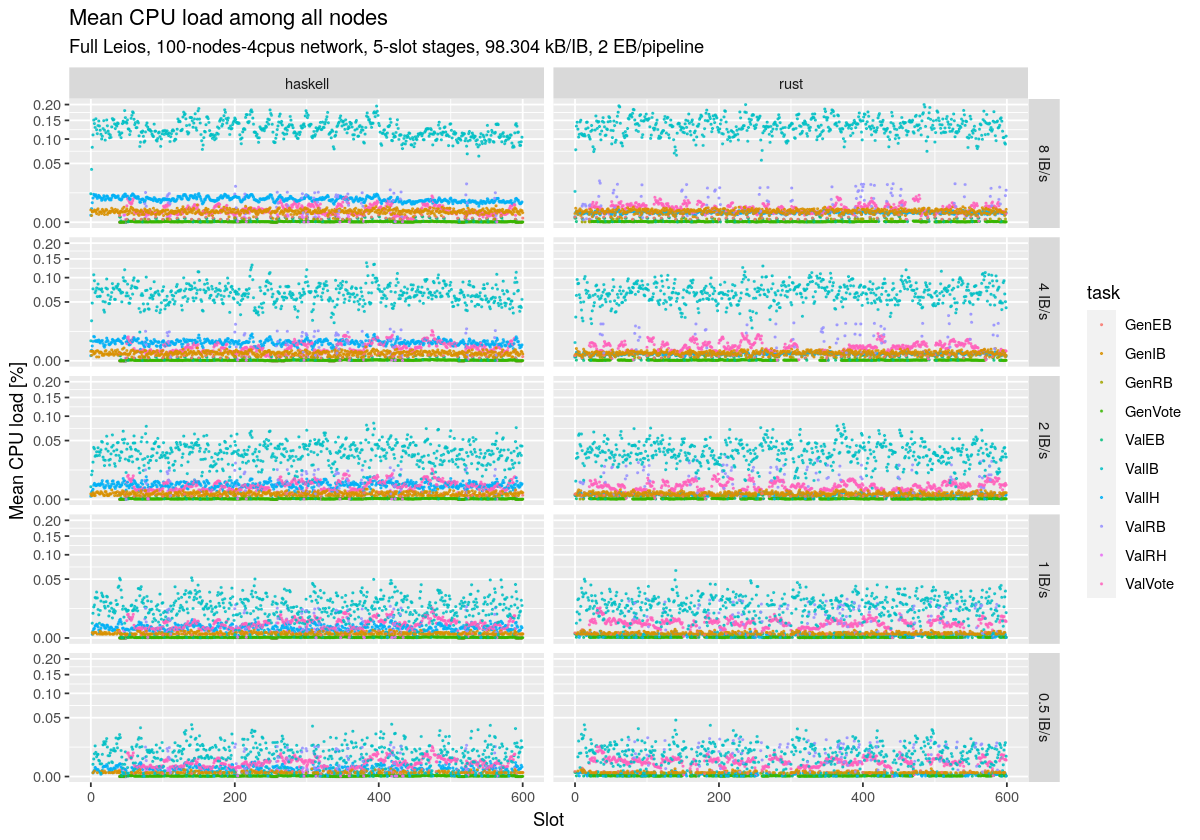

In [52]:
meanCpuTimeseries(
    cpus[`ib-generation-probability` %in% ibRates], 
    100 * 600, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/cpu-mean-timeseries.png")
)

### Input blocks

#### Read results

In [53]:
ibgen <- fread("results/ibgen.csv.gz", stringsAsFactors=TRUE)
ibgen %>% summary

   simulator       label                   network      
 haskell:250830   full:502308   100-nodes-4cpus:502308  
 rust   :251478                                         
                                                        
                                                        
                                                        
                                                        
                                                        
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   :0.500             Min.   : 65536         Min.   :1.5              
 1st Qu.:4.000             1st Qu.: 65536         1st Qu.:1.5              
 Median :8.000             Median : 98304         Median :2.0              
 Mean   :5.507             Mean   : 98304         Mean   :2.0              
 3rd Qu.:8.000             3rd Qu.:131072         3rd Qu.:2.5              
 Max.   :8.000             Max.   :131072         Max.   :2.5              
            

In [54]:
# Take one slice for the plotting
ibgen <- ibgen[
    `label` == "full" &
    `network` == "100-nodes-4cpus" &
    `ib-body-avg-size-bytes` == ibgen[, quantile(`ib-body-avg-size-bytes`, 0.51) %>% as.numeric] &
    `eb-generation-probability` == ibgen[, quantile(`eb-generation-probability`, 0.51) %>% as.numeric] &
    `leios-stage-length-slots` == ibgen[, quantile(`leios-stage-length-slots`, 0.51) %>% as.numeric]
]

#### IB inculsion in EBs

##### Histogram

In [55]:
ibInclusionHistogram <- function(is, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        is[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Number of EBs that include the IB`=`eb-count`
            ),
           .(`simulator`)
        ],
        aes(x=`Number of EBs that include the IB`)
    ) +
        geom_histogram(bins=5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 5)) +
        ylab("Number of IBs") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

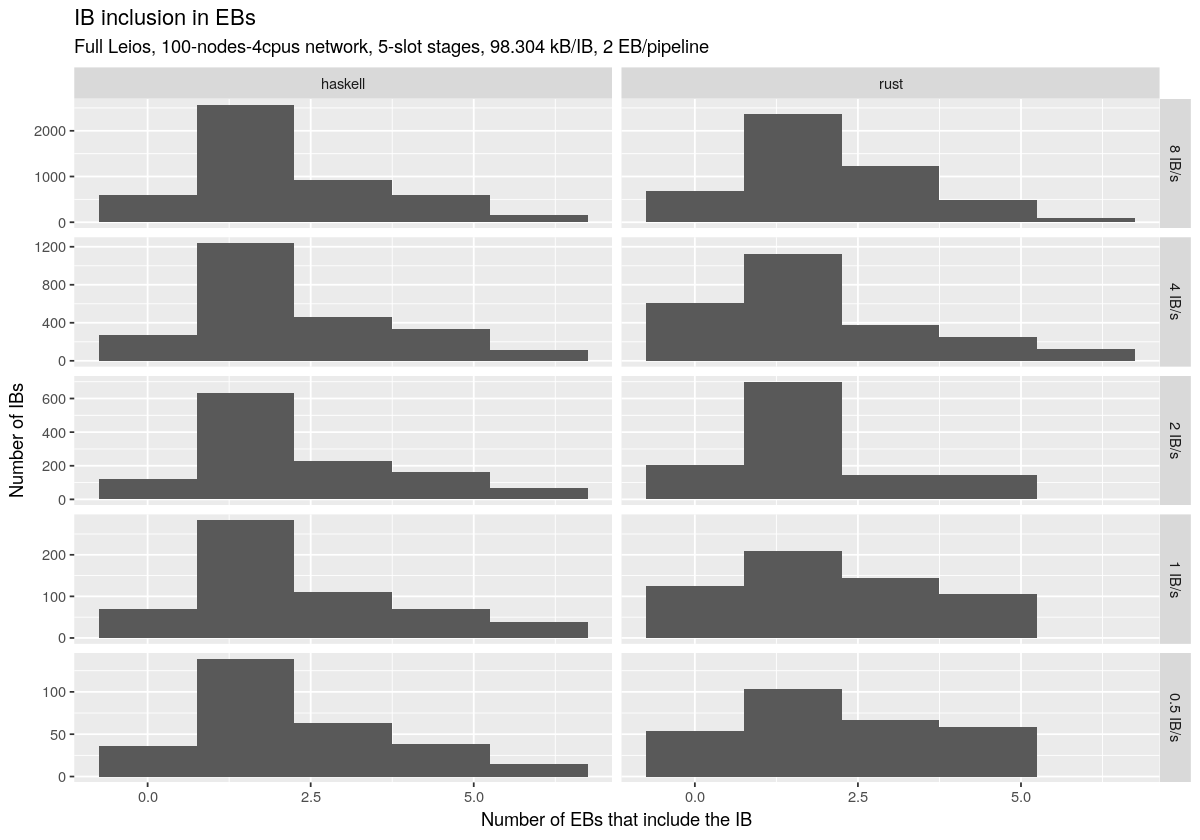

In [56]:
ibInclusionHistogram(
    ibgen[`ib-generation-probability` %in% ibRates], 
    "IB inclusion in EBs",
    scales="free_y",
    paste0("plots/ib-inclusion-ebs-histogram.png")
)

##### Time series

In [57]:
ibInclusionTimeseries <- function(is, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        is[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of IB generation [s]`=`time`,
                `Number of EBs including the IB`=`eb-count`
            ),
           `simulator`
        ],
        aes(x=`Time of IB generation [s]`, y=`Number of EBs including the IB`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

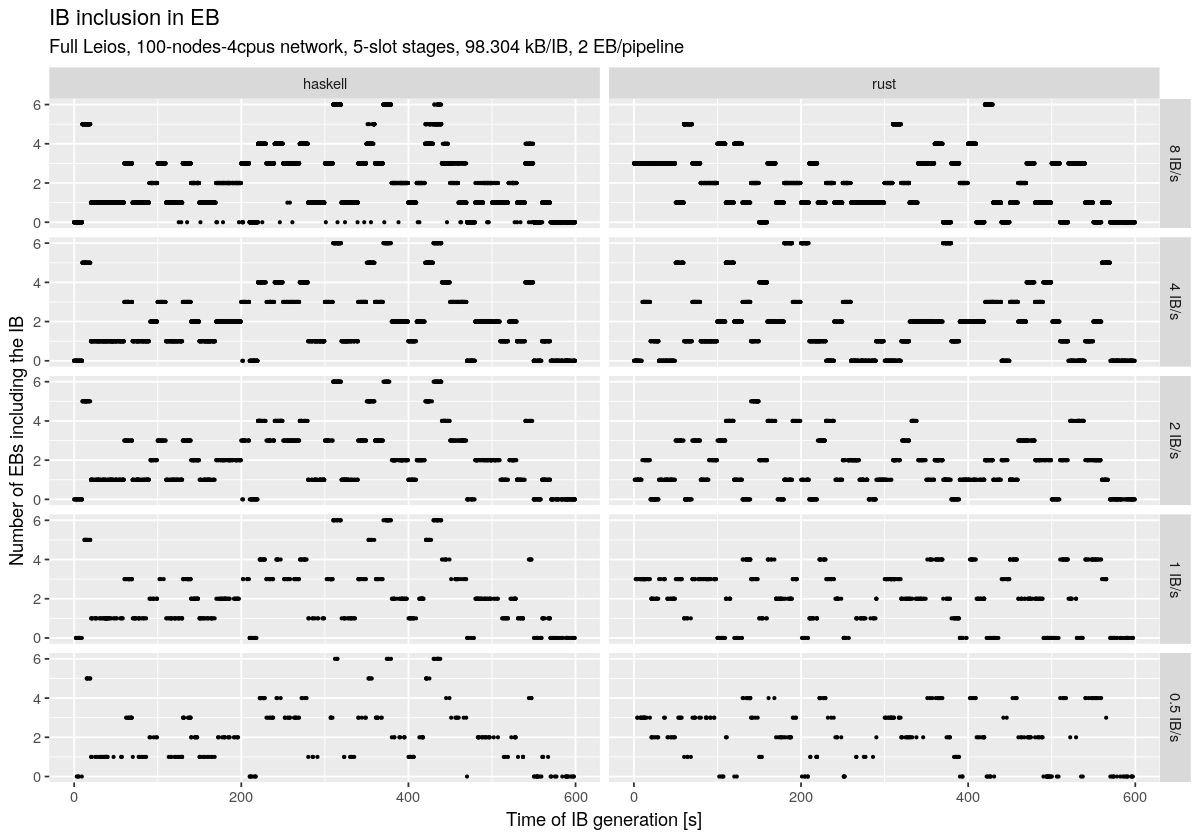

In [58]:
ibInclusionTimeseries(
    ibgen[`ib-generation-probability` %in% ibRates], 
    "IB inclusion in EB",
    outfiles=paste0("plots/ib-inclusion-ebs-timeseries.png")
)

#### IB size

In [59]:
ibSizeTimeseries <- function(is, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        is[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of IB generation [s]`=`time`,
                `IB size [kB]`=`size`/1000
            ),
           `simulator`
    ],
    aes(x=`Time of IB generation [s]`, y=`IB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `simulator`, scales=scales) +
    ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

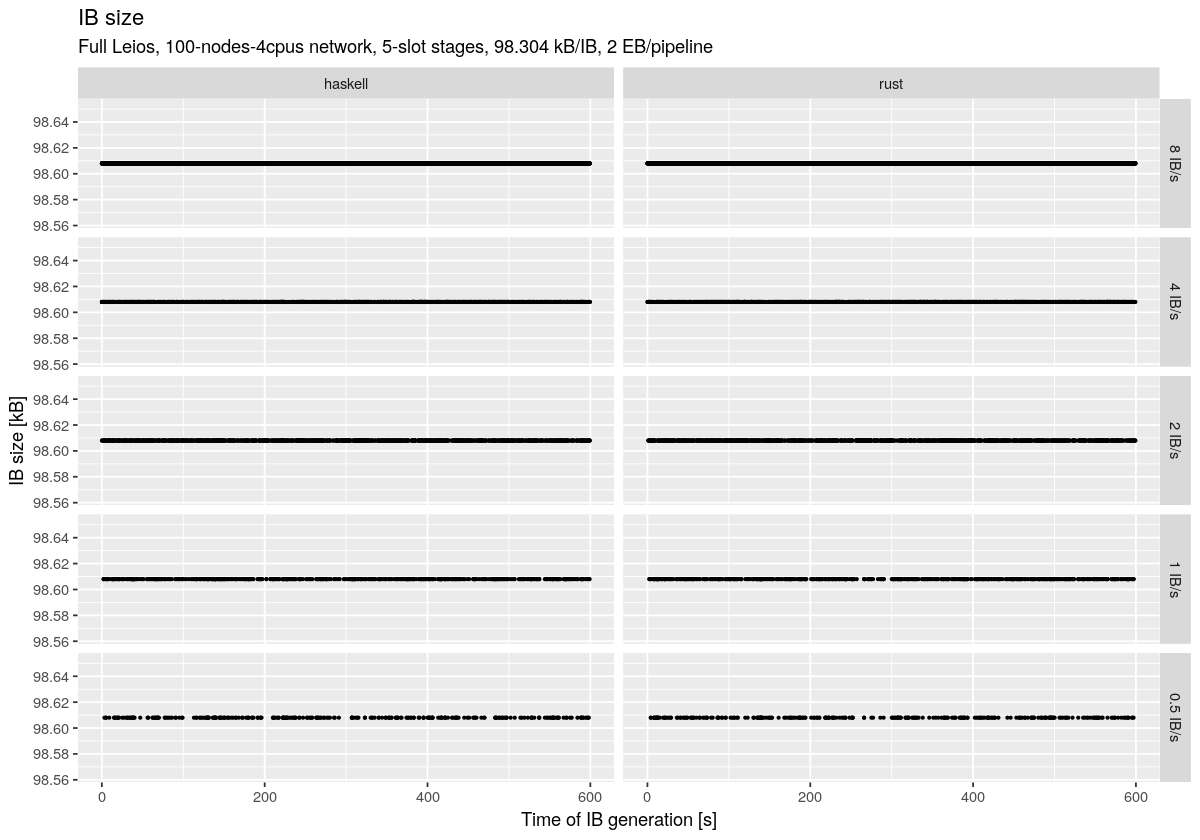

In [60]:
ibSizeTimeseries(
    ibgen[`ib-generation-probability` %in% ibRates], 
    "IB size",
    outfiles=paste0("plots/ib-size-timeseries.png")
)

### Endorser blocks

#### Read results

In [61]:
ebgen <- fread("results/ebgen.csv.gz", stringsAsFactors=TRUE)
ebgen %>% summary

   simulator      label                  network      ib-generation-probability
 haskell:18645   full:37641   100-nodes-4cpus:37641   Min.   :0.500            
 rust   :18996                                        1st Qu.:1.000            
                                                      Median :2.000            
                                                      Mean   :3.082            
                                                      3rd Qu.:4.000            
                                                      Max.   :8.000            
                                                                               
 ib-body-avg-size-bytes eb-generation-probability leios-stage-length-slots
 Min.   : 65536         Min.   :1.500             Min.   : 5.000          
 1st Qu.: 65536         1st Qu.:1.500             1st Qu.: 5.000          
 Median : 98304         Median :2.000             Median : 5.000          
 Mean   : 98304         Mean   :2.082             Mean   : 8

In [62]:
# Take one slice for the plotting
ebgen <- ebgen[
    `label` == "full" &
    `network` == "100-nodes-4cpus" &
    `ib-body-avg-size-bytes` == ebgen[, quantile(`ib-body-avg-size-bytes`, 0.51) %>% as.numeric] &
    `eb-generation-probability` == ebgen[, quantile(`eb-generation-probability`, 0.51) %>% as.numeric] &
    `leios-stage-length-slots` == ebgen[, quantile(`leios-stage-length-slots`, 0.51) %>% as.numeric]
]

#### EB inclusion in RBs

##### Histogram

In [63]:
ibsReferencedHistogram <- function(es, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        es[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Number of IBs referenced by EB`=`ib-count`
            ),
           `simulator`
        ],
        aes(x=`Number of IBs referenced by EB`)
    ) +
        geom_histogram(bins=5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ylab("Number of EBs") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

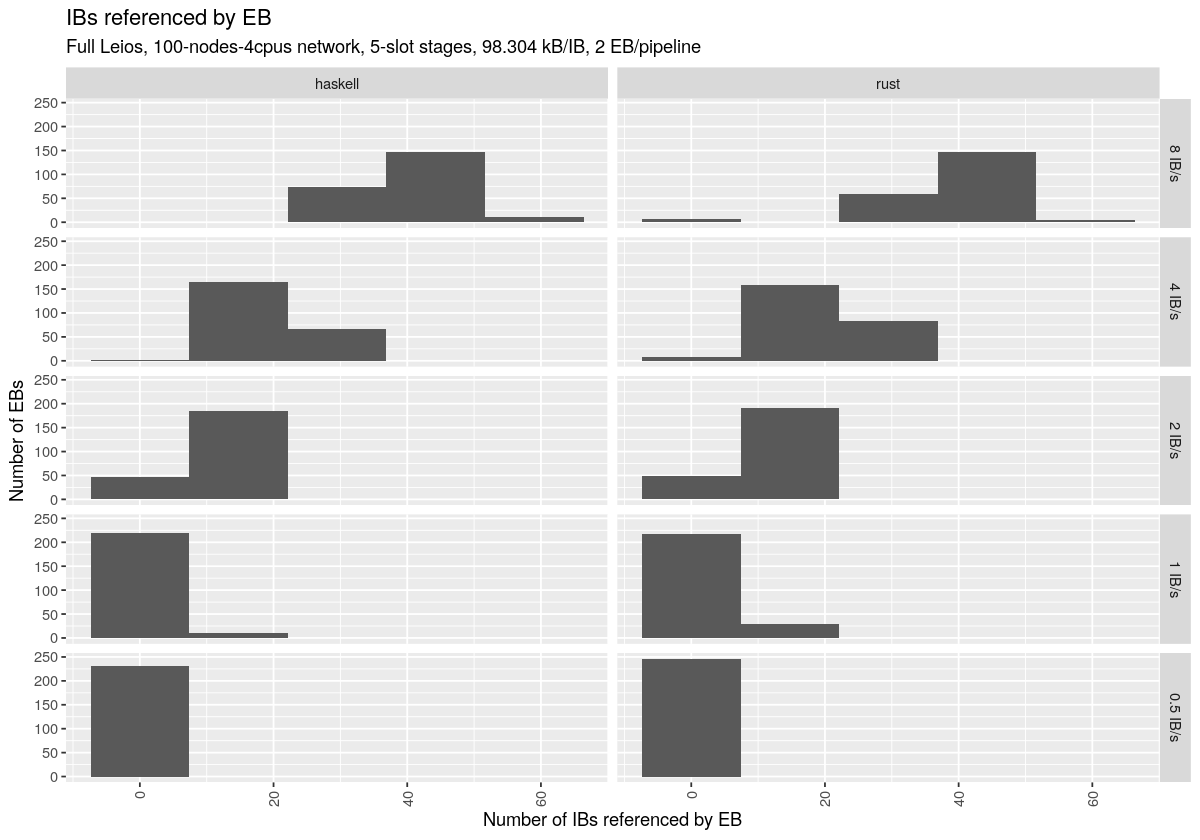

In [64]:
ibsReferencedHistogram(
    ebgen[`ib-generation-probability` %in% ibRates], 
    "IBs referenced by EB",
    outfiles=paste0("plots/ibs-referenced-eb-histogram.png")
)

##### Time series

In [65]:
ibsReferencedTimeseries <- function(es, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        es[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of EB generation [s]`=`time`,
                `Number of IBs referenced by EB`=`ib-count`
            ),
           `simulator`
        ],
        aes(x=`Time of EB generation [s]`, y=`Number of IBs referenced by EB`)
    ) +
        geom_point(size=1.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

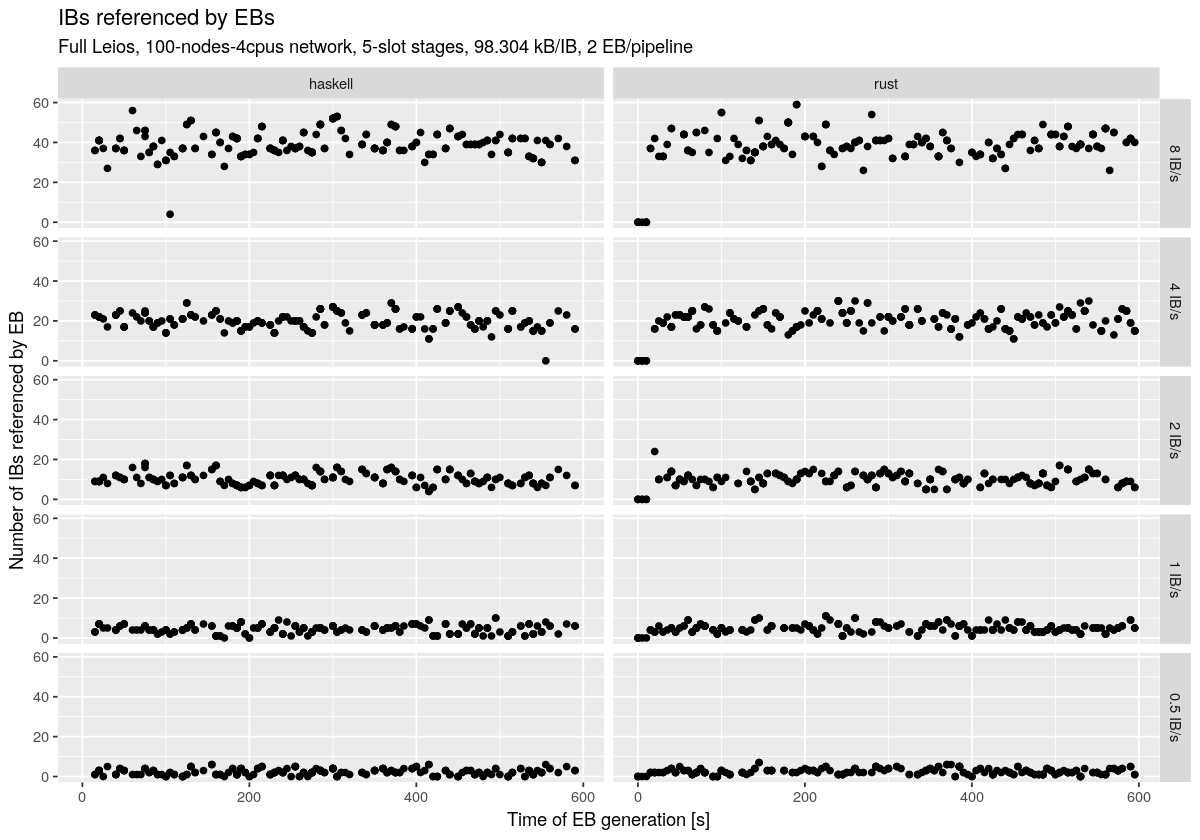

In [66]:
ibsReferencedTimeseries(
    ebgen[`ib-generation-probability` %in% ibRates], 
    "IBs referenced by EBs",
    outfiles=paste0("plots/ibs-referenced-ebs-timeseries.png")
)

#### EB inclusion in RBs

##### Histogram

In [67]:
ebInclusionHistogram <- function(es, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        es[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Number of RBs that include the EB`=`rb-count`
            ),
           `simulator`
        ],
        aes(x=`Number of RBs that include the EB`)
    ) +
        geom_histogram(binwidth=1) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 3)) +
        ylab("Number of EBs") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

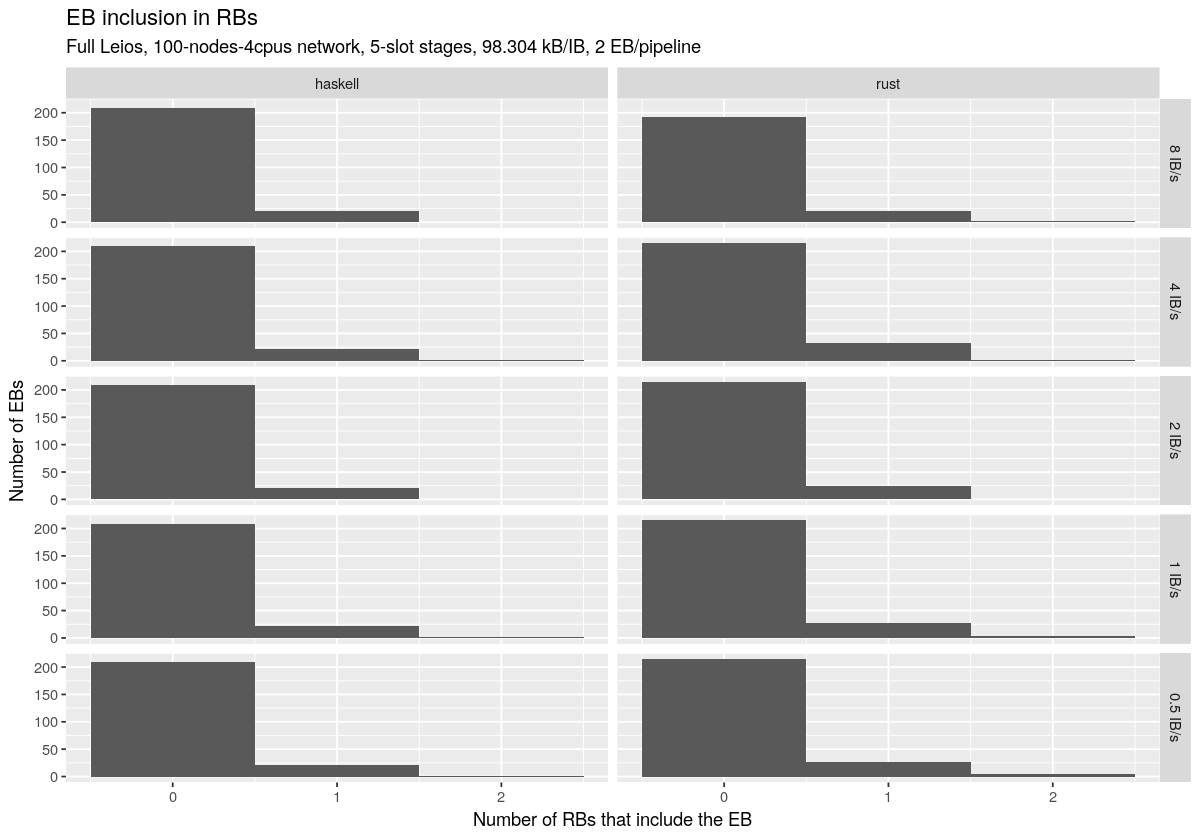

In [68]:
ebInclusionHistogram(
    ebgen[`ib-generation-probability` %in% ibRates], 
    "EB inclusion in RBs",
    outfiles=paste0("plots/eb-inclusion-rbs-histogram.png")
)

##### Time series

In [69]:
ebInclusionTimeseries <- function(es, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        es[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of EB generation [s]`=`time`,
                `Number of RBs including the EB`=`rb-count`
            ),
           `simulator`
        ],
        aes(x=`Time of EB generation [s]`, y=`Number of RBs including the EB`)
    ) +
        geom_point(size=1.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

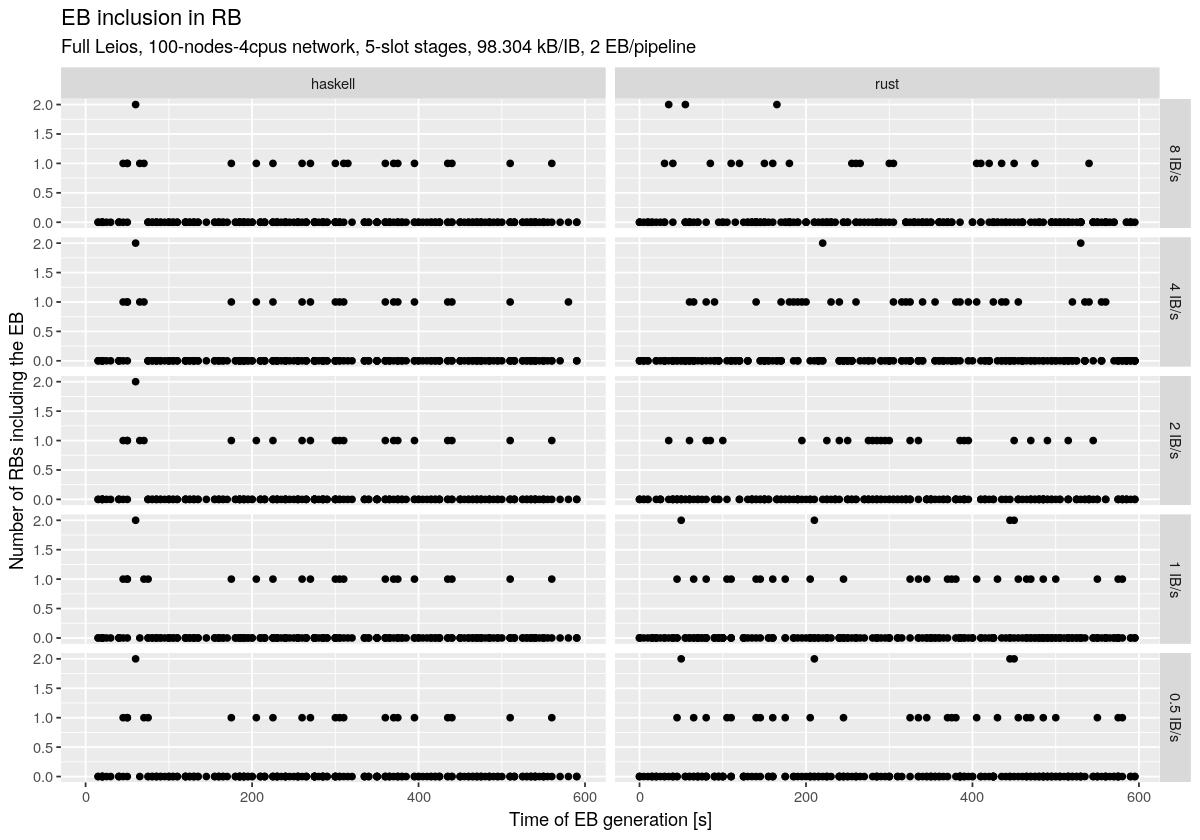

In [70]:
ebInclusionTimeseries(
    ebgen[`ib-generation-probability` %in% ibRates], 
    "EB inclusion in RB",
    outfiles=paste0("plots/eb-inclusion-rbs-timeseries.png")
)

#### EB size

In [71]:
ebSizeTimeseries <- function(es, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        es[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of EB generation [s]`=`time`,
                `EB size [kB]`=`size`/1000
            ),
           `simulator`
        ],
        aes(x=`Time of EB generation [s]`, y=`EB size [kB]`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

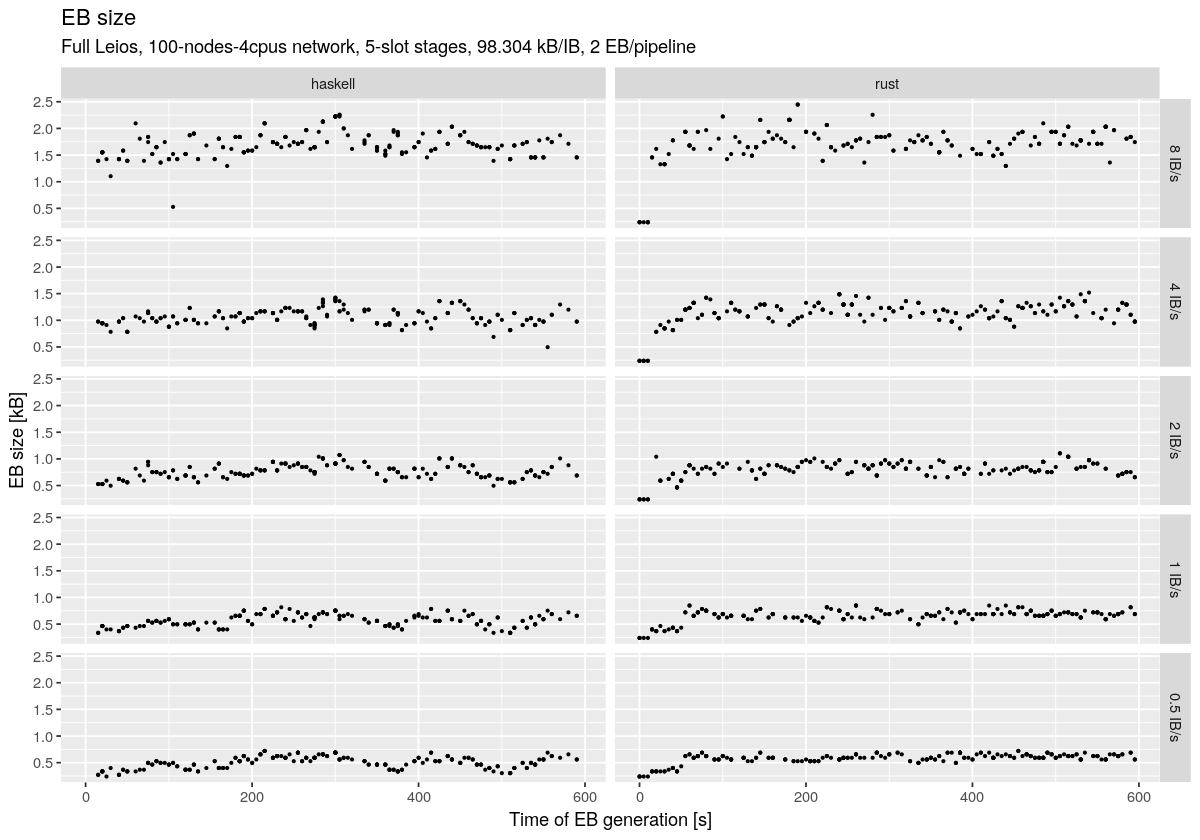

In [72]:
ebSizeTimeseries(
    ebgen[`ib-generation-probability` %in% ibRates], 
    "EB size",
    outfiles=paste0("plots/eb-size-timeseries.png")
)

In [73]:
ebSizeScatterplot <- function(es, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        es[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Number of IBs referenced by the EB`=`ib-count`,
                `EB size [kB]`=`size`/1000
            ),
           `simulator`
        ],
        aes(x=`Number of IBs referenced by the EB`, y=`EB size [kB]`, color=`ibRate`)
    ) +
        geom_point(size=0.5) +
        facet_grid(. ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

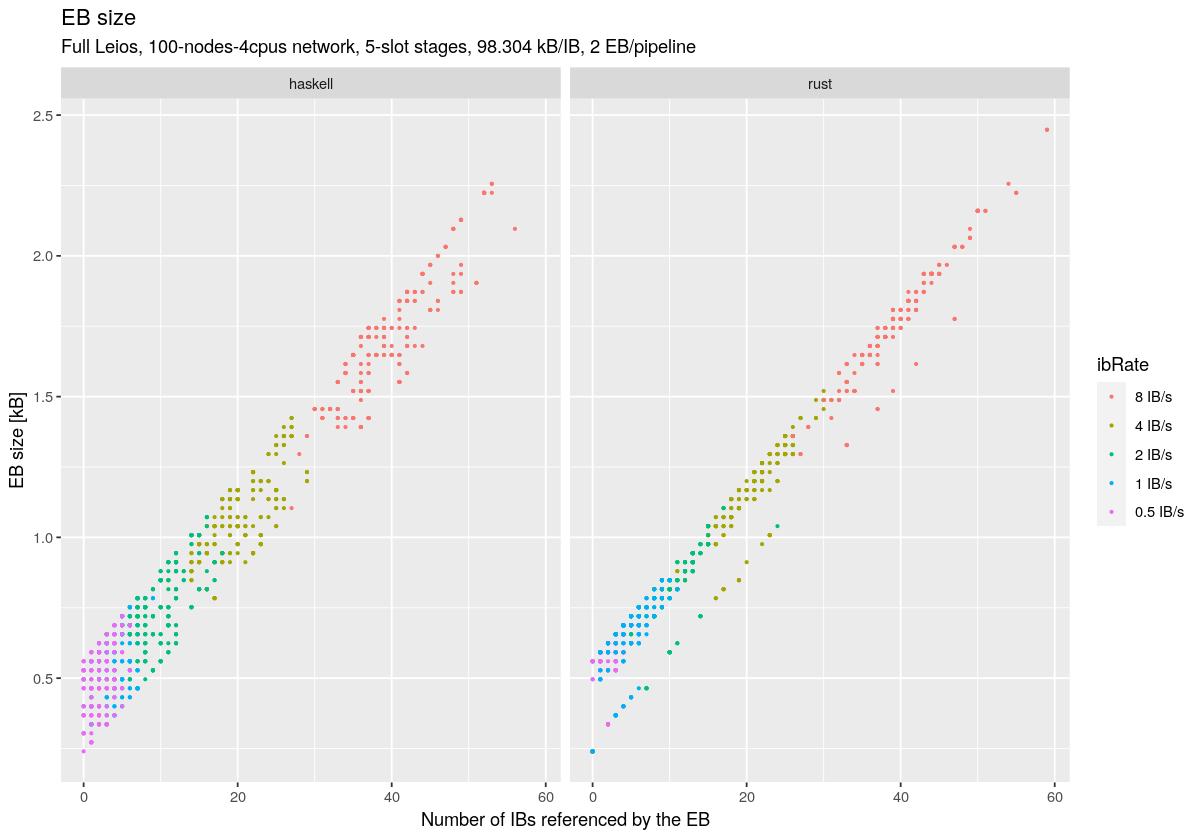

In [74]:
ebSizeScatterplot(
    ebgen[`ib-generation-probability` %in% ibRates], 
    "EB size",
    outfiles=paste0("plots/eb-size-scatterplot.png")
)

### Ranking blocks

#### Read results

In [75]:
rbgen <- fread("results/rbgen.csv.gz", stringsAsFactors=TRUE)
rbgen %>% summary

   simulator     label                 network     ib-generation-probability
 haskell:3105   full:7116   100-nodes-4cpus:7116   Min.   :0.500            
 rust   :4011                                      1st Qu.:1.000            
                                                   Median :2.000            
                                                   Mean   :3.031            
                                                   3rd Qu.:4.000            
                                                   Max.   :8.000            
                                                                            
 ib-body-avg-size-bytes eb-generation-probability leios-stage-length-slots
 Min.   : 65536         Min.   :1.500             Min.   : 5.00           
 1st Qu.: 65536         1st Qu.:1.500             1st Qu.: 5.00           
 Median : 98304         Median :2.000             Median :10.00           
 Mean   : 98304         Mean   :1.994             Mean   :11.43           
 3rd Qu.:

In [76]:
# Take one slice for the plotting
rbgen <- rbgen[
    `label` == "full" &
    `network` == "100-nodes-4cpus" &
    `ib-body-avg-size-bytes` == rbgen[, quantile(`ib-body-avg-size-bytes`, 0.51) %>% as.numeric] &
    `eb-generation-probability` == rbgen[, quantile(`eb-generation-probability`, 0.51) %>% as.numeric] &
    `leios-stage-length-slots` == rbgen[, quantile(`leios-stage-length-slots`, 0.51) %>% as.numeric]
]

#### EB inclusion in RBs

##### Histogram

In [77]:
rbInclusionHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Number of EBs referenced by RB`=`eb-count`
            ),
           `simulator`
        ],
        aes(x=`Number of EBs referenced by RB`)
    ) +
        geom_histogram(binwidth=1) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 2)) +
        ylab("Number of RBs") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

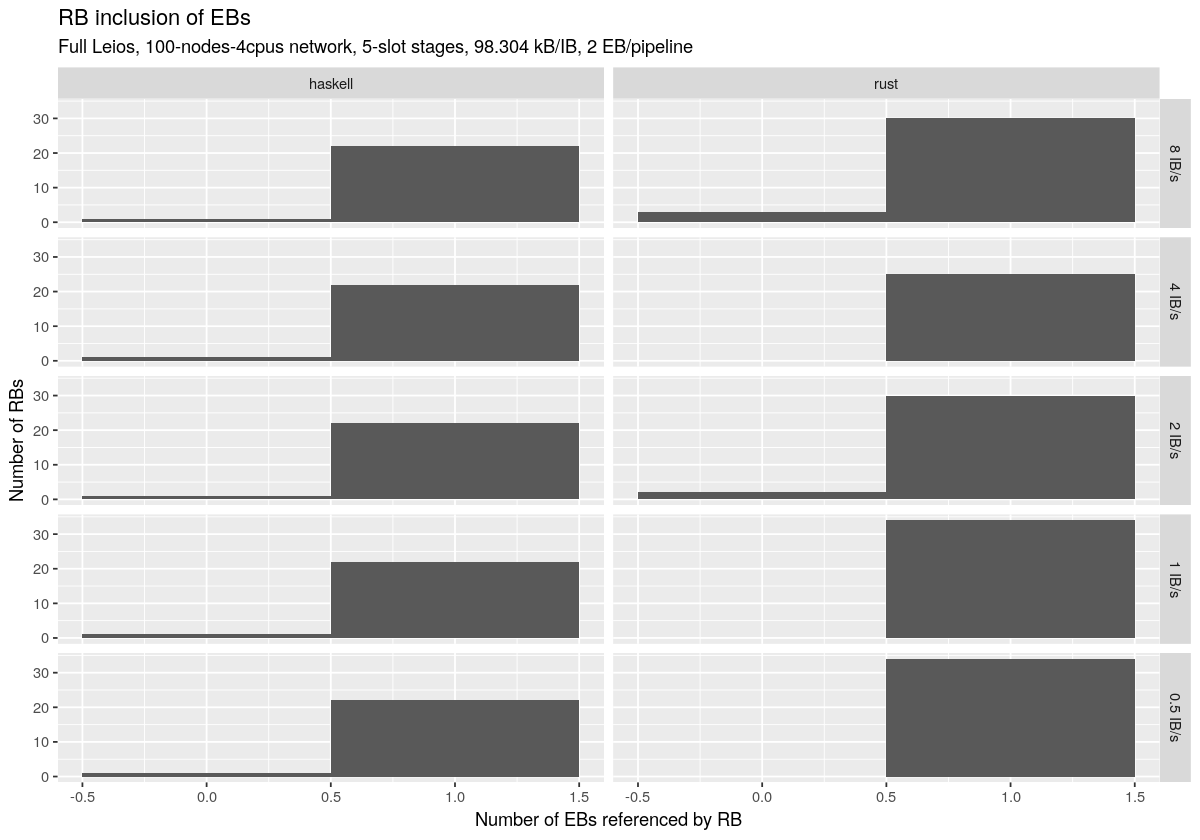

In [78]:
rbInclusionHistogram(
    rbgen[`ib-generation-probability` %in% ibRates], 
    "RB inclusion of EBs",
    outfiles=paste0("plots/ebs-referenced-rb-histogram.png")
)

##### Time series

In [79]:
rbInclusionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of RB generation [s]`=`time`,
                `Number of EB referenced by RB`=`eb-count`
            ),
           `simulator`
        ],
        aes(x=`Time of RB generation [s]`, y=`Number of EB referenced by RB`)
    ) +
        geom_point(size=1.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

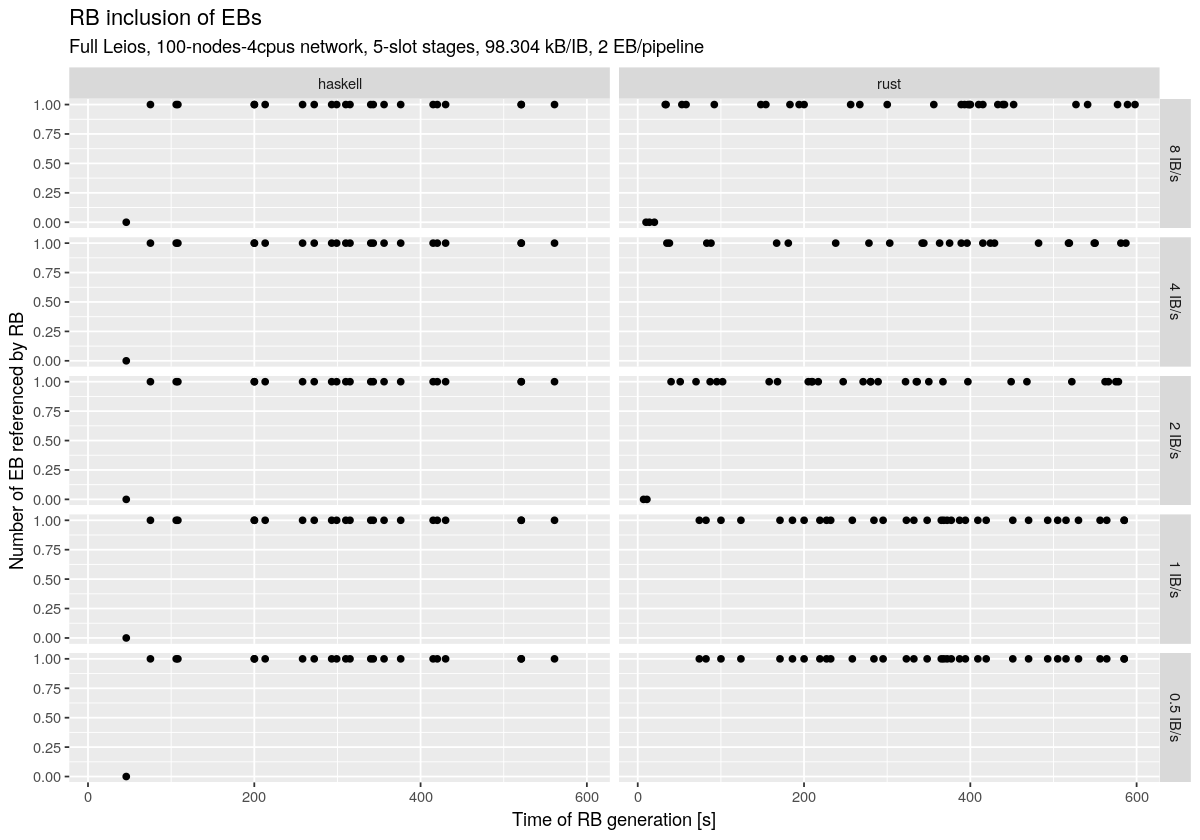

In [80]:
rbInclusionTimeseries(
    rbgen[`ib-generation-probability` %in% ibRates], 
    "RB inclusion of EBs",
    outfiles=paste0("plots/ebs-referenced-rb-timeseries.png")
)

#### RB size

In [81]:
rbSizeTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of RB generation [s]`=`time`,
                `RB size [kB]`=`size`/1000
            ),
           `simulator`
        ],
        aes(x=`Time of RB generation [s]`, y=`RB size [kB]`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

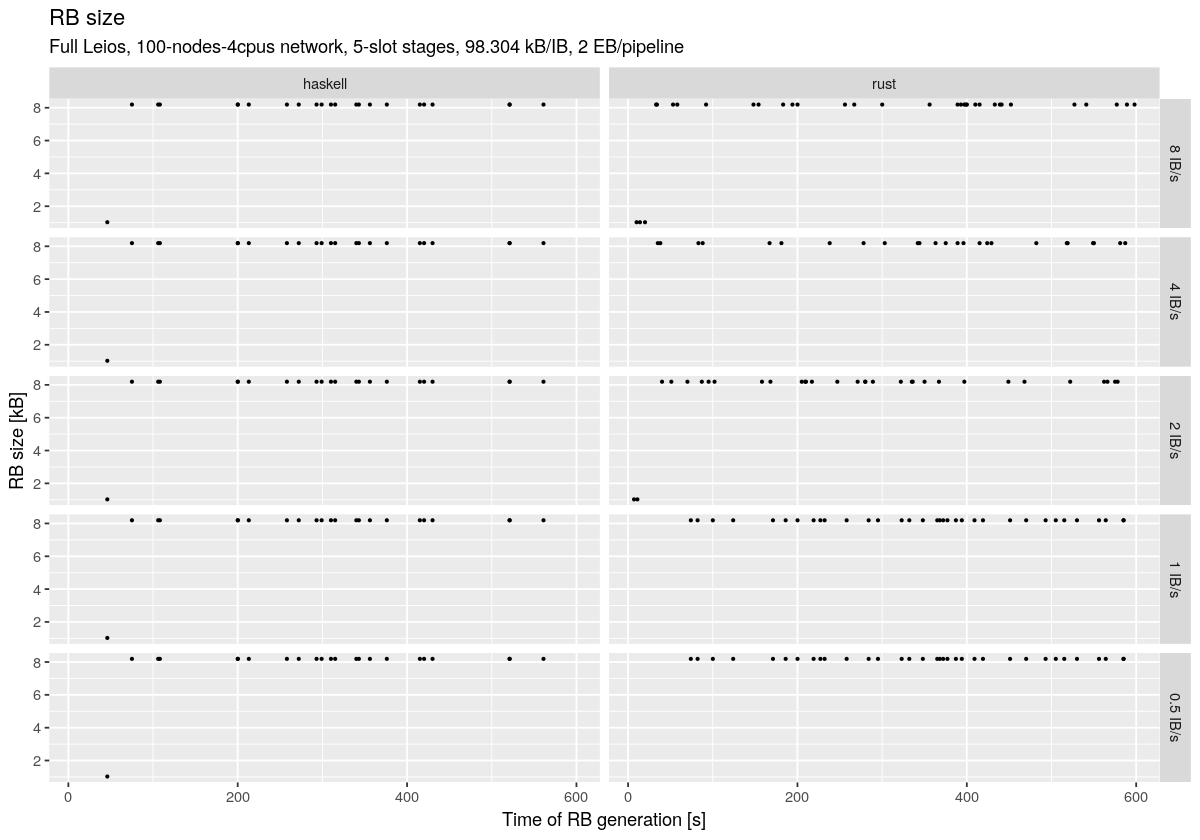

In [82]:
rbSizeTimeseries(
    rbgen[`ib-generation-probability` %in% ibRates], 
    "RB size",
    outfiles=paste0("plots/rb-size-histogram.png")
)